In [1]:
#Import required packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
import pickle
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline


output_file_path = "output_images/"
data_file_path = "data/"

## The next section is taken from the Udacity class.

### Features Definitions

In [2]:
from skimage.feature import hog

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## This sections is partially from Udacity class partially My own

### Feature Extraction

In [3]:
def get_color_features(img, color_space='RGB', spatial_size=(32,32) , 
                       spatial_feat =True, hist_bins = 32, orient = 9,
                      pix_per_cell = 8, cell_per_block=2, hog_channel = 0,
                      hist_feat=True, hog_feat=True, required_output = "feature_vector", HOG_vis = False):
    
    if len(np.asarray(img).shape)==3:
        features = []
        if color_space == 'RGB':
            feature_img= np.copy(img)
            if required_output == "Plot":
                return feature_img
        elif color_space != 'RGB':
            temp = 'cv2.COLOR_RGB2'+color_space
            color_required=eval(temp)
            feature_img = cv2.cvtColor(img,color_required)
            if required_output == "Plot":
                return feature_img

        file_features = []
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_img, size = spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_img,nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_img.shape[2]):
                        hog_temp=get_hog_features(feature_img[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=HOG_vis, feature_vec=True)
                        hog_features.append(hog_temp)
                    hog_features = np.ravel(hog_features)        
            else:
                hog_temp=get_hog_features(feature_img[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=HOG_vis, feature_vec=True)
                hog_features = hog_temp
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        if required_output == "feature_vector":
            return features
        elif required_output == "SF":
            return [spatial_features , feature_img]
        elif required_output == "HF":
            return [hist_features, feature_img]
        elif required_output == "HOGF":
            return [hog_temp, feature_img]
    else:
        features = []
        for i in range (len(img)):
            if color_space == 'RGB':
                feature_img= np.copy(img[i])
                if required_output == "Plot":
                    return feature_img
            elif color_space != 'RGB':
                temp = 'cv2.COLOR_RGB2'+color_space
                color_required=eval(temp)
                feature_img = cv2.cvtColor(img[i],color_required)
                if required_output == "Plot":
                    return feature_img

            file_features = []
            if spatial_feat == True:
                spatial_features = bin_spatial(feature_img, size = spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                hist_features = color_hist(feature_img,nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
                if hog_channel == 'ALL':
                        hog_features = []
                        for channel in range(feature_img.shape[2]):
                            hog_temp=get_hog_features(feature_img[:,:,channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=HOG_vis, feature_vec=True)
                            hog_features.append(hog_temp)
                        hog_features = np.ravel(hog_features)        
                else:
                    hog_temp=get_hog_features(feature_img[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=HOG_vis, feature_vec=True)
                    hog_features = hog_temp
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
        if required_output == "feature_vector":
            return features
        elif required_output == "SF":
            return [spatial_features , feature_img]
        elif required_output == "HF":
            return [hist_features, feature_img]
        elif required_output == "HOGF":
            return [hog_temp, feature_img]


### Import Car Pics

Number of images imported:    8792
Shape of images:              (64, 64, 3)


Random Car Image  :   7179


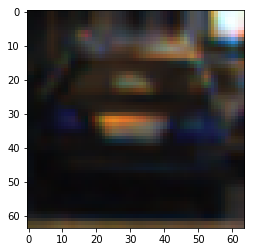

In [4]:
if not(os.path.exists("cars.p")):
    cars=[]
    for x in os.walk(data_file_path+"vehicles/vehicles/"):
        folder_name = (x[0].split('/')[3])
        carpics=glob.glob(x[0]+'/*.png')
        if len(carpics) > 0:
            for image in carpics:
                img=cv2.imread(image)
                cars.append(img)
else:
    cars=[]
    cars = pickle.load(open("cars.p","rb"))
print('Number of images imported:   ' , np.asarray(cars).shape[0])
print('Shape of images:             ' , np.asarray(cars).shape[1:])

print("\n")
temp=random.randint(0,np.asarray(cars).shape[0])
print("Random Car Image  :  ",temp)
plt.imshow(cars[temp])
pickle.dump(cars , open("cars.p","wb"))

Number of images imported:    8968
Shape of images:              (64, 64, 3)


Random not_Car Image  :   2507


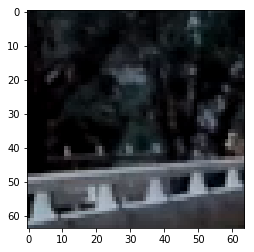

In [5]:
if not(os.path.exists("not_cars.p")):
    not_cars=[]
    for x in os.walk(data_file_path+"non_vehicles/non_vehicles/"):
        folder_name = (x[0].split('/')[3])
        notcarpics=glob.glob(x[0]+'/*.png')
        if len(notcarpics) > 0:
            for image in notcarpics:
                img=cv2.imread(image)
                not_cars.append(img)
else:
    not_cars=[]
    not_cars = pickle.load(open("not_cars.p","rb"))
    
print('Number of images imported:   ' , np.asarray(not_cars).shape[0])
print('Shape of images:             ' , np.asarray(not_cars).shape[1:])

print("\n")
temp=random.randint(0,np.asarray(not_cars).shape[0])
print("Random not_Car Image  :  ",temp)
plt.imshow(not_cars[temp])
pickle.dump(not_cars , open("not_cars.p","wb"))

### Visualize Different ColorSpaces

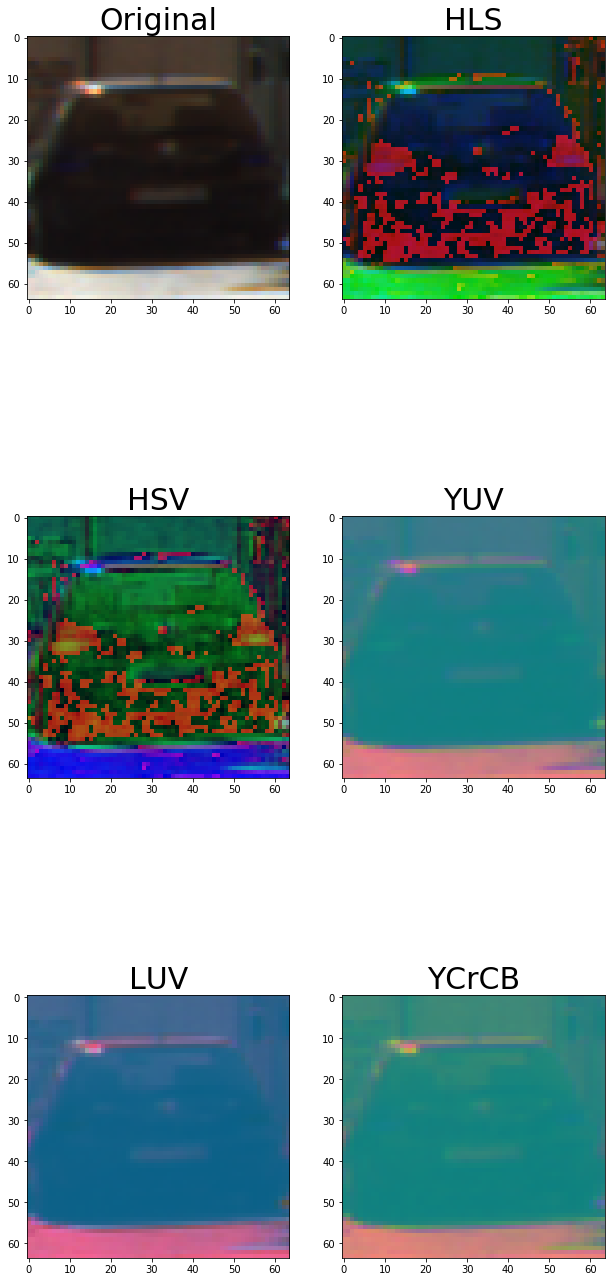

In [6]:
temp=random.randint(0,np.asarray(cars).shape[0])
figure=plt.figure(figsize = (16,25))
possible_CS=["HSV" , "LUV" , "HLS" , "YUV" , "YCrCb"]
plt.subplot2grid((3,3),(0,0))
plt.title("Original",fontsize =30)
plt.imshow(cars[temp])
plt.subplot2grid((3,3),(1,0))
plt.title("HSV",fontsize =30)
plt.imshow(get_color_features(cars[temp],"HSV" , required_output = "Plot"))
plt.subplot2grid((3,3),(2,0))
plt.title("LUV",fontsize =30)
plt.imshow(get_color_features(cars[temp],"LUV",  required_output = "Plot"))
plt.subplot2grid((3,3),(0,1))
plt.title("HLS",fontsize =30)
plt.imshow(get_color_features(cars[temp],"HLS",  required_output = "Plot"))
plt.subplot2grid((3,3),(1,1))
plt.title("YUV",fontsize =30)
plt.imshow(get_color_features(cars[temp],"YUV",  required_output = "Plot"))
plt.subplot2grid((3,3),(2,1))
plt.title("YCrCB",fontsize =30)
plt.imshow(get_color_features(cars[temp],"YCrCb",  required_output = "Plot"))

### Plot Spatial Features

C:\ProgramData\Miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


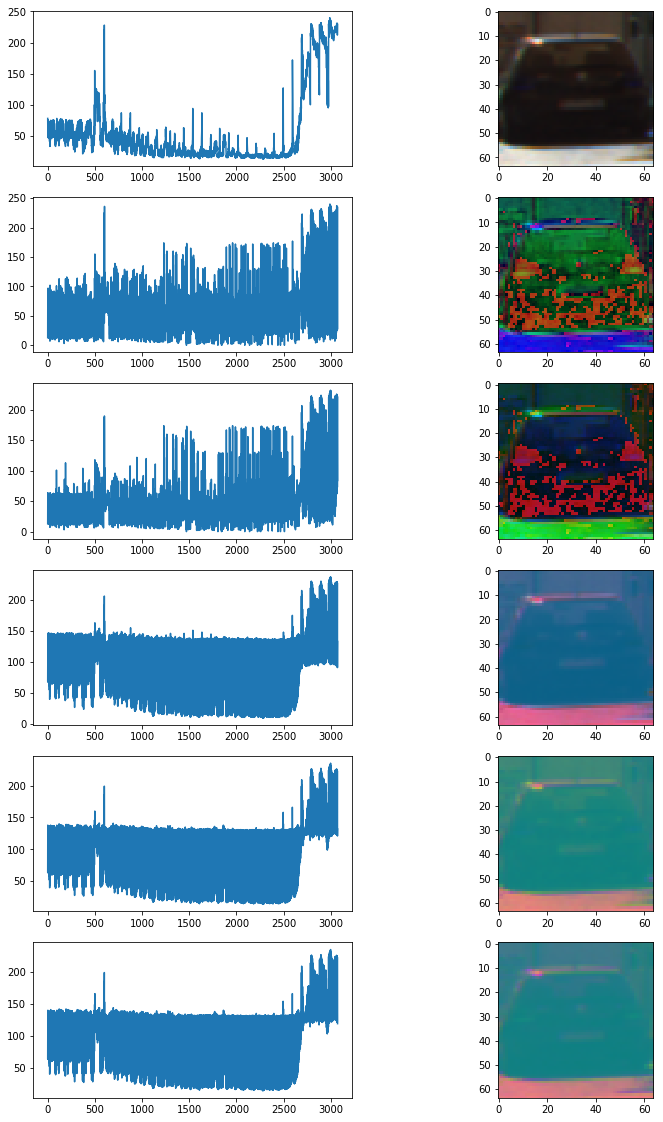

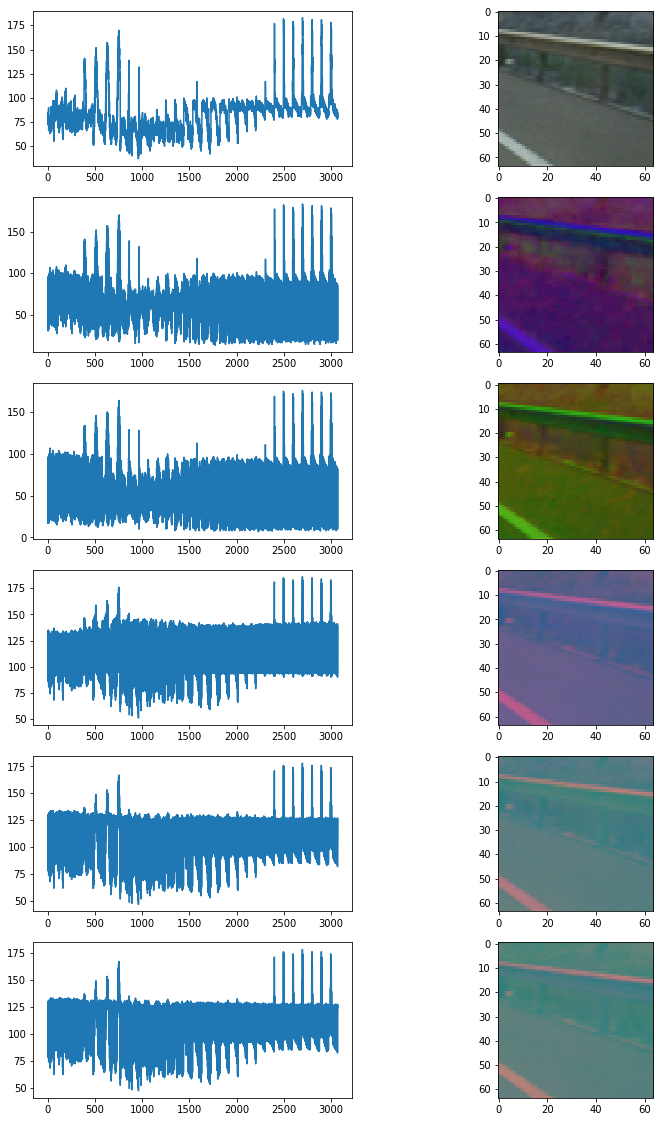

In [7]:
from pylab import *
List = ["RGB", "HSV","HLS", "LUV", "YCrCb", "YUV"] 
number_of_subplots=6
v=0
fig = plt.figure(figsize = (40,20))
for CS in List:
    feature_vec = get_color_features(cars[temp],color_space = CS, required_output="SF")
    plt.subplot2grid((6,number_of_subplots),(v,0))
    plt.plot(feature_vec[0])
    plt.subplot2grid((6,number_of_subplots),(v,1))
    plt.imshow(feature_vec[1])
    v+=1
v=0
fig = plt.figure(figsize = (40,20))
for CS in List:
    feature_vec = get_color_features(not_cars[temp],color_space = CS, required_output="SF")
    plt.subplot2grid((6,number_of_subplots),(v,0))
    plt.plot(feature_vec[0])
    plt.subplot2grid((6,number_of_subplots),(v,1))
    plt.imshow(feature_vec[1])
    v+=1
    

C:\ProgramData\Miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


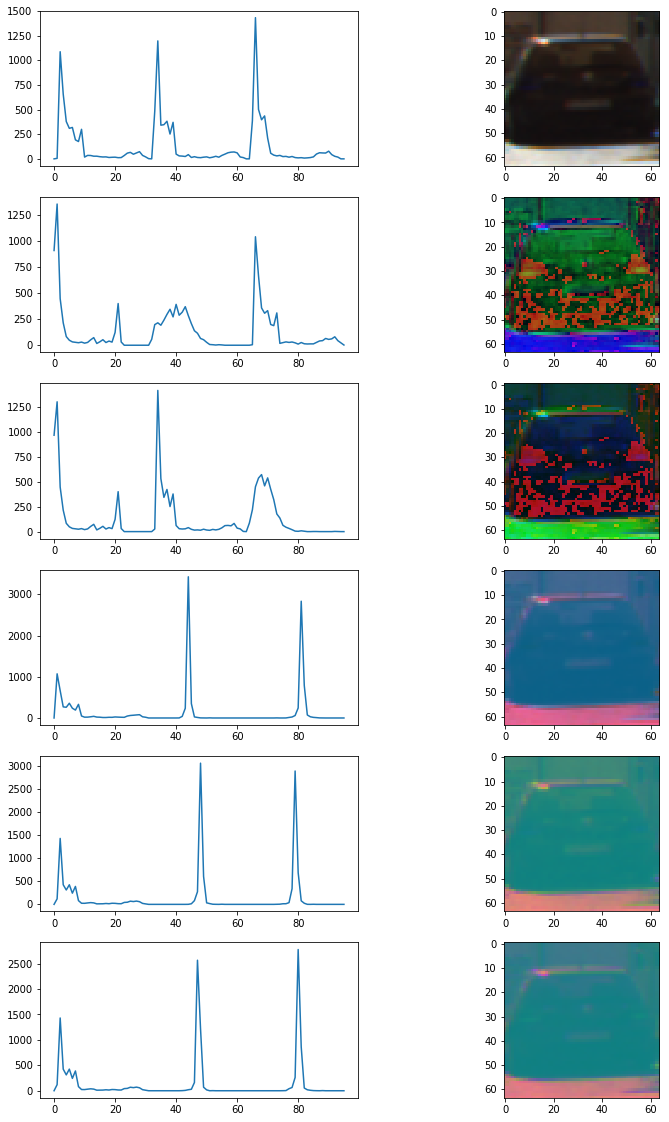

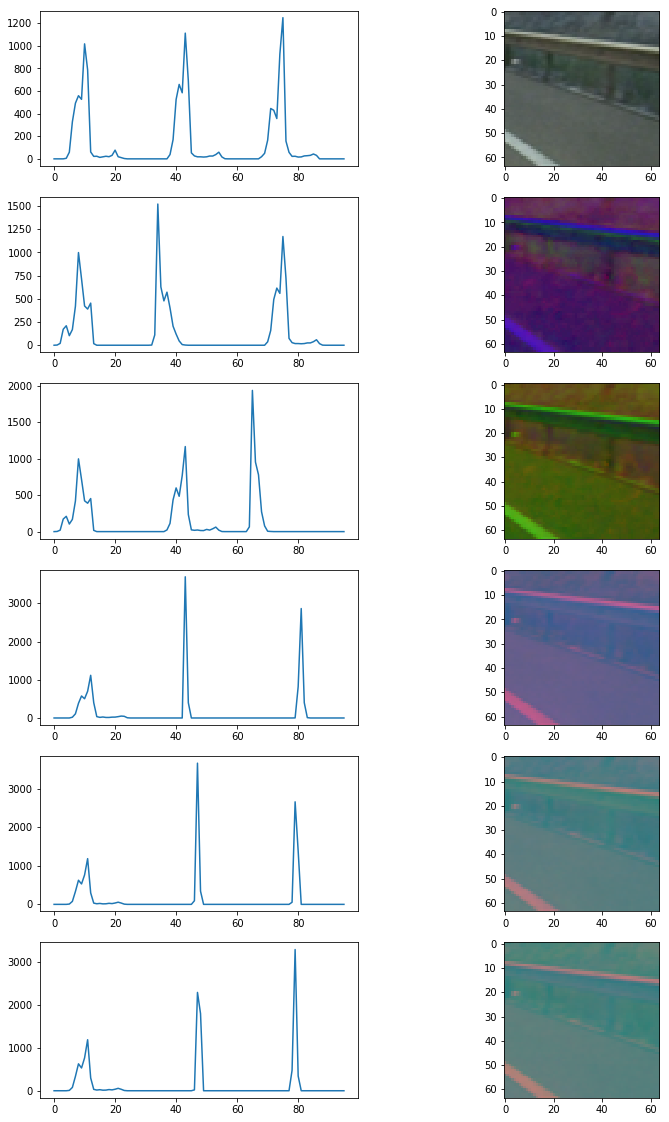

In [8]:
from pylab import *
List = ["RGB", "HSV","HLS", "LUV", "YCrCb", "YUV"] 
number_of_subplots=6
v=0
fig = plt.figure(figsize = (40,20))
for CS in List:
    feature_vec = get_color_features(cars[temp],color_space = CS, required_output="HF")
    plt.subplot2grid((6,number_of_subplots),(v,0))
    plt.plot(feature_vec[0])
    plt.subplot2grid((6,number_of_subplots),(v,1))
    plt.imshow(feature_vec[1])
    v+=1

v=0
fig = plt.figure(figsize = (40,20))
for CS in List:
    feature_vec = get_color_features(not_cars[temp],color_space = CS, required_output="HF")
    plt.subplot2grid((6,number_of_subplots),(v,0))
    plt.plot(feature_vec[0])
    plt.subplot2grid((6,number_of_subplots),(v,1))
    plt.imshow(feature_vec[1])
    v+=1

C:\ProgramData\Miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


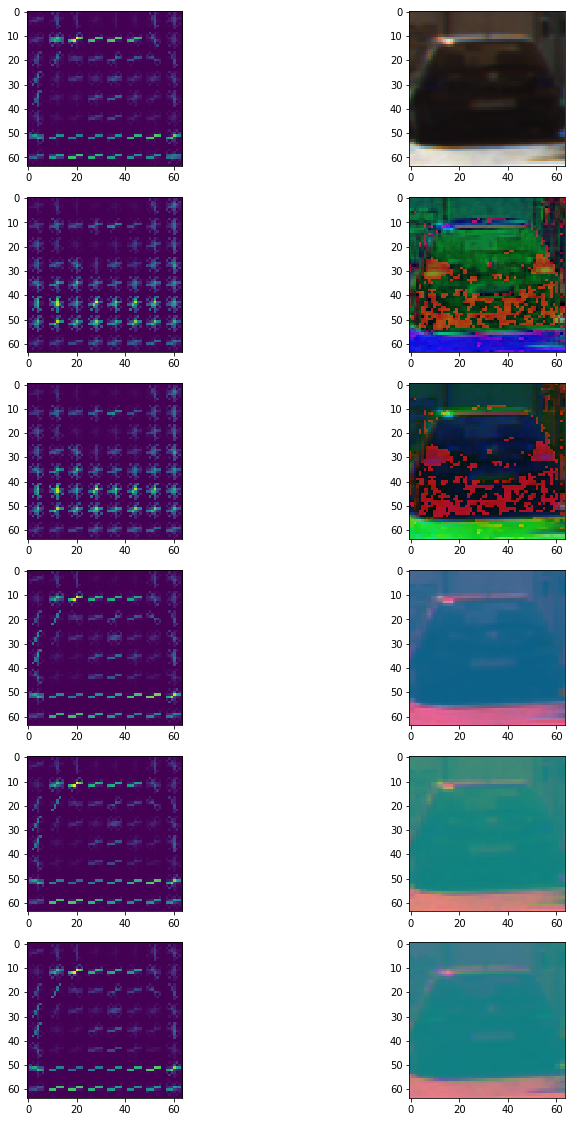

In [9]:
from pylab import *
List = ["RGB", "HSV","HLS", "LUV", "YCrCb", "YUV"] 
number_of_subplots=6
v=0
fig = plt.figure(figsize = (40,20))
orient = 9
pix_per_cell = 8
cell_per_block = 2
for CS in List:
    temp_img=get_color_features(cars[temp],color_space = CS, required_output="HOGF", HOG_vis = True)
    plt.subplot2grid((6,number_of_subplots),(v,0))
    plt.imshow(temp_img[0][1])
    plt.subplot2grid((6,number_of_subplots),(v,1))
    plt.imshow(temp_img[1])
    v+=1

## Test multiple combinations on database to find best accuracy

In [44]:
if not(os.path.exists("statistics.p")):
    import time
    from collections import defaultdict

    color_space = ["RGB", "HSV","HLS", "LUV", "YCrCb", "YUV"]  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = np.linspace(5,10,num = 6)
    orient= np.hstack((orient,(np.linspace(3,7,num = 5)*5 )))
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    Statistics = defaultdict(list)

    for CS in color_space:
        for ORIENT in orient:
            car_features = get_color_features(cars, color_space=CS, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=np.int(ORIENT), pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat, required_output="feature_vector")
            notcar_features = get_color_features(not_cars, color_space=CS, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=np.int(ORIENT), pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat,  required_output="feature_vector")


            X = np.vstack((car_features,notcar_features)).astype(np.float64)
            X_scaler = StandardScaler().fit(X)
            scaled_X = X_scaler.transform(X)

            y=np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

            rand_state = 45
            X_train,X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

            svc = LinearSVC()
            t =time.time()
            svc.fit(X_train,y_train)
            t2=time.time()

            print("Color Space : " , CS)
            print("Number of Hog Orientations  : " , ORIENT)
            print (round(t2-t,2), "Seconds to train")
            TA = svc.score(X_test,y_test)
            print ("test accuracy", TA)
            Statistics["CS"].append(CS)
            Statistics["Orient"].append(ORIENT)
            Statistics["Accuracy"].append(TA)
            print("\n")


Color Space :  RGB
Number of Hog Orientations  :  5.0
11.68 Seconds to train
test accuracy 0.982826576577


Color Space :  RGB
Number of Hog Orientations  :  6.0
15.66 Seconds to train
test accuracy 0.980011261261


Color Space :  RGB
Number of Hog Orientations  :  7.0
17.16 Seconds to train
test accuracy 0.983671171171


Color Space :  RGB
Number of Hog Orientations  :  8.0
19.01 Seconds to train
test accuracy 0.982263513514


Color Space :  RGB
Number of Hog Orientations  :  9.0
21.48 Seconds to train
test accuracy 0.983952702703


Color Space :  RGB
Number of Hog Orientations  :  10.0
25.15 Seconds to train
test accuracy 0.984797297297


Color Space :  RGB
Number of Hog Orientations  :  15.0
37.33 Seconds to train
test accuracy 0.986768018018


Color Space :  RGB
Number of Hog Orientations  :  20.0
53.63 Seconds to train
test accuracy 0.984234234234


Color Space :  RGB
Number of Hog Orientations  :  25.0
16.03 Seconds to train
test accuracy 0.983671171171


Color Space :  RGB
Numbe

In [45]:
if not(os.path.exists("statistics.p")):
    pickle.dump(Statistics, open("statistics.p","wb"))
else:
    Statistics = pickle.load(open("statistics.p","rb"))

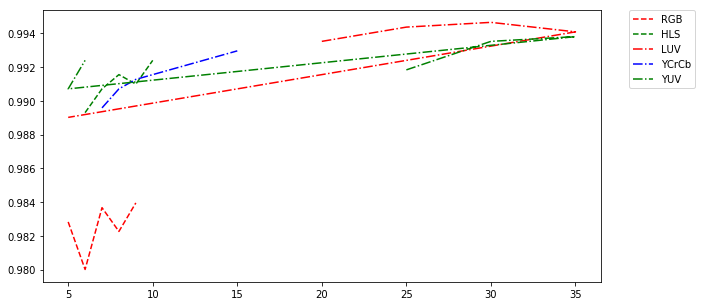



The combination with the highest accuracy is :
YCrCb
20.0
With an accuracy of :
0.997184684685


In [46]:
fig = plt.figure(figsize = (10,5))
plt.plot(Statistics["Orient"][0:5],Statistics["Accuracy"][0:5],'r--',label = "RGB") # RGB
# plt.plot(Statistics["Orient"][6:11],Statistics["Accuracy"][6:11],'b--',label = "HSV") # HSV
plt.plot(Statistics["Orient"][12:17],Statistics["Accuracy"][12:17],'g--',label = "HLS") # HLS
plt.plot(Statistics["Orient"][18:23],Statistics["Accuracy"][18:23],'r-.',label = "LUV") # LUV
plt.plot(Statistics["Orient"][24:29],Statistics["Accuracy"][24:29],'b-.',label = "YCrCb") # YCrCb
plt.plot(Statistics["Orient"][30:35],Statistics["Accuracy"][30:35],'g-.',label = "YUV") # YUV
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
plt.show()

print ("\n")
print("The combination with the highest accuracy is :")
print(Statistics["CS"][Statistics["Accuracy"].index(max(Statistics["Accuracy"]))])
print(Statistics["Orient"][Statistics["Accuracy"].index(max(Statistics["Accuracy"]))])
print("With an accuracy of :")
print(Statistics["Accuracy"][Statistics["Accuracy"].index(max(Statistics["Accuracy"]))])

##### Note this accuracy is also partially dependant on the random state the test and training data was split up.

### Run Best classifier on test image.

#### Reinitialize Intended/best SVC

In [13]:
from collections import defaultdict
import time


color_space = "YCrCb"  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 27 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

if not(os.path.exists("required_svc.p")):

    car_features = get_color_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, required_output="feature_vector")
    notcar_features = get_color_features(not_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat,  required_output="feature_vector")


    X = np.vstack((car_features,notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y=np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

    rand_state = 45
    X_train,X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

    svc = LinearSVC()
    t =time.time()
    svc.fit(X_train,y_train)
    t2=time.time()
    print(svc.score(X_test,y_test))


C:\ProgramData\Miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.99634009009


In [14]:
if not(os.path.exists("required_svc.p")):
    required_svc = [X_scaler, svc]
    pickle.dump(required_svc , open("required_svc.p", "wb"))
else:
    [X_scaler,svc] = pickle.load(open("required_svc.p","rb"))

In [15]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            endx += (np.int(np.round(endx*(xs*0.002))))
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [24]:
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=27,
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=False, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    conf_list = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = get_color_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=False, 
                            hist_feat=True, hog_feat=hog_feat, required_output="feature_vector")
        #print(np.asarray(features).shape)
        #5) Scale extracted features to be fed to classifier
        #print(np.asarray(features).shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        conf = clf.decision_function(test_features)
        
        #print(prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            #print(window, conf)
            if conf > 0.93:
                on_windows.append(window)
                
    #8) Return windows for positive detections
    return on_windows

In [17]:
def region_of_interest (img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask,vertices,ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope_line(pts):
    pt1 = pts[0]
    pt2 = pts[1]
    return ((pt2[1]-pt1[1])/(pt2[0]-pt1[0]))



### Draw Bounding boxes Function

In [18]:
def draw_boxes(img, bboxes, color = (0,0,255),thick = 6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    return imcopy



### Implement Heat Map

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bboxD
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    #print(heatmap)
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        temp = (np.add(bbox[0],bbox[1])/2)
        cv2.putText(img, str(car_number), (int(temp[0]),int(temp[1])), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 10)
    # Return the image
    return img

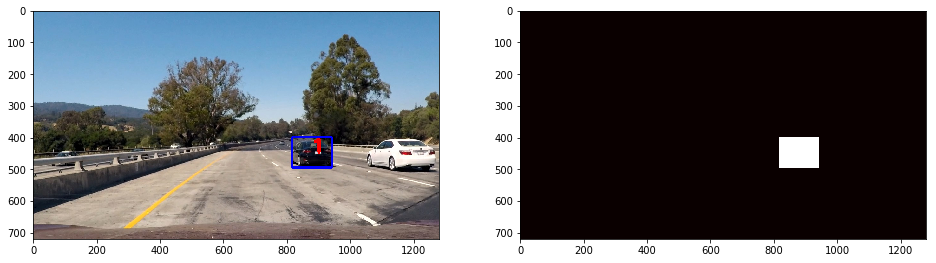

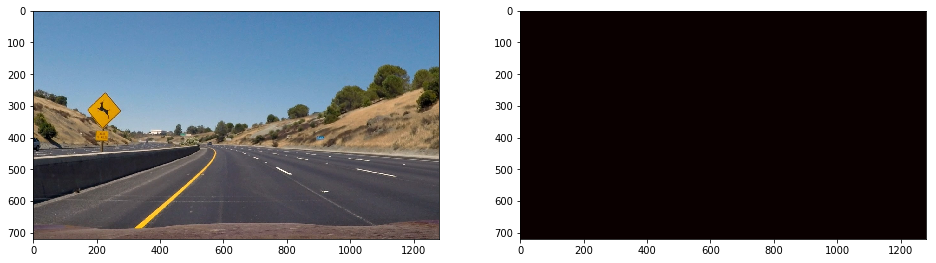

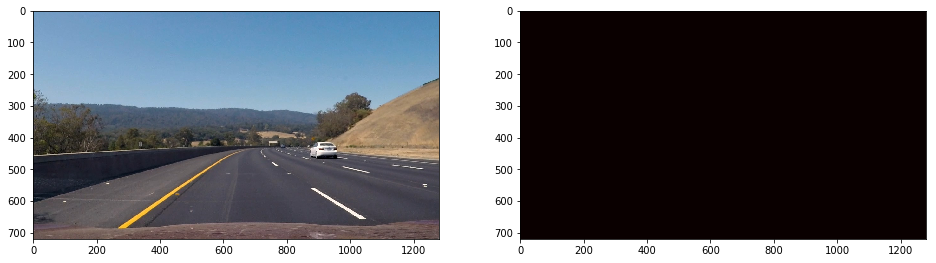

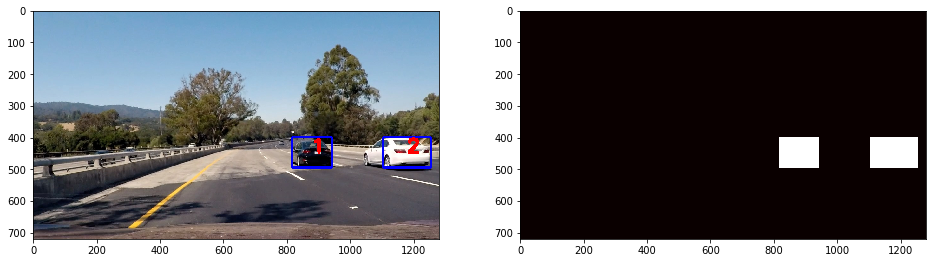

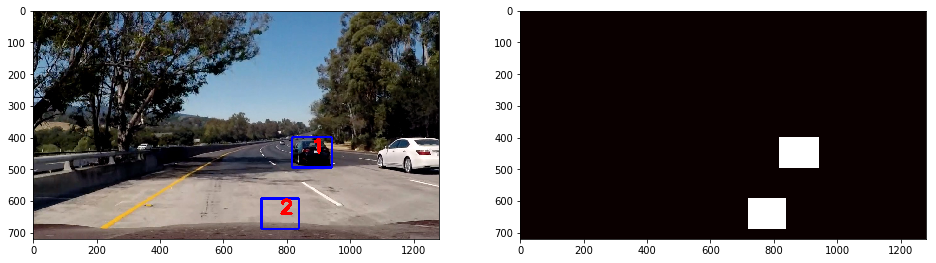

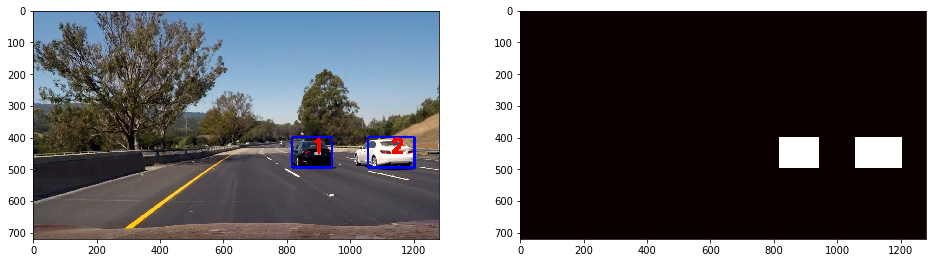

In [25]:
from scipy.ndimage.measurements import label
test_images=glob.glob("test_images/test*.jpg")

for image in test_images:
#img = mpimg.imread("test_images/test5.jpg")
    img = mpimg.imread(image)
    heat=np.zeros_like(img[:,:,0]).astype(np.float)
    y_start_stop = [400,720]
    draw_image=np.copy(img)
    roi_vertices = np.asarray([[[0, 400],[img.shape[1],400],[img.shape[1],img.shape[0]]]], dtype = np.int32)
    new_img=region_of_interest(draw_image, roi_vertices)
    windows = slide_window(new_img,x_start_stop=[None,None], y_start_stop=y_start_stop,
                          xy_window = (96, 96), xy_overlap = (0.5,0.5))
    hot_windows = search_windows(new_img,windows, svc, X_scaler, color_space="YCrCb", 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=27, pix_per_cell=8, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=True, hog_feat=hog_feat)  
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    heatmap = np.clip(heat, 0 ,255)
    labels = label(heatmap)

    draw_img2 = draw_labeled_bboxes(np.copy(img), labels)
    #window_img = draw_boxes(draw_image, filtered_windows, color=(0, 0, 255), thick=6)                    

    fig=plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(draw_img2)
    plt.subplot(122)
    plt.imshow(heatmap, cmap ='hot')



# Test for Lane Pipeline

## Video Start

In [21]:
# Import packages for Video buffering
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def main_pipeline(img):
    global Frame
    global cache, local_counter, reserve_cache
    heat=np.zeros_like(img[:,:,0]).astype(np.float)
    y_start_stop = [400,720]
    draw_image=np.copy(img)
    roi_vertices = np.asarray([[[190, img.shape[0]],[550,400],[img.shape[1],400],[img.shape[1],img.shape[0]]]], dtype = np.int32)
    new_img=region_of_interest(draw_image, roi_vertices)
    windows = slide_window(new_img,x_start_stop=[300,None], y_start_stop=y_start_stop,
                          xy_window = (96, 96), xy_overlap = (0.5,0.5))
    hot_windows = search_windows(new_img,windows, svc, X_scaler, color_space="YCrCb", 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=27, pix_per_cell=8, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=True, hog_feat=hog_feat)  
    # Add heat to each box in box list
    if local_counter <2 :
        for bbox in hot_windows:
            reserve_cache.append(bbox)
        local_counter +=1
    elif local_counter >=2:
        local_counter =0
        for bbox in hot_windows:
            if reserve_cache.count(bbox) >4:
                cache.append(bbox)   
                if len(cache) >4:
                    cache.pop(0)
            else:
                reserve_cache.append(bbox)
        local_counter +=1
      
        
    heat = add_heat(heat,cache)
    heatmap = np.clip(heat, 0 ,10)
    labels = label(heatmap)
    draw_img2 = draw_labeled_bboxes(np.copy(img), labels)
    #window_img = draw_boxes(draw_image, filtered_windows, color=(0, 0, 255), thick=6)                    
    #plt.imshow(draw_img2)
    #plt.savefig("VideoFrames/Frame"+str(Frame)+".jpg")

    Frame+=1
    return draw_img2

In [23]:
global Frame
global cache, reserve_cache
reserve_cache=[]
global local_counter
local_counter =1
cache = []
Frame=1
out='Project_Video_Processed7.mp4'
video=VideoFileClip('project_video.mp4')
# gives about 25 frames per sec (+/-1)
video_clip =video.fl_image(main_pipeline)
%time video_clip.write_videofile(out, audio=False)

[MoviePy] >>>> Building video Project_Video_Processed7.mp4
[MoviePy] Writing video Project_Video_Processed7.mp4


  0%|          | 5/1261 [00:02<10:51,  1.93it/s]

((540, 448), (642, 544)) [ 0.33559641]


  1%|          | 7/1261 [00:03<10:48,  1.93it/s]

((540, 448), (642, 544)) [ 0.46216112]


  1%|          | 8/1261 [00:04<10:45,  1.94it/s]

((540, 448), (642, 544)) [ 0.32955601]


  9%|▉         | 116/1261 [00:58<09:46,  1.95it/s]

((1164, 448), (1305, 544)) [ 0.09251277]


  9%|▉         | 117/1261 [00:59<09:55,  1.92it/s]

((1164, 448), (1305, 544)) [ 0.18974945]


  9%|▉         | 118/1261 [00:59<09:54,  1.92it/s]

((1164, 448), (1305, 544)) [ 0.32450203]


 10%|█         | 128/1261 [01:04<09:33,  1.98it/s]

((1116, 448), (1253, 544)) [ 0.53298833]


 12%|█▏        | 155/1261 [01:18<09:30,  1.94it/s]

((1164, 400), (1305, 496)) [ 0.62546354]


 12%|█▏        | 156/1261 [01:19<09:27,  1.95it/s]

((1068, 400), (1201, 496)) [ 0.1130254]
((1164, 400), (1305, 496)) [ 0.643735]


 12%|█▏        | 157/1261 [01:19<09:27,  1.95it/s]

((1068, 400), (1201, 496)) [ 0.10795912]
((1164, 400), (1305, 496)) [ 1.2614314]
((1164, 448), (1305, 544)) [ 0.00606205]


 13%|█▎        | 158/1261 [01:20<09:31,  1.93it/s]

((1068, 400), (1201, 496)) [ 0.08633924]
((1164, 400), (1305, 496)) [ 1.13673525]


 13%|█▎        | 159/1261 [01:20<09:30,  1.93it/s]

((1164, 400), (1305, 496)) [ 1.76927438]


 13%|█▎        | 160/1261 [01:21<09:28,  1.94it/s]

((1164, 400), (1305, 496)) [ 1.05207525]


 13%|█▎        | 161/1261 [01:21<09:23,  1.95it/s]

((1116, 400), (1253, 496)) [ 0.02269285]
((1164, 400), (1305, 496)) [ 0.73055743]


 13%|█▎        | 162/1261 [01:22<09:23,  1.95it/s]

((1116, 400), (1253, 496)) [ 1.0083511]
((1164, 400), (1305, 496)) [ 0.29708873]


 13%|█▎        | 163/1261 [01:22<09:23,  1.95it/s]

((1116, 400), (1253, 496)) [ 0.51509129]
((1164, 400), (1305, 496)) [ 0.99625411]


 13%|█▎        | 164/1261 [01:23<09:23,  1.95it/s]

((1116, 400), (1253, 496)) [ 0.10566704]
((1164, 400), (1305, 496)) [ 0.79480027]


 13%|█▎        | 165/1261 [01:23<09:26,  1.93it/s]

((1116, 400), (1253, 496)) [ 0.12670427]
((1164, 400), (1305, 496)) [ 0.91572497]


 13%|█▎        | 166/1261 [01:24<09:29,  1.92it/s]

((1116, 400), (1253, 496)) [ 0.25383777]
((1164, 400), (1305, 496)) [ 1.22305155]


 13%|█▎        | 167/1261 [01:24<09:32,  1.91it/s]

((1020, 400), (1149, 496)) [ 0.02791486]
((1116, 400), (1253, 496)) [ 1.1685274]
((1164, 400), (1305, 496)) [ 0.69199607]


 13%|█▎        | 168/1261 [01:25<09:34,  1.90it/s]

((1116, 400), (1253, 496)) [ 0.88579279]
((1164, 400), (1305, 496)) [ 0.40213172]


 13%|█▎        | 169/1261 [01:26<09:33,  1.91it/s]

((1116, 400), (1253, 496)) [ 1.32271544]
((1164, 400), (1305, 496)) [ 0.48341846]


 13%|█▎        | 170/1261 [01:26<09:30,  1.91it/s]

((1116, 400), (1253, 496)) [ 1.44984014]
((1164, 400), (1305, 496)) [ 0.59273256]


 14%|█▎        | 171/1261 [01:27<09:27,  1.92it/s]

((1116, 400), (1253, 496)) [ 1.88473099]
((1164, 400), (1305, 496)) [ 0.53543909]


 14%|█▎        | 172/1261 [01:27<09:24,  1.93it/s]

((1116, 400), (1253, 496)) [ 1.41216147]
((1164, 400), (1305, 496)) [ 1.03538721]


 14%|█▎        | 173/1261 [01:28<09:23,  1.93it/s]

((1116, 400), (1253, 496)) [ 1.73956087]
((1164, 400), (1305, 496)) [ 0.54211218]


 14%|█▍        | 174/1261 [01:28<09:24,  1.92it/s]

((1116, 400), (1253, 496)) [ 1.66682785]


 14%|█▍        | 175/1261 [01:29<09:25,  1.92it/s]

((1116, 400), (1253, 496)) [ 1.01316318]


 14%|█▍        | 176/1261 [01:29<09:27,  1.91it/s]

((1116, 400), (1253, 496)) [ 1.34043408]


 14%|█▍        | 177/1261 [01:30<09:29,  1.90it/s]

((540, 400), (642, 496)) [ 0.03905807]
((1116, 400), (1253, 496)) [ 0.78793542]


 14%|█▍        | 178/1261 [01:30<09:31,  1.89it/s]

((1020, 400), (1149, 496)) [ 0.20195875]
((1116, 400), (1253, 496)) [ 1.58573773]
((1164, 400), (1305, 496)) [ 0.02412965]


 14%|█▍        | 179/1261 [01:31<09:34,  1.88it/s]

((1020, 400), (1149, 496)) [ 0.22179689]
((1116, 400), (1253, 496)) [ 0.75243251]


 14%|█▍        | 180/1261 [01:31<09:32,  1.89it/s]

((1116, 400), (1253, 496)) [ 1.20946268]


 14%|█▍        | 181/1261 [01:32<09:27,  1.90it/s]

((1116, 400), (1253, 496)) [ 0.89476024]


 14%|█▍        | 182/1261 [01:32<09:20,  1.93it/s]

((1116, 400), (1253, 496)) [ 0.85154692]


 15%|█▍        | 183/1261 [01:33<09:15,  1.94it/s]

((1068, 400), (1201, 496)) [ 0.3537634]
((1116, 400), (1253, 496)) [ 1.0530745]


 15%|█▍        | 184/1261 [01:33<09:14,  1.94it/s]

((1116, 400), (1253, 496)) [ 1.30667245]


 15%|█▍        | 185/1261 [01:34<09:14,  1.94it/s]

((1116, 400), (1253, 496)) [ 1.37877641]


 15%|█▍        | 186/1261 [01:34<09:12,  1.95it/s]

((1068, 400), (1201, 496)) [ 0.12056914]
((1116, 400), (1253, 496)) [ 1.16557175]


 15%|█▍        | 187/1261 [01:35<09:14,  1.94it/s]

((1116, 400), (1253, 496)) [ 1.60119105]


 15%|█▍        | 188/1261 [01:35<09:16,  1.93it/s]

((1116, 400), (1253, 496)) [ 1.24216871]


 15%|█▍        | 189/1261 [01:36<09:18,  1.92it/s]

((1068, 400), (1201, 496)) [ 0.13782738]
((1116, 400), (1253, 496)) [ 1.25605226]
((1164, 400), (1305, 496)) [ 0.09865145]


 15%|█▌        | 190/1261 [01:36<09:20,  1.91it/s]

((1068, 400), (1201, 496)) [ 0.10463847]
((1116, 400), (1253, 496)) [ 1.7419689]


 15%|█▌        | 191/1261 [01:37<09:17,  1.92it/s]

((1068, 400), (1201, 496)) [ 0.88987788]
((1116, 400), (1253, 496)) [ 1.33169082]
((1164, 400), (1305, 496)) [ 0.07493938]


 15%|█▌        | 192/1261 [01:37<09:17,  1.92it/s]

((1068, 400), (1201, 496)) [ 1.34059812]
((1116, 400), (1253, 496)) [ 1.15105629]


 15%|█▌        | 193/1261 [01:38<09:17,  1.91it/s]

((1068, 400), (1201, 496)) [ 0.8934966]
((1116, 400), (1253, 496)) [ 1.64824327]


 15%|█▌        | 194/1261 [01:39<09:22,  1.90it/s]

((1068, 400), (1201, 496)) [ 0.2871064]
((1116, 400), (1253, 496)) [ 1.58363777]


 15%|█▌        | 195/1261 [01:39<09:22,  1.90it/s]

((1068, 400), (1201, 496)) [ 0.12806409]
((1116, 400), (1253, 496)) [ 1.25609466]


 16%|█▌        | 196/1261 [01:40<09:24,  1.89it/s]

((1068, 400), (1201, 496)) [ 1.23413431]
((1116, 400), (1253, 496)) [ 0.34349985]


 16%|█▌        | 197/1261 [01:40<09:22,  1.89it/s]

((1068, 400), (1201, 496)) [ 1.43175628]
((1116, 400), (1253, 496)) [ 0.00524434]


 16%|█▌        | 198/1261 [01:41<09:23,  1.89it/s]

((1068, 400), (1201, 496)) [ 1.40773845]


 16%|█▌        | 199/1261 [01:41<09:20,  1.90it/s]

((1068, 400), (1201, 496)) [ 1.31298496]


 16%|█▌        | 200/1261 [01:42<09:16,  1.90it/s]

((1068, 400), (1201, 496)) [ 1.64362549]


 16%|█▌        | 201/1261 [01:42<09:14,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.97237693]


 16%|█▌        | 202/1261 [01:43<09:15,  1.91it/s]

((1068, 400), (1201, 496)) [ 2.02609709]


 16%|█▌        | 203/1261 [01:43<09:14,  1.91it/s]

((1068, 400), (1201, 496)) [ 2.22256257]
((1164, 448), (1305, 544)) [ 0.06633721]


 16%|█▌        | 204/1261 [01:44<09:13,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.68405269]
((1164, 448), (1305, 544)) [ 0.18028143]


 16%|█▋        | 205/1261 [01:44<09:12,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.5804581]


 16%|█▋        | 206/1261 [01:45<09:11,  1.91it/s]

((972, 400), (1098, 496)) [ 0.14483395]
((1068, 400), (1201, 496)) [ 1.34961207]


 16%|█▋        | 207/1261 [01:45<09:13,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.27460995]
((1116, 400), (1253, 496)) [ 0.16931063]
((1068, 448), (1201, 544)) [ 0.02716971]


 16%|█▋        | 208/1261 [01:46<09:13,  1.90it/s]

((1068, 400), (1201, 496)) [ 1.96347005]


 17%|█▋        | 209/1261 [01:46<09:10,  1.91it/s]

((972, 400), (1098, 496)) [ 0.06487118]
((1068, 400), (1201, 496)) [ 1.71428208]


 17%|█▋        | 210/1261 [01:47<09:09,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.56525956]


 17%|█▋        | 211/1261 [01:47<09:09,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.43538848]


 17%|█▋        | 212/1261 [01:48<09:05,  1.92it/s]

((1068, 400), (1201, 496)) [ 1.8054634]


 17%|█▋        | 213/1261 [01:48<09:01,  1.94it/s]

((1068, 400), (1201, 496)) [ 1.74424518]


 17%|█▋        | 214/1261 [01:49<08:59,  1.94it/s]

((1068, 400), (1201, 496)) [ 1.62000786]


 17%|█▋        | 215/1261 [01:50<08:58,  1.94it/s]

((1068, 400), (1201, 496)) [ 1.80218816]


 17%|█▋        | 216/1261 [01:50<08:59,  1.94it/s]

((1068, 400), (1201, 496)) [ 1.49307311]


 17%|█▋        | 217/1261 [01:51<08:59,  1.93it/s]

((1068, 400), (1201, 496)) [ 1.84601909]


 17%|█▋        | 218/1261 [01:51<09:02,  1.92it/s]

((1068, 400), (1201, 496)) [ 1.76332521]
((1116, 400), (1253, 496)) [ 0.21486105]


 17%|█▋        | 219/1261 [01:52<08:57,  1.94it/s]

((972, 400), (1098, 496)) [ 0.01416778]
((1068, 400), (1201, 496)) [ 1.92569628]
((1116, 400), (1253, 496)) [ 0.23344577]


 17%|█▋        | 220/1261 [01:52<08:58,  1.93it/s]

((1068, 400), (1201, 496)) [ 2.22216179]


 18%|█▊        | 221/1261 [01:53<08:57,  1.94it/s]

((1068, 400), (1201, 496)) [ 2.0793591]
((1116, 400), (1253, 496)) [ 0.58970528]


 18%|█▊        | 222/1261 [01:53<08:57,  1.93it/s]

((1068, 400), (1201, 496)) [ 2.13722242]
((1116, 400), (1253, 496)) [ 0.2478899]


 18%|█▊        | 223/1261 [01:54<08:57,  1.93it/s]

((972, 400), (1098, 496)) [ 0.0306094]
((1068, 400), (1201, 496)) [ 2.34635136]
((1116, 400), (1253, 496)) [ 0.13556609]


 18%|█▊        | 224/1261 [01:54<09:00,  1.92it/s]

((1068, 400), (1201, 496)) [ 2.08417312]
((1116, 400), (1253, 496)) [ 0.37868923]


 18%|█▊        | 225/1261 [01:55<09:01,  1.91it/s]

((1068, 400), (1201, 496)) [ 2.19906249]
((1116, 400), (1253, 496)) [ 0.77723159]


 18%|█▊        | 226/1261 [01:55<09:02,  1.91it/s]

((1068, 400), (1201, 496)) [ 2.28600185]
((1116, 400), (1253, 496)) [ 0.70342617]


 18%|█▊        | 227/1261 [01:56<09:02,  1.91it/s]

((1068, 400), (1201, 496)) [ 2.14333328]
((1116, 400), (1253, 496)) [ 0.73351076]


 18%|█▊        | 228/1261 [01:56<09:00,  1.91it/s]

((1068, 400), (1201, 496)) [ 1.551959]
((1116, 400), (1253, 496)) [ 0.28725132]


 18%|█▊        | 229/1261 [01:57<08:57,  1.92it/s]

((1068, 400), (1201, 496)) [ 1.60073736]
((1116, 400), (1253, 496)) [ 0.60879657]


 18%|█▊        | 230/1261 [01:57<08:56,  1.92it/s]

((1068, 400), (1201, 496)) [ 0.98741894]
((1116, 400), (1253, 496)) [ 0.0883244]


 18%|█▊        | 231/1261 [01:58<08:54,  1.93it/s]

((1068, 400), (1201, 496)) [ 0.95790291]
((1116, 400), (1253, 496)) [ 0.06186183]


 18%|█▊        | 232/1261 [01:58<08:53,  1.93it/s]

((1020, 400), (1149, 496)) [ 0.17268082]
((1068, 400), (1201, 496)) [ 0.72772941]
((1116, 400), (1253, 496)) [ 0.64867366]


 18%|█▊        | 233/1261 [01:59<08:57,  1.91it/s]

((1068, 400), (1201, 496)) [ 0.40393921]


 19%|█▊        | 234/1261 [01:59<08:55,  1.92it/s]

((1020, 400), (1149, 496)) [ 0.43286561]
((1068, 400), (1201, 496)) [ 1.25543632]


 19%|█▊        | 235/1261 [02:00<08:52,  1.93it/s]

((1020, 400), (1149, 496)) [ 0.24163054]
((1068, 400), (1201, 496)) [ 0.49563161]


 19%|█▊        | 236/1261 [02:00<08:50,  1.93it/s]

((588, 400), (692, 496)) [ 0.01637394]
((1020, 400), (1149, 496)) [ 1.29176707]
((1068, 400), (1201, 496)) [ 0.24620847]


 19%|█▉        | 237/1261 [02:01<08:49,  1.93it/s]

((1020, 400), (1149, 496)) [ 0.57223815]
((1068, 400), (1201, 496)) [ 0.4364983]


 19%|█▉        | 238/1261 [02:01<08:46,  1.94it/s]

((828, 400), (944, 496)) [ 0.08858381]
((1020, 400), (1149, 496)) [ 0.88025949]


 19%|█▉        | 239/1261 [02:02<08:45,  1.94it/s]

((1020, 400), (1149, 496)) [ 1.17826703]


 19%|█▉        | 240/1261 [02:02<08:46,  1.94it/s]

((1020, 400), (1149, 496)) [ 1.06478249]
((1068, 400), (1201, 496)) [ 0.20429277]


 19%|█▉        | 241/1261 [02:03<08:51,  1.92it/s]

((1020, 400), (1149, 496)) [ 1.36340997]


 19%|█▉        | 242/1261 [02:04<08:51,  1.92it/s]

((1020, 400), (1149, 496)) [ 1.21188689]
((1068, 400), (1201, 496)) [ 0.02756698]


 19%|█▉        | 243/1261 [02:04<08:52,  1.91it/s]

((1020, 400), (1149, 496)) [ 1.72929978]
((1164, 400), (1305, 496)) [ 0.12463392]


 19%|█▉        | 244/1261 [02:05<08:50,  1.92it/s]

((1020, 400), (1149, 496)) [ 1.44663222]
((1068, 400), (1201, 496)) [ 0.13661925]
((1164, 400), (1305, 496)) [ 0.56337219]


 19%|█▉        | 245/1261 [02:05<08:52,  1.91it/s]

((1020, 400), (1149, 496)) [ 1.60173686]
((1116, 400), (1253, 496)) [ 0.0459448]
((1164, 400), (1305, 496)) [ 0.10586087]


 20%|█▉        | 246/1261 [02:06<09:02,  1.87it/s]

((924, 400), (1047, 496)) [ 0.24088781]
((1020, 400), (1149, 496)) [ 1.27760746]
((1068, 400), (1201, 496)) [ 0.108794]
((1164, 400), (1305, 496)) [ 0.35054016]


 20%|█▉        | 247/1261 [02:06<09:06,  1.86it/s]

((924, 400), (1047, 496)) [ 0.42028998]
((1020, 400), (1149, 496)) [ 2.06509943]
((1068, 400), (1201, 496)) [ 0.34145763]
((1164, 400), (1305, 496)) [ 0.12839173]


 20%|█▉        | 248/1261 [02:07<09:09,  1.84it/s]

((924, 400), (1047, 496)) [ 0.30314733]
((1020, 400), (1149, 496)) [ 1.96649086]
((1068, 400), (1201, 496)) [ 0.03752927]


 20%|█▉        | 249/1261 [02:07<09:03,  1.86it/s]

((924, 400), (1047, 496)) [ 0.21433814]
((1020, 400), (1149, 496)) [ 1.92964653]
((1164, 400), (1305, 496)) [ 0.07079854]


 20%|█▉        | 250/1261 [02:08<09:01,  1.87it/s]

((924, 400), (1047, 496)) [ 0.24079264]
((1020, 400), (1149, 496)) [ 2.04960999]
((1116, 400), (1253, 496)) [ 0.285355]


 20%|█▉        | 251/1261 [02:08<09:00,  1.87it/s]

((924, 400), (1047, 496)) [ 0.6005679]
((1020, 400), (1149, 496)) [ 2.04148292]


 20%|█▉        | 252/1261 [02:09<08:57,  1.88it/s]

((924, 400), (1047, 496)) [ 0.68116502]
((1020, 400), (1149, 496)) [ 1.9560977]
((1068, 400), (1201, 496)) [ 0.20629647]
((1116, 400), (1253, 496)) [ 0.47180331]


 20%|██        | 253/1261 [02:09<08:55,  1.88it/s]

((924, 400), (1047, 496)) [ 0.45452677]
((1020, 400), (1149, 496)) [ 2.13346035]
((1116, 400), (1253, 496)) [ 0.55882932]


 20%|██        | 254/1261 [02:10<08:58,  1.87it/s]

((924, 400), (1047, 496)) [ 0.2546642]
((1020, 400), (1149, 496)) [ 2.2026549]
((1116, 400), (1253, 496)) [ 0.77691219]


 20%|██        | 255/1261 [02:11<08:53,  1.89it/s]

((1020, 400), (1149, 496)) [ 1.80931813]
((1116, 400), (1253, 496)) [ 0.11227548]


 20%|██        | 256/1261 [02:11<08:48,  1.90it/s]

((924, 400), (1047, 496)) [ 0.08283766]
((1020, 400), (1149, 496)) [ 2.15065954]
((1116, 400), (1253, 496)) [ 0.46596012]


 20%|██        | 257/1261 [02:12<08:47,  1.90it/s]

((924, 400), (1047, 496)) [ 0.37973019]
((1020, 400), (1149, 496)) [ 2.12518758]
((1116, 400), (1253, 496)) [ 1.06157125]


 20%|██        | 258/1261 [02:12<08:46,  1.90it/s]

((924, 400), (1047, 496)) [ 0.15768065]
((1020, 400), (1149, 496)) [ 2.45365079]
((1116, 400), (1253, 496)) [ 0.53187876]


 21%|██        | 259/1261 [02:13<08:51,  1.88it/s]

((1020, 400), (1149, 496)) [ 2.47597545]
((1116, 400), (1253, 496)) [ 0.82705501]


 21%|██        | 260/1261 [02:13<08:49,  1.89it/s]

((1020, 400), (1149, 496)) [ 2.30806726]
((1116, 400), (1253, 496)) [ 1.28232082]


 21%|██        | 261/1261 [02:14<08:43,  1.91it/s]

((924, 400), (1047, 496)) [ 0.0223334]
((1020, 400), (1149, 496)) [ 2.20024236]
((1116, 400), (1253, 496)) [ 0.87762926]


 21%|██        | 262/1261 [02:14<08:40,  1.92it/s]

((924, 400), (1047, 496)) [ 0.01755211]
((1020, 400), (1149, 496)) [ 2.22221487]
((1116, 400), (1253, 496)) [ 0.56012694]


 21%|██        | 263/1261 [02:15<08:38,  1.92it/s]

((924, 400), (1047, 496)) [ 0.31331267]
((1020, 400), (1149, 496)) [ 2.67000235]
((1068, 400), (1201, 496)) [ 0.00458853]
((1116, 400), (1253, 496)) [ 0.79677558]


 21%|██        | 264/1261 [02:15<08:41,  1.91it/s]

((924, 400), (1047, 496)) [ 0.31934253]
((1020, 400), (1149, 496)) [ 2.08293718]
((1068, 400), (1201, 496)) [ 0.20619894]
((1116, 400), (1253, 496)) [ 1.2452785]


 21%|██        | 265/1261 [02:16<08:41,  1.91it/s]

((924, 400), (1047, 496)) [ 0.07432568]
((1020, 400), (1149, 496)) [ 1.80369952]
((1116, 400), (1253, 496)) [ 1.07370083]


 21%|██        | 266/1261 [02:16<08:43,  1.90it/s]

((924, 400), (1047, 496)) [ 0.05945552]
((1020, 400), (1149, 496)) [ 1.64153592]
((1116, 400), (1253, 496)) [ 0.64242011]


 21%|██        | 267/1261 [02:17<08:43,  1.90it/s]

((1020, 400), (1149, 496)) [ 2.47283298]
((1068, 400), (1201, 496)) [ 0.21621549]
((1116, 400), (1253, 496)) [ 0.92963819]


 21%|██▏       | 268/1261 [02:17<08:45,  1.89it/s]

((1020, 400), (1149, 496)) [ 2.36540094]
((1116, 400), (1253, 496)) [ 0.49086556]


 21%|██▏       | 269/1261 [02:18<08:40,  1.91it/s]

((1020, 400), (1149, 496)) [ 2.1092056]
((1116, 400), (1253, 496)) [ 1.10884543]


 21%|██▏       | 270/1261 [02:18<08:37,  1.91it/s]

((1020, 400), (1149, 496)) [ 1.63815919]
((1116, 400), (1253, 496)) [ 0.16440735]


 21%|██▏       | 271/1261 [02:19<08:36,  1.92it/s]

((1020, 400), (1149, 496)) [ 1.92085664]
((1068, 400), (1201, 496)) [ 0.72771051]
((1116, 400), (1253, 496)) [ 1.02306907]


 22%|██▏       | 272/1261 [02:19<08:35,  1.92it/s]

((924, 400), (1047, 496)) [ 0.13562729]
((1020, 400), (1149, 496)) [ 1.95878826]
((1068, 400), (1201, 496)) [ 0.64653414]
((1116, 400), (1253, 496)) [ 0.71361447]


 22%|██▏       | 273/1261 [02:20<08:33,  1.92it/s]

((1020, 400), (1149, 496)) [ 1.96051054]
((1068, 400), (1201, 496)) [ 0.5241915]
((1116, 400), (1253, 496)) [ 0.83293279]


 22%|██▏       | 274/1261 [02:20<08:39,  1.90it/s]

((1020, 400), (1149, 496)) [ 1.85359864]
((1068, 400), (1201, 496)) [ 0.81931431]
((1116, 400), (1253, 496)) [ 0.85803666]


 22%|██▏       | 275/1261 [02:21<08:40,  1.90it/s]

((1020, 400), (1149, 496)) [ 2.71674087]
((1068, 400), (1201, 496)) [ 0.43935917]
((1116, 400), (1253, 496)) [ 1.02041312]


 22%|██▏       | 276/1261 [02:22<08:38,  1.90it/s]

((1020, 400), (1149, 496)) [ 2.27890595]
((1068, 400), (1201, 496)) [ 0.29141233]
((1116, 400), (1253, 496)) [ 0.75794096]


 22%|██▏       | 277/1261 [02:22<08:40,  1.89it/s]

((1020, 400), (1149, 496)) [ 2.06289272]
((1116, 400), (1253, 496)) [ 0.61427969]


 22%|██▏       | 278/1261 [02:23<08:52,  1.85it/s]

((1020, 400), (1149, 496)) [ 1.89780574]
((1068, 400), (1201, 496)) [ 0.47726388]
((1116, 400), (1253, 496)) [ 0.82351482]
((1116, 448), (1253, 544)) [ 0.12704435]


 22%|██▏       | 279/1261 [02:23<09:02,  1.81it/s]

((1020, 400), (1149, 496)) [ 1.90253341]
((1068, 400), (1201, 496)) [ 0.12402619]
((1116, 400), (1253, 496)) [ 0.5270167]


 22%|██▏       | 280/1261 [02:24<09:01,  1.81it/s]

((1020, 400), (1149, 496)) [ 1.58935232]
((1068, 400), (1201, 496)) [ 0.64936518]
((1116, 400), (1253, 496)) [ 0.73903487]


 22%|██▏       | 281/1261 [02:24<08:53,  1.84it/s]

((1020, 400), (1149, 496)) [ 1.5794935]
((1116, 400), (1253, 496)) [ 0.12425816]


 22%|██▏       | 282/1261 [02:25<08:45,  1.86it/s]

((1020, 400), (1149, 496)) [ 1.67801223]
((1068, 400), (1201, 496)) [ 0.0194391]
((1116, 400), (1253, 496)) [ 0.21922434]


 22%|██▏       | 283/1261 [02:25<08:38,  1.88it/s]

((1020, 400), (1149, 496)) [ 1.61296966]
((1068, 400), (1201, 496)) [ 0.08334576]


 23%|██▎       | 284/1261 [02:26<08:33,  1.90it/s]

((1020, 400), (1149, 496)) [ 1.61334912]
((1068, 400), (1201, 496)) [ 0.11314057]
((1116, 400), (1253, 496)) [ 0.13771739]


 23%|██▎       | 285/1261 [02:26<08:30,  1.91it/s]

((828, 400), (944, 496)) [ 0.07593037]
((924, 400), (1047, 496)) [ 0.21483568]
((1020, 400), (1149, 496)) [ 1.74899056]
((1116, 400), (1253, 496)) [ 0.40864173]


 23%|██▎       | 286/1261 [02:27<08:30,  1.91it/s]

((924, 400), (1047, 496)) [ 0.06700199]
((1020, 400), (1149, 496)) [ 0.97144896]
((1116, 400), (1253, 496)) [ 0.08167366]


 23%|██▎       | 287/1261 [02:27<08:31,  1.90it/s]

((1020, 400), (1149, 496)) [ 0.68925416]


 23%|██▎       | 288/1261 [02:28<08:29,  1.91it/s]

((1020, 400), (1149, 496)) [ 0.83228431]
((1068, 400), (1201, 496)) [ 0.0054811]


 23%|██▎       | 289/1261 [02:28<08:31,  1.90it/s]

((924, 400), (1047, 496)) [ 0.47344443]
((1020, 400), (1149, 496)) [ 1.03739607]
((1068, 400), (1201, 496)) [ 0.24030399]


 23%|██▎       | 290/1261 [02:29<08:35,  1.88it/s]

((924, 400), (1047, 496)) [ 0.35252542]
((1020, 400), (1149, 496)) [ 0.00955342]


 23%|██▎       | 291/1261 [02:30<08:34,  1.88it/s]

((924, 400), (1047, 496)) [ 0.30236585]
((1020, 400), (1149, 496)) [ 0.62152464]


 23%|██▎       | 292/1261 [02:30<08:36,  1.88it/s]

((924, 400), (1047, 496)) [ 0.2266417]
((1020, 400), (1149, 496)) [ 0.7639008]


 23%|██▎       | 293/1261 [02:31<08:34,  1.88it/s]

((924, 400), (1047, 496)) [ 0.46187881]
((1020, 400), (1149, 496)) [ 0.37204512]


 23%|██▎       | 294/1261 [02:31<08:33,  1.88it/s]

((924, 400), (1047, 496)) [ 0.44706656]


 23%|██▎       | 295/1261 [02:32<08:31,  1.89it/s]

((924, 400), (1047, 496)) [ 0.50420568]
((1020, 400), (1149, 496)) [ 0.68361357]
((1068, 400), (1201, 496)) [ 0.04158661]


 23%|██▎       | 296/1261 [02:32<08:34,  1.87it/s]

((1020, 400), (1149, 496)) [ 0.58301747]
((1068, 400), (1201, 496)) [ 0.18239575]


 24%|██▎       | 297/1261 [02:33<08:36,  1.87it/s]

((924, 400), (1047, 496)) [ 0.34483386]
((1020, 400), (1149, 496)) [ 0.43787219]


 24%|██▎       | 298/1261 [02:33<08:33,  1.88it/s]

((1020, 400), (1149, 496)) [ 0.51574894]
((1068, 400), (1201, 496)) [ 0.20584413]


 24%|██▎       | 299/1261 [02:34<08:29,  1.89it/s]

((924, 400), (1047, 496)) [ 0.62040577]
((972, 400), (1098, 496)) [ 0.29831243]
((1020, 400), (1149, 496)) [ 0.17797354]
((1068, 400), (1201, 496)) [ 0.01415879]


 24%|██▍       | 300/1261 [02:34<08:29,  1.89it/s]

((1020, 400), (1149, 496)) [ 0.48198006]
((1068, 400), (1201, 496)) [ 0.25051565]


 24%|██▍       | 301/1261 [02:35<08:28,  1.89it/s]

((972, 400), (1098, 496)) [ 0.29382824]
((1020, 400), (1149, 496)) [ 0.61419273]
((1068, 400), (1201, 496)) [ 0.35658287]


 24%|██▍       | 302/1261 [02:35<08:27,  1.89it/s]

((972, 400), (1098, 496)) [ 0.78852215]
((1020, 400), (1149, 496)) [ 0.2521218]
((1068, 400), (1201, 496)) [ 0.79612107]


 24%|██▍       | 303/1261 [02:36<08:26,  1.89it/s]

((972, 400), (1098, 496)) [ 0.10731281]
((1020, 400), (1149, 496)) [ 0.13114006]
((1068, 400), (1201, 496)) [ 0.26790161]


 24%|██▍       | 304/1261 [02:36<08:23,  1.90it/s]

((972, 400), (1098, 496)) [ 0.33229796]
((1068, 400), (1201, 496)) [ 0.17247321]


 24%|██▍       | 305/1261 [02:37<08:23,  1.90it/s]

((972, 400), (1098, 496)) [ 0.34735224]
((1020, 400), (1149, 496)) [ 0.13430036]
((1068, 400), (1201, 496)) [ 1.39756595]


 24%|██▍       | 306/1261 [02:37<08:22,  1.90it/s]

((972, 400), (1098, 496)) [ 0.44165825]
((1020, 400), (1149, 496)) [ 0.4158371]
((1068, 400), (1201, 496)) [ 0.76439956]


 24%|██▍       | 307/1261 [02:38<08:19,  1.91it/s]

((972, 400), (1098, 496)) [ 0.68480002]
((1068, 400), (1201, 496)) [ 0.8343517]


 24%|██▍       | 308/1261 [02:38<08:17,  1.92it/s]

((972, 400), (1098, 496)) [ 1.03856508]
((1068, 400), (1201, 496)) [ 1.01983835]


 25%|██▍       | 309/1261 [02:39<08:15,  1.92it/s]

((972, 400), (1098, 496)) [ 0.86995313]
((1020, 400), (1149, 496)) [ 0.44447898]
((1068, 400), (1201, 496)) [ 1.06426072]


 25%|██▍       | 310/1261 [02:40<08:17,  1.91it/s]

((972, 400), (1098, 496)) [ 0.29634097]
((1068, 400), (1201, 496)) [ 1.24612574]


 25%|██▍       | 311/1261 [02:40<08:14,  1.92it/s]

((972, 400), (1098, 496)) [ 0.50560892]
((1068, 400), (1201, 496)) [ 0.3335321]


 25%|██▍       | 312/1261 [02:41<08:10,  1.93it/s]

((972, 400), (1098, 496)) [ 0.63878834]
((1068, 400), (1201, 496)) [ 0.66054392]


 25%|██▍       | 313/1261 [02:41<08:08,  1.94it/s]

((972, 400), (1098, 496)) [ 0.66145084]
((1068, 400), (1201, 496)) [ 0.61148479]


 25%|██▍       | 314/1261 [02:42<08:11,  1.93it/s]

((972, 400), (1098, 496)) [ 0.42879426]
((1068, 400), (1201, 496)) [ 0.60601764]


 25%|██▍       | 315/1261 [02:42<08:10,  1.93it/s]

((972, 400), (1098, 496)) [ 0.79810421]
((1020, 400), (1149, 496)) [ 0.19703459]
((1068, 400), (1201, 496)) [ 0.75570374]


 25%|██▌       | 316/1261 [02:43<08:11,  1.92it/s]

((972, 400), (1098, 496)) [ 0.74503233]
((1020, 400), (1149, 496)) [ 0.14703731]
((1068, 400), (1201, 496)) [ 1.11722886]


 25%|██▌       | 317/1261 [02:43<08:11,  1.92it/s]

((972, 400), (1098, 496)) [ 0.33108728]
((1020, 400), (1149, 496)) [ 0.02112809]
((1068, 400), (1201, 496)) [ 0.85965177]


 25%|██▌       | 318/1261 [02:44<08:13,  1.91it/s]

((972, 400), (1098, 496)) [ 0.79605648]
((1020, 400), (1149, 496)) [ 0.00761915]
((1068, 400), (1201, 496)) [ 1.19811051]


 25%|██▌       | 319/1261 [02:44<08:13,  1.91it/s]

((972, 400), (1098, 496)) [ 0.49121579]
((1020, 400), (1149, 496)) [ 0.08198528]
((1068, 400), (1201, 496)) [ 1.22343456]


 25%|██▌       | 320/1261 [02:45<08:12,  1.91it/s]

((972, 400), (1098, 496)) [ 1.2065893]
((1068, 400), (1201, 496)) [ 1.54169754]


 25%|██▌       | 321/1261 [02:45<08:17,  1.89it/s]

((972, 400), (1098, 496)) [ 1.29022464]
((1020, 400), (1149, 496)) [ 0.2786995]
((1068, 400), (1201, 496)) [ 1.16240741]


 26%|██▌       | 322/1261 [02:46<08:18,  1.89it/s]

((972, 400), (1098, 496)) [ 1.2349815]
((1020, 400), (1149, 496)) [ 0.01203186]
((1068, 400), (1201, 496)) [ 1.11382228]


 26%|██▌       | 323/1261 [02:46<08:17,  1.88it/s]

((972, 400), (1098, 496)) [ 1.2183458]
((1068, 400), (1201, 496)) [ 0.82495956]


 26%|██▌       | 324/1261 [02:47<08:16,  1.89it/s]

((972, 400), (1098, 496)) [ 1.11714015]
((1020, 400), (1149, 496)) [ 0.13081072]
((1068, 400), (1201, 496)) [ 1.44112563]


 26%|██▌       | 325/1261 [02:47<08:18,  1.88it/s]

((972, 400), (1098, 496)) [ 1.29049623]
((1068, 400), (1201, 496)) [ 0.99866404]


 26%|██▌       | 326/1261 [02:48<08:16,  1.88it/s]

((972, 400), (1098, 496)) [ 1.16272285]
((1020, 400), (1149, 496)) [ 0.43719323]
((1068, 400), (1201, 496)) [ 1.15476153]


 26%|██▌       | 327/1261 [02:48<08:14,  1.89it/s]

((972, 400), (1098, 496)) [ 1.18594996]
((1020, 400), (1149, 496)) [ 0.1574227]
((1068, 400), (1201, 496)) [ 1.06632893]


 26%|██▌       | 328/1261 [02:49<08:11,  1.90it/s]

((972, 400), (1098, 496)) [ 1.25862553]
((1068, 400), (1201, 496)) [ 1.00363168]


 26%|██▌       | 329/1261 [02:50<08:06,  1.92it/s]

((972, 400), (1098, 496)) [ 1.86603584]
((1068, 400), (1201, 496)) [ 0.65744061]


 26%|██▌       | 330/1261 [02:50<08:03,  1.92it/s]

((972, 400), (1098, 496)) [ 0.57632749]
((1068, 400), (1201, 496)) [ 0.05717793]


 26%|██▌       | 331/1261 [02:51<08:05,  1.92it/s]

((972, 400), (1098, 496)) [ 0.12243398]


 26%|██▋       | 332/1261 [02:51<08:03,  1.92it/s]

((972, 400), (1098, 496)) [ 0.76302717]


 26%|██▋       | 333/1261 [02:52<08:01,  1.93it/s]

((972, 400), (1098, 496)) [ 0.89895025]


 26%|██▋       | 334/1261 [02:52<07:58,  1.94it/s]

((972, 400), (1098, 496)) [ 0.82108855]


 27%|██▋       | 335/1261 [02:53<07:58,  1.94it/s]

((972, 400), (1098, 496)) [ 0.59928036]
((1020, 400), (1149, 496)) [ 0.44206037]


 27%|██▋       | 336/1261 [02:53<07:59,  1.93it/s]

((972, 400), (1098, 496)) [ 1.09217741]
((1020, 400), (1149, 496)) [ 0.42188393]


 27%|██▋       | 337/1261 [02:54<08:01,  1.92it/s]

((972, 400), (1098, 496)) [ 0.76860209]


 27%|██▋       | 338/1261 [02:54<07:58,  1.93it/s]

((972, 400), (1098, 496)) [ 1.04832563]
((1020, 400), (1149, 496)) [ 0.24573664]


 27%|██▋       | 339/1261 [02:55<07:59,  1.92it/s]

((972, 400), (1098, 496)) [ 1.10575802]


 27%|██▋       | 340/1261 [02:55<07:58,  1.92it/s]

((972, 400), (1098, 496)) [ 0.76882197]
((1164, 400), (1305, 496)) [ 0.10603106]


 27%|██▋       | 341/1261 [02:56<07:58,  1.92it/s]

((972, 400), (1098, 496)) [ 0.20744348]
((1020, 400), (1149, 496)) [ 0.21801749]
((1164, 400), (1305, 496)) [ 0.56273797]


 27%|██▋       | 342/1261 [02:56<07:59,  1.91it/s]

((972, 400), (1098, 496)) [ 0.59426425]
((1068, 400), (1201, 496)) [ 0.02111048]


 27%|██▋       | 343/1261 [02:57<07:57,  1.92it/s]

((972, 400), (1098, 496)) [ 0.41770287]
((1068, 400), (1201, 496)) [ 0.4045332]
((1116, 400), (1253, 496)) [ 0.13153514]


 27%|██▋       | 344/1261 [02:57<07:59,  1.91it/s]

((972, 400), (1098, 496)) [ 0.4859834]


 27%|██▋       | 345/1261 [02:58<07:57,  1.92it/s]

((972, 400), (1098, 496)) [ 1.31904888]
((1164, 400), (1305, 496)) [ 0.02608438]


 27%|██▋       | 346/1261 [02:58<07:59,  1.91it/s]

((972, 400), (1098, 496)) [ 1.22912192]


 28%|██▊       | 347/1261 [02:59<07:55,  1.92it/s]

((972, 400), (1098, 496)) [ 1.35741628]


 28%|██▊       | 348/1261 [02:59<07:51,  1.93it/s]

((972, 400), (1098, 496)) [ 1.04848768]
((1020, 400), (1149, 496)) [ 0.96652433]
((1116, 400), (1253, 496)) [ 0.01390252]
((1164, 400), (1305, 496)) [ 0.08201494]


 28%|██▊       | 349/1261 [03:00<07:52,  1.93it/s]

((972, 400), (1098, 496)) [ 1.60649485]
((1020, 400), (1149, 496)) [ 0.23626924]
((1164, 400), (1305, 496)) [ 0.32661539]


 28%|██▊       | 350/1261 [03:00<07:53,  1.92it/s]

((972, 400), (1098, 496)) [ 1.20122581]
((1020, 400), (1149, 496)) [ 0.20865918]
((1164, 400), (1305, 496)) [ 0.05366775]


 28%|██▊       | 351/1261 [03:01<07:59,  1.90it/s]

((972, 400), (1098, 496)) [ 1.19565007]


 28%|██▊       | 352/1261 [03:01<07:56,  1.91it/s]

((972, 400), (1098, 496)) [ 1.02677167]
((1020, 400), (1149, 496)) [ 0.01097254]


 28%|██▊       | 353/1261 [03:02<07:56,  1.90it/s]

((972, 400), (1098, 496)) [ 0.60242489]
((1020, 400), (1149, 496)) [ 0.26891436]


 28%|██▊       | 354/1261 [03:03<07:56,  1.90it/s]

((972, 400), (1098, 496)) [ 0.33557878]
((1020, 400), (1149, 496)) [ 0.45643756]


 28%|██▊       | 355/1261 [03:03<07:53,  1.91it/s]

((972, 400), (1098, 496)) [ 0.95500275]
((1020, 400), (1149, 496)) [ 0.36797813]


 28%|██▊       | 356/1261 [03:04<07:52,  1.92it/s]

((972, 400), (1098, 496)) [ 0.4931909]
((1020, 400), (1149, 496)) [ 0.36086902]
((1164, 400), (1305, 496)) [ 0.20260609]


 28%|██▊       | 357/1261 [03:04<07:54,  1.91it/s]

((972, 400), (1098, 496)) [ 0.9313153]
((1020, 400), (1149, 496)) [ 1.04201573]


 28%|██▊       | 358/1261 [03:05<07:54,  1.90it/s]

((972, 400), (1098, 496)) [ 0.48786898]
((1020, 400), (1149, 496)) [ 0.40004787]


 28%|██▊       | 359/1261 [03:05<07:54,  1.90it/s]

((972, 400), (1098, 496)) [ 0.75038699]
((1020, 400), (1149, 496)) [ 1.44163535]


 29%|██▊       | 360/1261 [03:06<07:54,  1.90it/s]

((1020, 400), (1149, 496)) [ 1.17394132]


 29%|██▊       | 361/1261 [03:06<07:53,  1.90it/s]

((972, 400), (1098, 496)) [ 0.42574398]
((1020, 400), (1149, 496)) [ 1.29698656]


 29%|██▊       | 362/1261 [03:07<07:52,  1.90it/s]

((972, 400), (1098, 496)) [ 0.49856713]
((1020, 400), (1149, 496)) [ 1.25568442]


 29%|██▉       | 363/1261 [03:07<07:50,  1.91it/s]

((972, 400), (1098, 496)) [ 0.38748907]
((1020, 400), (1149, 496)) [ 1.3230836]


 29%|██▉       | 364/1261 [03:08<07:47,  1.92it/s]

((972, 400), (1098, 496)) [ 0.42988964]
((1020, 400), (1149, 496)) [ 1.30752613]


 29%|██▉       | 365/1261 [03:08<07:45,  1.93it/s]

((972, 400), (1098, 496)) [ 0.93147656]
((1020, 400), (1149, 496)) [ 1.12287674]


 29%|██▉       | 366/1261 [03:09<07:45,  1.92it/s]

((972, 400), (1098, 496)) [ 0.60571659]
((1020, 400), (1149, 496)) [ 0.72749615]


 29%|██▉       | 367/1261 [03:09<07:44,  1.92it/s]

((972, 400), (1098, 496)) [ 0.51683493]
((1020, 400), (1149, 496)) [ 1.01879063]


 29%|██▉       | 368/1261 [03:10<07:45,  1.92it/s]

((972, 400), (1098, 496)) [ 0.44013208]
((1020, 400), (1149, 496)) [ 0.71393289]


 29%|██▉       | 369/1261 [03:10<07:43,  1.92it/s]

((924, 400), (1047, 496)) [ 0.56694769]
((972, 400), (1098, 496)) [ 0.32822747]
((1020, 400), (1149, 496)) [ 0.35164254]


 29%|██▉       | 370/1261 [03:11<07:44,  1.92it/s]

((972, 400), (1098, 496)) [ 0.63348196]
((1020, 400), (1149, 496)) [ 0.21712284]


 29%|██▉       | 371/1261 [03:11<07:45,  1.91it/s]

((924, 400), (1047, 496)) [ 0.21022045]
((972, 400), (1098, 496)) [ 0.31989807]
((1020, 400), (1149, 496)) [ 0.15815646]


 30%|██▉       | 372/1261 [03:12<07:46,  1.90it/s]

((924, 400), (1047, 496)) [ 0.04268405]
((972, 400), (1098, 496)) [ 0.60852737]
((1020, 400), (1149, 496)) [ 0.12643851]
((1116, 400), (1253, 496)) [ 0.00546538]


 30%|██▉       | 373/1261 [03:12<07:49,  1.89it/s]

((924, 400), (1047, 496)) [ 0.18692131]
((972, 400), (1098, 496)) [ 0.24029616]
((1020, 400), (1149, 496)) [ 0.40981935]


 30%|██▉       | 374/1261 [03:13<07:49,  1.89it/s]

((924, 400), (1047, 496)) [ 0.38149762]
((972, 400), (1098, 496)) [ 0.16617401]
((1020, 400), (1149, 496)) [ 0.03401498]
((1116, 400), (1253, 496)) [ 0.05154211]


 30%|██▉       | 376/1261 [03:14<07:47,  1.89it/s]

((924, 400), (1047, 496)) [ 0.07575869]


 30%|███       | 379/1261 [03:16<07:38,  1.92it/s]

((972, 400), (1098, 496)) [ 0.36393171]


 30%|███       | 380/1261 [03:16<07:37,  1.93it/s]

((924, 400), (1047, 496)) [ 0.03391296]
((972, 400), (1098, 496)) [ 0.73380367]


 30%|███       | 381/1261 [03:17<07:37,  1.92it/s]

((924, 400), (1047, 496)) [ 0.22876804]
((972, 400), (1098, 496)) [ 0.06634126]


 30%|███       | 382/1261 [03:17<07:40,  1.91it/s]

((972, 400), (1098, 496)) [ 0.65363043]


 30%|███       | 383/1261 [03:18<07:43,  1.90it/s]

((924, 400), (1047, 496)) [ 0.12514169]
((972, 400), (1098, 496)) [ 0.85189693]


 30%|███       | 384/1261 [03:18<07:41,  1.90it/s]

((924, 400), (1047, 496)) [ 1.04889089]
((972, 400), (1098, 496)) [ 0.63394444]


 31%|███       | 385/1261 [03:19<07:39,  1.91it/s]

((876, 400), (995, 496)) [ 0.10488868]
((924, 400), (1047, 496)) [ 0.18130472]
((972, 400), (1098, 496)) [ 0.93180493]


 31%|███       | 386/1261 [03:19<07:37,  1.91it/s]

((876, 400), (995, 496)) [ 0.25373616]
((924, 400), (1047, 496)) [ 0.85867848]
((972, 400), (1098, 496)) [ 1.06530946]


 31%|███       | 387/1261 [03:20<07:40,  1.90it/s]

((828, 400), (944, 496)) [ 0.0259308]
((972, 400), (1098, 496)) [ 0.91676319]


 31%|███       | 388/1261 [03:20<07:40,  1.89it/s]

((972, 400), (1098, 496)) [ 1.28704815]


 31%|███       | 389/1261 [03:21<07:55,  1.84it/s]

((924, 400), (1047, 496)) [ 0.18706229]
((972, 400), (1098, 496)) [ 0.81324057]


 31%|███       | 390/1261 [03:22<08:06,  1.79it/s]

((972, 400), (1098, 496)) [ 0.70469013]


 31%|███       | 391/1261 [03:22<07:59,  1.81it/s]

((924, 400), (1047, 496)) [ 0.0941216]
((972, 400), (1098, 496)) [ 1.01463209]


 31%|███       | 392/1261 [03:23<08:00,  1.81it/s]

((924, 400), (1047, 496)) [ 0.69140002]
((972, 400), (1098, 496)) [ 1.5399063]


 31%|███       | 393/1261 [03:23<08:05,  1.79it/s]

((924, 400), (1047, 496)) [ 0.64150299]
((972, 400), (1098, 496)) [ 1.14844122]


 31%|███       | 394/1261 [03:24<08:04,  1.79it/s]

((924, 400), (1047, 496)) [ 0.27676316]
((972, 400), (1098, 496)) [ 1.01286139]


 31%|███▏      | 395/1261 [03:24<08:06,  1.78it/s]

((924, 400), (1047, 496)) [ 0.04389935]
((972, 400), (1098, 496)) [ 1.16435071]


 31%|███▏      | 396/1261 [03:25<08:07,  1.77it/s]

((924, 400), (1047, 496)) [ 0.10022862]
((972, 400), (1098, 496)) [ 0.81798218]


 31%|███▏      | 397/1261 [03:25<08:12,  1.75it/s]

((924, 400), (1047, 496)) [ 0.07435612]
((972, 400), (1098, 496)) [ 1.23169046]


 32%|███▏      | 398/1261 [03:26<08:01,  1.79it/s]

((924, 400), (1047, 496)) [ 0.01429825]
((972, 400), (1098, 496)) [ 1.5580082]


 32%|███▏      | 399/1261 [03:27<07:58,  1.80it/s]

((972, 400), (1098, 496)) [ 1.16715788]


 32%|███▏      | 400/1261 [03:27<07:49,  1.83it/s]

((972, 400), (1098, 496)) [ 1.11925806]


 32%|███▏      | 401/1261 [03:28<07:54,  1.81it/s]

((972, 400), (1098, 496)) [ 0.93247138]


 32%|███▏      | 402/1261 [03:28<07:47,  1.84it/s]

((972, 400), (1098, 496)) [ 0.95308278]


 32%|███▏      | 403/1261 [03:29<07:38,  1.87it/s]

((972, 400), (1098, 496)) [ 0.59272377]


 32%|███▏      | 404/1261 [03:29<07:30,  1.90it/s]

((972, 400), (1098, 496)) [ 0.83739937]


 32%|███▏      | 405/1261 [03:30<07:24,  1.93it/s]

((924, 400), (1047, 496)) [ 0.08702732]
((972, 400), (1098, 496)) [ 0.95264145]


 32%|███▏      | 406/1261 [03:30<07:20,  1.94it/s]

((924, 400), (1047, 496)) [ 0.08808452]
((972, 400), (1098, 496)) [ 0.53286716]


 32%|███▏      | 407/1261 [03:31<07:17,  1.95it/s]

((924, 400), (1047, 496)) [ 0.09818361]
((972, 400), (1098, 496)) [ 0.87907283]


 32%|███▏      | 408/1261 [03:31<07:17,  1.95it/s]

((924, 400), (1047, 496)) [ 0.13505761]
((972, 400), (1098, 496)) [ 0.42827256]


 32%|███▏      | 409/1261 [03:32<07:34,  1.87it/s]

((876, 400), (995, 496)) [ 0.12594006]
((924, 400), (1047, 496)) [ 0.28721003]
((972, 400), (1098, 496)) [ 0.38386959]


 33%|███▎      | 410/1261 [03:32<07:34,  1.87it/s]

((924, 400), (1047, 496)) [ 0.27895725]
((972, 400), (1098, 496)) [ 0.43466548]


 33%|███▎      | 411/1261 [03:33<07:39,  1.85it/s]

((972, 400), (1098, 496)) [ 0.36313842]


 33%|███▎      | 412/1261 [03:33<07:30,  1.88it/s]

((924, 400), (1047, 496)) [ 0.37279343]
((972, 400), (1098, 496)) [ 0.25361015]


 33%|███▎      | 413/1261 [03:34<07:33,  1.87it/s]

((924, 400), (1047, 496)) [ 0.28033233]
((972, 400), (1098, 496)) [ 0.57330326]


 33%|███▎      | 414/1261 [03:34<07:36,  1.86it/s]

((924, 400), (1047, 496)) [ 0.02680097]


 33%|███▎      | 415/1261 [03:35<07:28,  1.89it/s]

((924, 400), (1047, 496)) [ 0.13828049]


 33%|███▎      | 416/1261 [03:36<07:24,  1.90it/s]

((876, 400), (995, 496)) [ 0.15857908]
((1020, 400), (1149, 496)) [ 0.22677022]


 33%|███▎      | 417/1261 [03:36<07:33,  1.86it/s]

((924, 400), (1047, 496)) [ 0.42905707]


 33%|███▎      | 418/1261 [03:37<07:47,  1.80it/s]

((924, 400), (1047, 496)) [ 0.63484215]
((972, 400), (1098, 496)) [ 0.41662175]


 33%|███▎      | 419/1261 [03:37<07:53,  1.78it/s]

((924, 400), (1047, 496)) [ 0.63572084]
((972, 400), (1098, 496)) [ 0.06464981]


 33%|███▎      | 420/1261 [03:38<07:52,  1.78it/s]

((924, 400), (1047, 496)) [ 0.63282777]


 33%|███▎      | 421/1261 [03:38<07:50,  1.79it/s]

((924, 400), (1047, 496)) [ 0.22879429]


 33%|███▎      | 422/1261 [03:39<07:36,  1.84it/s]

((924, 400), (1047, 496)) [ 0.32742463]


 34%|███▎      | 423/1261 [03:39<07:27,  1.87it/s]

((924, 400), (1047, 496)) [ 0.20509311]
((972, 400), (1098, 496)) [ 0.01017996]
((1020, 400), (1149, 496)) [ 0.06949423]


 34%|███▎      | 424/1261 [03:40<07:22,  1.89it/s]

((924, 400), (1047, 496)) [ 0.33101819]
((1020, 400), (1149, 496)) [ 0.09970775]


 34%|███▎      | 425/1261 [03:40<07:17,  1.91it/s]

((924, 400), (1047, 496)) [ 0.22105615]
((1020, 400), (1149, 496)) [ 0.12381452]
((1116, 400), (1253, 496)) [ 0.16321828]


 34%|███▍      | 426/1261 [03:41<07:14,  1.92it/s]

((972, 400), (1098, 496)) [ 0.18648735]
((1116, 400), (1253, 496)) [ 0.24239945]


 34%|███▍      | 427/1261 [03:41<07:11,  1.93it/s]

((924, 400), (1047, 496)) [ 0.11934083]
((1116, 400), (1253, 496)) [ 0.06242398]


 34%|███▍      | 428/1261 [03:42<07:10,  1.94it/s]

((924, 400), (1047, 496)) [ 0.4737527]


 34%|███▍      | 429/1261 [03:42<07:06,  1.95it/s]

((924, 400), (1047, 496)) [ 0.68411998]
((1116, 400), (1253, 496)) [ 0.26786127]
((1164, 400), (1305, 496)) [ 0.30450686]


 34%|███▍      | 430/1261 [03:43<07:07,  1.95it/s]

((924, 400), (1047, 496)) [ 0.3125633]
((1116, 400), (1253, 496)) [ 0.03415786]
((1164, 400), (1305, 496)) [ 0.13493504]


 34%|███▍      | 431/1261 [03:44<07:09,  1.93it/s]

((924, 400), (1047, 496)) [ 0.62388097]


 34%|███▍      | 432/1261 [03:44<07:05,  1.95it/s]

((924, 400), (1047, 496)) [ 0.69358924]


 34%|███▍      | 433/1261 [03:45<07:03,  1.96it/s]

((924, 400), (1047, 496)) [ 0.61502806]


 34%|███▍      | 434/1261 [03:45<07:00,  1.97it/s]

((924, 400), (1047, 496)) [ 0.84673152]
((972, 400), (1098, 496)) [ 0.14902491]
((1164, 400), (1305, 496)) [ 0.06505718]


 34%|███▍      | 435/1261 [03:46<07:01,  1.96it/s]

((924, 400), (1047, 496)) [ 0.86963012]
((972, 400), (1098, 496)) [ 0.01532958]
((1164, 400), (1305, 496)) [ 0.35717952]


 35%|███▍      | 436/1261 [03:46<07:01,  1.96it/s]

((924, 400), (1047, 496)) [ 0.34514077]


 35%|███▍      | 437/1261 [03:47<07:15,  1.89it/s]

((924, 400), (1047, 496)) [ 0.36610917]


 35%|███▍      | 438/1261 [03:47<07:27,  1.84it/s]

((924, 400), (1047, 496)) [ 0.63775397]


 35%|███▍      | 439/1261 [03:48<07:28,  1.83it/s]

((924, 400), (1047, 496)) [ 1.2404659]


 35%|███▍      | 440/1261 [03:48<07:23,  1.85it/s]

((924, 400), (1047, 496)) [ 0.78853665]


 35%|███▍      | 441/1261 [03:49<07:19,  1.87it/s]

((924, 400), (1047, 496)) [ 1.07943494]


 35%|███▌      | 442/1261 [03:49<07:33,  1.81it/s]

((924, 400), (1047, 496)) [ 0.51718848]


 35%|███▌      | 443/1261 [03:50<07:32,  1.81it/s]

((924, 400), (1047, 496)) [ 0.75035087]


 35%|███▌      | 444/1261 [03:50<07:30,  1.81it/s]

((924, 400), (1047, 496)) [ 0.6988479]


 35%|███▌      | 445/1261 [03:51<07:23,  1.84it/s]

((924, 400), (1047, 496)) [ 0.79912274]


 35%|███▌      | 446/1261 [03:52<07:28,  1.82it/s]

((924, 400), (1047, 496)) [ 1.06452447]


 35%|███▌      | 447/1261 [03:52<07:30,  1.81it/s]

((924, 400), (1047, 496)) [ 0.83333521]


 36%|███▌      | 448/1261 [03:53<07:28,  1.81it/s]

((924, 400), (1047, 496)) [ 1.14161675]


 36%|███▌      | 449/1261 [03:53<07:20,  1.84it/s]

((924, 400), (1047, 496)) [ 0.74442001]


 36%|███▌      | 450/1261 [03:54<07:28,  1.81it/s]

((924, 400), (1047, 496)) [ 0.67032904]


 36%|███▌      | 451/1261 [03:54<07:23,  1.83it/s]

((924, 400), (1047, 496)) [ 0.64749223]


 36%|███▌      | 452/1261 [03:55<07:13,  1.87it/s]

((924, 400), (1047, 496)) [ 1.05352957]


 36%|███▌      | 453/1261 [03:55<07:05,  1.90it/s]

((924, 400), (1047, 496)) [ 0.71877536]


 36%|███▌      | 454/1261 [03:56<06:59,  1.92it/s]

((924, 400), (1047, 496)) [ 0.8847441]


 36%|███▌      | 455/1261 [03:56<06:57,  1.93it/s]

((924, 400), (1047, 496)) [ 0.76019083]


 36%|███▌      | 456/1261 [03:57<06:56,  1.93it/s]

((924, 400), (1047, 496)) [ 0.96702055]


 36%|███▌      | 457/1261 [03:57<06:53,  1.94it/s]

((924, 400), (1047, 496)) [ 1.16936678]


 36%|███▋      | 458/1261 [03:58<06:51,  1.95it/s]

((924, 400), (1047, 496)) [ 1.01088445]


 36%|███▋      | 459/1261 [03:58<07:04,  1.89it/s]

((924, 400), (1047, 496)) [ 1.12969206]


 36%|███▋      | 460/1261 [03:59<07:10,  1.86it/s]

((924, 400), (1047, 496)) [ 1.0409456]


 37%|███▋      | 461/1261 [04:00<07:11,  1.85it/s]

((924, 400), (1047, 496)) [ 0.56805665]


 37%|███▋      | 462/1261 [04:00<07:22,  1.81it/s]

((924, 400), (1047, 496)) [ 0.31696279]


 37%|███▋      | 463/1261 [04:01<07:23,  1.80it/s]

((924, 400), (1047, 496)) [ 0.71655024]


 37%|███▋      | 464/1261 [04:01<07:14,  1.84it/s]

((924, 400), (1047, 496)) [ 1.18949131]


 37%|███▋      | 465/1261 [04:02<07:24,  1.79it/s]

((924, 400), (1047, 496)) [ 1.27071832]


 37%|███▋      | 466/1261 [04:02<07:21,  1.80it/s]

((924, 400), (1047, 496)) [ 1.05461811]


 37%|███▋      | 467/1261 [04:03<07:12,  1.84it/s]

((924, 400), (1047, 496)) [ 0.9703931]


 37%|███▋      | 468/1261 [04:03<07:04,  1.87it/s]

((876, 400), (995, 496)) [ 0.06790854]
((924, 400), (1047, 496)) [ 0.75761119]


 37%|███▋      | 469/1261 [04:04<07:11,  1.84it/s]

((876, 400), (995, 496)) [ 0.00097243]
((924, 400), (1047, 496)) [ 0.63042013]


 37%|███▋      | 470/1261 [04:05<07:16,  1.81it/s]

((924, 400), (1047, 496)) [ 0.97999872]


 37%|███▋      | 471/1261 [04:05<07:21,  1.79it/s]

((924, 400), (1047, 496)) [ 1.2764966]


 37%|███▋      | 472/1261 [04:06<07:09,  1.84it/s]

((924, 400), (1047, 496)) [ 1.23230229]


 38%|███▊      | 473/1261 [04:06<07:03,  1.86it/s]

((924, 400), (1047, 496)) [ 0.99467778]


 38%|███▊      | 474/1261 [04:07<07:00,  1.87it/s]

((924, 400), (1047, 496)) [ 1.08418373]


 38%|███▊      | 475/1261 [04:07<06:55,  1.89it/s]

((924, 400), (1047, 496)) [ 0.96367275]


 38%|███▊      | 476/1261 [04:08<06:54,  1.90it/s]

((924, 400), (1047, 496)) [ 0.62585229]


 38%|███▊      | 477/1261 [04:08<06:50,  1.91it/s]

((924, 400), (1047, 496)) [ 0.82641699]


 38%|███▊      | 478/1261 [04:09<06:52,  1.90it/s]

((924, 400), (1047, 496)) [ 0.81034797]


 38%|███▊      | 479/1261 [04:09<06:52,  1.90it/s]

((876, 400), (995, 496)) [ 0.31481199]
((924, 400), (1047, 496)) [ 0.80133164]


 38%|███▊      | 480/1261 [04:10<06:52,  1.89it/s]

((924, 400), (1047, 496)) [ 0.9269802]


 38%|███▊      | 481/1261 [04:10<06:51,  1.90it/s]

((924, 400), (1047, 496)) [ 1.01758913]


 38%|███▊      | 482/1261 [04:11<06:50,  1.90it/s]

((924, 400), (1047, 496)) [ 0.64274676]


 38%|███▊      | 483/1261 [04:11<06:47,  1.91it/s]

((924, 400), (1047, 496)) [ 1.28098065]


 38%|███▊      | 484/1261 [04:12<06:44,  1.92it/s]

((876, 400), (995, 496)) [ 0.05168591]
((924, 400), (1047, 496)) [ 1.13949534]


 38%|███▊      | 485/1261 [04:12<06:44,  1.92it/s]

((924, 400), (1047, 496)) [ 0.82557672]


 39%|███▊      | 486/1261 [04:13<06:44,  1.92it/s]

((924, 400), (1047, 496)) [ 0.4482102]


 39%|███▊      | 487/1261 [04:13<06:41,  1.93it/s]

((924, 400), (1047, 496)) [ 0.42127973]


 39%|███▊      | 488/1261 [04:14<06:39,  1.93it/s]

((876, 400), (995, 496)) [ 0.06209961]
((924, 400), (1047, 496)) [ 0.76529569]


 39%|███▉      | 489/1261 [04:14<06:38,  1.93it/s]

((924, 400), (1047, 496)) [ 0.67701855]
((1116, 400), (1253, 496)) [ 0.05981186]


 39%|███▉      | 490/1261 [04:15<06:37,  1.94it/s]

((924, 400), (1047, 496)) [ 0.4296268]


 39%|███▉      | 491/1261 [04:15<06:35,  1.94it/s]

((924, 400), (1047, 496)) [ 0.46273402]


 39%|███▉      | 492/1261 [04:16<06:35,  1.95it/s]

((924, 400), (1047, 496)) [ 0.41798746]


 39%|███▉      | 493/1261 [04:17<06:34,  1.95it/s]

((876, 400), (995, 496)) [ 0.14346642]
((924, 400), (1047, 496)) [ 0.50867322]


 39%|███▉      | 494/1261 [04:17<06:35,  1.94it/s]

((876, 400), (995, 496)) [ 0.30393274]
((924, 400), (1047, 496)) [ 0.34525372]


 39%|███▉      | 495/1261 [04:18<06:36,  1.93it/s]

((924, 400), (1047, 496)) [ 0.73320772]


 39%|███▉      | 496/1261 [04:18<06:35,  1.93it/s]

((924, 400), (1047, 496)) [ 0.38780276]


 39%|███▉      | 497/1261 [04:19<06:36,  1.93it/s]

((924, 400), (1047, 496)) [ 0.78944777]


 39%|███▉      | 498/1261 [04:19<06:35,  1.93it/s]

((924, 400), (1047, 496)) [ 0.39201651]


 40%|███▉      | 499/1261 [04:20<06:35,  1.93it/s]

((876, 400), (995, 496)) [ 0.04571175]
((924, 400), (1047, 496)) [ 0.14897708]
((972, 400), (1098, 496)) [ 0.09490997]


 40%|███▉      | 500/1261 [04:20<06:36,  1.92it/s]

((876, 400), (995, 496)) [ 0.50060282]
((924, 400), (1047, 496)) [ 0.35547729]


 40%|███▉      | 501/1261 [04:21<06:37,  1.91it/s]

((876, 400), (995, 496)) [ 0.48693838]
((924, 400), (1047, 496)) [ 0.05048094]


 40%|███▉      | 502/1261 [04:21<06:39,  1.90it/s]

((876, 400), (995, 496)) [ 0.34781042]
((924, 400), (1047, 496)) [ 0.20957667]


 40%|███▉      | 503/1261 [04:22<06:39,  1.90it/s]

((876, 400), (995, 496)) [ 0.15129247]


 40%|███▉      | 504/1261 [04:22<06:37,  1.90it/s]

((876, 400), (995, 496)) [ 0.02130839]


 40%|████      | 505/1261 [04:23<06:34,  1.92it/s]

((876, 400), (995, 496)) [ 0.23278026]


 40%|████      | 507/1261 [04:24<06:29,  1.94it/s]

((876, 400), (995, 496)) [ 0.06126448]


 41%|████      | 512/1261 [04:26<06:27,  1.93it/s]

((876, 400), (995, 496)) [ 0.5427892]


 41%|████      | 513/1261 [04:27<06:27,  1.93it/s]

((876, 400), (995, 496)) [ 0.00782036]


 41%|████      | 514/1261 [04:27<06:25,  1.94it/s]

((876, 400), (995, 496)) [ 0.0185886]


 41%|████▏     | 523/1261 [04:32<06:14,  1.97it/s]

((876, 400), (995, 496)) [ 0.1028101]


 42%|████▏     | 524/1261 [04:32<06:12,  1.98it/s]

((876, 400), (995, 496)) [ 0.27329405]


 42%|████▏     | 528/1261 [04:34<06:09,  1.98it/s]

((876, 400), (995, 496)) [ 0.3015117]


 42%|████▏     | 529/1261 [04:35<06:09,  1.98it/s]

((876, 400), (995, 496)) [ 0.51229199]


 42%|████▏     | 530/1261 [04:36<06:10,  1.98it/s]

((876, 400), (995, 496)) [ 0.35469625]


 43%|████▎     | 543/1261 [04:42<06:04,  1.97it/s]

((876, 400), (995, 496)) [ 0.02238384]


 44%|████▍     | 558/1261 [04:50<05:58,  1.96it/s]

((876, 400), (995, 496)) [ 0.00258097]
((300, 496), (396, 592)) [ 0.04252736]


 45%|████▍     | 562/1261 [04:52<05:59,  1.94it/s]

((1164, 400), (1305, 496)) [ 0.05724973]


 45%|████▍     | 563/1261 [04:52<06:01,  1.93it/s]

((876, 400), (995, 496)) [ 0.02935659]
((1164, 400), (1305, 496)) [ 0.08626068]


 45%|████▍     | 564/1261 [04:53<06:03,  1.92it/s]

((876, 400), (995, 496)) [ 0.17494607]


 45%|████▍     | 565/1261 [04:53<06:01,  1.93it/s]

((876, 400), (995, 496)) [ 0.07173734]
((1164, 400), (1305, 496)) [ 0.20016356]


 45%|████▍     | 566/1261 [04:54<06:01,  1.92it/s]

((876, 400), (995, 496)) [ 0.51373542]


 45%|████▍     | 567/1261 [04:54<05:58,  1.93it/s]

((876, 400), (995, 496)) [ 0.73718364]


 45%|████▌     | 568/1261 [04:55<05:57,  1.94it/s]

((876, 400), (995, 496)) [ 0.43113728]
((300, 496), (396, 592)) [ 0.28124954]


 45%|████▌     | 569/1261 [04:55<05:59,  1.92it/s]

((876, 400), (995, 496)) [ 0.21152916]


 45%|████▌     | 570/1261 [04:56<05:57,  1.93it/s]

((300, 496), (396, 592)) [ 0.34953967]


 45%|████▌     | 573/1261 [04:57<05:46,  1.99it/s]

((300, 496), (396, 592)) [ 0.06958796]


 46%|████▌     | 574/1261 [04:58<05:49,  1.97it/s]

((300, 496), (396, 592)) [ 0.22717515]


 46%|████▌     | 576/1261 [04:59<06:01,  1.89it/s]

((876, 400), (995, 496)) [ 0.06735092]
((300, 496), (396, 592)) [ 0.04679527]


 46%|████▌     | 577/1261 [05:00<05:57,  1.91it/s]

((300, 496), (396, 592)) [ 0.03148613]


 46%|████▌     | 580/1261 [05:01<05:48,  1.96it/s]

((876, 400), (995, 496)) [ 0.23652026]


 46%|████▌     | 582/1261 [05:02<05:44,  1.97it/s]

((876, 400), (995, 496)) [ 0.13431051]


 46%|████▌     | 583/1261 [05:03<05:45,  1.96it/s]

((876, 400), (995, 496)) [ 0.20467549]


 46%|████▋     | 584/1261 [05:03<05:45,  1.96it/s]

((876, 400), (995, 496)) [ 0.0697741]


 46%|████▋     | 586/1261 [05:04<05:41,  1.97it/s]

((876, 400), (995, 496)) [ 0.36709446]
((300, 496), (396, 592)) [ 0.38205731]


 47%|████▋     | 588/1261 [05:05<05:40,  1.97it/s]

((300, 496), (396, 592)) [ 0.15227937]


 47%|████▋     | 589/1261 [05:06<05:40,  1.97it/s]

((876, 400), (995, 496)) [ 0.11495899]


 47%|████▋     | 590/1261 [05:06<05:43,  1.96it/s]

((876, 400), (995, 496)) [ 0.09095981]
((300, 496), (396, 592)) [ 0.12129396]


 47%|████▋     | 591/1261 [05:07<05:47,  1.93it/s]

((876, 400), (995, 496)) [ 0.22710983]
((300, 496), (396, 592)) [ 0.022934]


 47%|████▋     | 593/1261 [05:08<05:42,  1.95it/s]

((876, 400), (995, 496)) [ 0.39415052]


 47%|████▋     | 594/1261 [05:08<05:42,  1.95it/s]

((876, 400), (995, 496)) [ 0.76912348]


 47%|████▋     | 595/1261 [05:09<05:42,  1.94it/s]

((876, 400), (995, 496)) [ 0.7982842]


 47%|████▋     | 596/1261 [05:09<05:44,  1.93it/s]

((876, 400), (995, 496)) [ 0.94549383]


 47%|████▋     | 597/1261 [05:10<05:43,  1.93it/s]

((876, 400), (995, 496)) [ 0.6939602]


 47%|████▋     | 598/1261 [05:10<05:46,  1.91it/s]

((876, 400), (995, 496)) [ 0.98668172]


 48%|████▊     | 599/1261 [05:11<05:47,  1.91it/s]

((876, 400), (995, 496)) [ 0.8137433]


 48%|████▊     | 600/1261 [05:11<05:46,  1.91it/s]

((876, 400), (995, 496)) [ 0.76692636]


 48%|████▊     | 601/1261 [05:12<05:44,  1.91it/s]

((876, 400), (995, 496)) [ 0.47733871]


 48%|████▊     | 602/1261 [05:12<05:41,  1.93it/s]

((876, 400), (995, 496)) [ 0.77694541]


 48%|████▊     | 603/1261 [05:13<05:38,  1.94it/s]

((876, 400), (995, 496)) [ 1.13519864]


 48%|████▊     | 604/1261 [05:13<05:38,  1.94it/s]

((876, 400), (995, 496)) [ 0.19017893]


 48%|████▊     | 605/1261 [05:14<05:36,  1.95it/s]

((876, 400), (995, 496)) [ 0.06760353]


 48%|████▊     | 606/1261 [05:14<05:34,  1.96it/s]

((876, 400), (995, 496)) [ 0.10523318]


 48%|████▊     | 607/1261 [05:15<05:33,  1.96it/s]

((876, 400), (995, 496)) [ 0.20082305]


 49%|████▊     | 612/1261 [05:18<05:41,  1.90it/s]

((876, 400), (995, 496)) [ 0.40909954]


 49%|████▊     | 613/1261 [05:18<05:41,  1.90it/s]

((876, 400), (995, 496)) [ 0.13051342]


 49%|████▊     | 614/1261 [05:19<05:40,  1.90it/s]

((876, 400), (995, 496)) [ 0.23945493]


 49%|████▉     | 615/1261 [05:19<05:37,  1.91it/s]

((876, 400), (995, 496)) [ 0.19222267]


 49%|████▉     | 616/1261 [05:20<05:39,  1.90it/s]

((876, 400), (995, 496)) [ 0.21090159]


 49%|████▉     | 617/1261 [05:20<05:40,  1.89it/s]

((876, 400), (995, 496)) [ 0.59689268]


 49%|████▉     | 618/1261 [05:21<05:38,  1.90it/s]

((876, 400), (995, 496)) [ 0.41533351]


 49%|████▉     | 620/1261 [05:22<05:29,  1.95it/s]

((876, 400), (995, 496)) [ 0.17319647]


 49%|████▉     | 622/1261 [05:23<05:29,  1.94it/s]

((876, 400), (995, 496)) [ 0.1898908]


 49%|████▉     | 624/1261 [05:24<05:31,  1.92it/s]

((876, 400), (995, 496)) [ 0.40137352]


 50%|████▉     | 628/1261 [05:26<05:23,  1.96it/s]

((876, 400), (995, 496)) [ 0.26361636]


 50%|█████     | 635/1261 [05:30<05:20,  1.95it/s]

((876, 400), (995, 496)) [ 0.02746099]


 50%|█████     | 636/1261 [05:30<05:21,  1.94it/s]

((876, 400), (995, 496)) [ 0.8123014]


 51%|█████     | 637/1261 [05:31<05:19,  1.95it/s]

((876, 400), (995, 496)) [ 0.49543617]


 51%|█████     | 638/1261 [05:31<05:17,  1.96it/s]

((876, 400), (995, 496)) [ 0.60333163]


 51%|█████     | 639/1261 [05:32<05:19,  1.95it/s]

((876, 400), (995, 496)) [ 0.26629281]


 51%|█████     | 640/1261 [05:32<05:19,  1.94it/s]

((876, 400), (995, 496)) [ 0.1392433]


 56%|█████▌    | 700/1261 [06:02<04:38,  2.01it/s]

((1164, 400), (1305, 496)) [ 0.27425518]


 56%|█████▌    | 701/1261 [06:03<04:42,  1.98it/s]

((1164, 400), (1305, 496)) [ 0.89210245]
((1164, 496), (1305, 592)) [ 0.22500486]


 56%|█████▌    | 702/1261 [06:03<04:44,  1.96it/s]

((1164, 400), (1305, 496)) [ 0.47347257]


 56%|█████▌    | 703/1261 [06:04<04:44,  1.96it/s]

((1164, 400), (1305, 496)) [ 0.43967217]


 56%|█████▌    | 704/1261 [06:04<04:44,  1.96it/s]

((1164, 400), (1305, 496)) [ 0.72458845]


 56%|█████▌    | 705/1261 [06:05<04:43,  1.96it/s]

((1164, 400), (1305, 496)) [ 0.77658066]


 56%|█████▌    | 706/1261 [06:05<04:44,  1.95it/s]

((1164, 400), (1305, 496)) [ 0.94668394]


 56%|█████▌    | 707/1261 [06:06<04:45,  1.94it/s]

((1116, 400), (1253, 496)) [ 0.00495798]
((1164, 400), (1305, 496)) [ 1.12420248]


 56%|█████▌    | 708/1261 [06:06<04:49,  1.91it/s]

((1116, 400), (1253, 496)) [ 0.3798971]
((1164, 400), (1305, 496)) [ 0.68861508]


 56%|█████▌    | 709/1261 [06:07<04:49,  1.90it/s]

((1116, 400), (1253, 496)) [ 1.15497878]


 56%|█████▋    | 710/1261 [06:07<04:48,  1.91it/s]

((1116, 400), (1253, 496)) [ 0.8741756]


 56%|█████▋    | 711/1261 [06:08<04:48,  1.91it/s]

((1116, 400), (1253, 496)) [ 0.73159671]


 56%|█████▋    | 712/1261 [06:08<04:47,  1.91it/s]

((1116, 400), (1253, 496)) [ 1.22776138]


 57%|█████▋    | 713/1261 [06:09<04:48,  1.90it/s]

((1116, 400), (1253, 496)) [ 1.11913955]


 57%|█████▋    | 714/1261 [06:10<04:52,  1.87it/s]

((1116, 400), (1253, 496)) [ 1.03335369]


 57%|█████▋    | 715/1261 [06:10<04:53,  1.86it/s]

((1068, 400), (1201, 496)) [ 0.53544989]
((1116, 400), (1253, 496)) [ 0.5791737]


 57%|█████▋    | 716/1261 [06:11<04:54,  1.85it/s]

((1068, 400), (1201, 496)) [ 1.10890666]


 57%|█████▋    | 717/1261 [06:11<04:49,  1.88it/s]

((1068, 400), (1201, 496)) [ 0.90241798]


 57%|█████▋    | 718/1261 [06:12<04:47,  1.89it/s]

((1068, 400), (1201, 496)) [ 1.16305956]
((1116, 496), (1253, 592)) [ 0.09895221]


 57%|█████▋    | 719/1261 [06:12<04:43,  1.91it/s]

((1068, 400), (1201, 496)) [ 0.93229003]
((1020, 448), (1149, 544)) [ 0.16223262]


 57%|█████▋    | 720/1261 [06:13<04:43,  1.91it/s]

((1068, 400), (1201, 496)) [ 0.09474938]


 57%|█████▋    | 721/1261 [06:13<04:42,  1.91it/s]

((1068, 400), (1201, 496)) [ 0.38594624]


 57%|█████▋    | 722/1261 [06:14<04:40,  1.92it/s]

((1068, 400), (1201, 496)) [ 0.96888633]


 57%|█████▋    | 723/1261 [06:14<04:37,  1.94it/s]

((1068, 400), (1201, 496)) [ 0.40795728]


 58%|█████▊    | 727/1261 [06:16<04:29,  1.98it/s]

((1020, 400), (1149, 496)) [ 0.03972097]
((1164, 448), (1305, 544)) [ 0.78484485]


 58%|█████▊    | 728/1261 [06:17<04:32,  1.96it/s]

((1020, 400), (1149, 496)) [ 0.58442668]
((1164, 448), (1305, 544)) [ 0.0751457]
((1068, 496), (1201, 592)) [ 0.47116664]


 58%|█████▊    | 729/1261 [06:17<04:32,  1.95it/s]

((1020, 400), (1149, 496)) [ 0.05512706]
((1164, 400), (1305, 496)) [ 0.05086682]
((1164, 448), (1305, 544)) [ 0.75806163]


 58%|█████▊    | 730/1261 [06:18<04:33,  1.94it/s]

((1116, 448), (1253, 544)) [ 0.24286091]
((1164, 448), (1305, 544)) [ 0.38079465]


 58%|█████▊    | 731/1261 [06:18<04:33,  1.94it/s]

((1164, 400), (1305, 496)) [ 0.20204845]
((972, 448), (1098, 544)) [ 0.17818109]
((1116, 448), (1253, 544)) [ 0.25869925]
((1164, 448), (1305, 544)) [ 0.96292602]
((1164, 496), (1305, 592)) [ 0.18732091]


 58%|█████▊    | 732/1261 [06:19<04:36,  1.91it/s]

((1020, 400), (1149, 496)) [ 0.62780317]
((1164, 400), (1305, 496)) [ 0.47119171]
((1164, 448), (1305, 544)) [ 0.6541643]
((1068, 496), (1201, 592)) [ 0.26335788]


 58%|█████▊    | 733/1261 [06:19<04:35,  1.91it/s]

((1020, 400), (1149, 496)) [ 0.31818475]
((1164, 400), (1305, 496)) [ 0.64973902]
((972, 448), (1098, 544)) [ 0.04015342]
((1164, 448), (1305, 544)) [ 1.33725062]
((1068, 496), (1201, 592)) [ 0.16979917]
((1164, 496), (1305, 592)) [ 0.11944162]


 58%|█████▊    | 734/1261 [06:20<04:37,  1.90it/s]

((1020, 400), (1149, 496)) [ 0.30504333]
((1116, 400), (1253, 496)) [ 0.07714236]
((1164, 400), (1305, 496)) [ 1.05204205]
((1116, 448), (1253, 544)) [ 0.58906303]
((1164, 448), (1305, 544)) [ 0.58483041]
((1068, 496), (1201, 592)) [ 0.16267285]


 58%|█████▊    | 735/1261 [06:20<04:39,  1.88it/s]

((1020, 400), (1149, 496)) [ 0.39430257]
((1116, 400), (1253, 496)) [ 0.84578562]
((1164, 400), (1305, 496)) [ 0.83918509]
((972, 448), (1098, 544)) [ 0.38070195]
((1116, 448), (1253, 544)) [ 0.27098779]
((1164, 448), (1305, 544)) [ 0.06414656]


 58%|█████▊    | 736/1261 [06:21<04:40,  1.87it/s]

((1020, 400), (1149, 496)) [ 0.02714399]
((1116, 400), (1253, 496)) [ 0.5445899]
((1164, 400), (1305, 496)) [ 0.46472849]
((1116, 448), (1253, 544)) [ 0.19135731]
((1164, 448), (1305, 544)) [ 0.85496483]


 58%|█████▊    | 737/1261 [06:22<04:53,  1.79it/s]

((1116, 400), (1253, 496)) [ 0.70335279]
((1116, 448), (1253, 544)) [ 0.39819389]
((1164, 448), (1305, 544)) [ 0.03492936]


 59%|█████▊    | 738/1261 [06:22<05:01,  1.73it/s]

((1020, 400), (1149, 496)) [ 0.19027015]
((1116, 400), (1253, 496)) [ 0.97263867]


 59%|█████▊    | 739/1261 [06:23<04:53,  1.78it/s]

((1116, 400), (1253, 496)) [ 0.91992191]


 59%|█████▊    | 740/1261 [06:23<04:51,  1.79it/s]

((1116, 400), (1253, 496)) [ 1.22056079]
((1068, 448), (1201, 544)) [ 0.12213978]
((1116, 448), (1253, 544)) [ 0.08598296]


 59%|█████▉    | 741/1261 [06:24<04:56,  1.75it/s]

((1116, 400), (1253, 496)) [ 1.25805539]
((1068, 496), (1201, 592)) [ 0.00788504]
((1116, 496), (1253, 592)) [ 0.90060048]


 59%|█████▉    | 742/1261 [06:24<04:48,  1.80it/s]

((1116, 400), (1253, 496)) [ 1.19381103]
((1068, 448), (1201, 544)) [ 0.06309895]
((1116, 448), (1253, 544)) [ 0.45767639]
((1116, 496), (1253, 592)) [ 0.03008824]


 59%|█████▉    | 743/1261 [06:25<04:44,  1.82it/s]

((1116, 400), (1253, 496)) [ 1.05945844]
((1116, 448), (1253, 544)) [ 0.69034523]
((1116, 496), (1253, 592)) [ 0.23621601]


 59%|█████▉    | 744/1261 [06:26<04:39,  1.85it/s]

((1116, 400), (1253, 496)) [ 0.06352857]
((1068, 448), (1201, 544)) [ 0.16051044]
((1116, 448), (1253, 544)) [ 0.35107465]
((1164, 448), (1305, 544)) [ 0.18699974]


 59%|█████▉    | 745/1261 [06:26<04:37,  1.86it/s]

((1068, 400), (1201, 496)) [ 0.00339251]
((1116, 400), (1253, 496)) [ 0.00912638]
((924, 448), (1047, 544)) [ 0.14006122]
((1020, 448), (1149, 544)) [ 0.32387048]
((1068, 448), (1201, 544)) [ 0.29325722]
((1116, 448), (1253, 544)) [ 0.46213227]
((1164, 448), (1305, 544)) [ 0.2723281]
((1116, 496), (1253, 592)) [ 0.05188231]


 59%|█████▉    | 746/1261 [06:27<04:36,  1.86it/s]

((1020, 400), (1149, 496)) [ 0.46381564]
((1020, 448), (1149, 544)) [ 0.50917718]
((1068, 448), (1201, 544)) [ 0.00714496]
((1116, 448), (1253, 544)) [ 0.63416575]
((1164, 448), (1305, 544)) [ 0.01789821]


 59%|█████▉    | 747/1261 [06:27<04:38,  1.84it/s]

((1020, 400), (1149, 496)) [ 0.51659997]
((1068, 400), (1201, 496)) [ 0.27696202]
((1116, 400), (1253, 496)) [ 0.52162713]
((924, 448), (1047, 544)) [ 0.03801324]
((1020, 448), (1149, 544)) [ 0.38902585]
((1068, 448), (1201, 544)) [ 0.49170656]
((1116, 448), (1253, 544)) [ 0.56896051]


 59%|█████▉    | 748/1261 [06:28<04:37,  1.85it/s]

((972, 400), (1098, 496)) [ 0.272703]
((1020, 400), (1149, 496)) [ 0.31313743]
((1068, 400), (1201, 496)) [ 0.40149933]
((1116, 400), (1253, 496)) [ 0.13640848]
((1116, 448), (1253, 544)) [ 0.77166225]


 59%|█████▉    | 749/1261 [06:28<04:36,  1.85it/s]

((972, 400), (1098, 496)) [ 0.13270762]
((1068, 400), (1201, 496)) [ 0.87497941]
((1116, 400), (1253, 496)) [ 0.40097193]
((924, 448), (1047, 544)) [ 0.09603681]
((1068, 448), (1201, 544)) [ 0.18226312]
((1116, 448), (1253, 544)) [ 0.44198539]
((1164, 448), (1305, 544)) [ 0.18121144]
((1020, 496), (1149, 592)) [ 0.46954926]


 59%|█████▉    | 750/1261 [06:29<04:37,  1.84it/s]

((876, 400), (995, 496)) [ 0.12102623]
((1068, 400), (1201, 496)) [ 0.79453681]
((1116, 400), (1253, 496)) [ 0.01987517]
((1116, 448), (1253, 544)) [ 0.37378083]


 60%|█████▉    | 751/1261 [06:29<04:37,  1.84it/s]

((1068, 400), (1201, 496)) [ 0.83111265]
((1068, 448), (1201, 544)) [ 0.35424972]
((1116, 448), (1253, 544)) [ 0.6092882]
((300, 496), (396, 592)) [ 0.03318464]
((1116, 496), (1253, 592)) [ 0.04852825]


 60%|█████▉    | 752/1261 [06:30<04:37,  1.84it/s]

((876, 400), (995, 496)) [ 0.17747387]
((1068, 400), (1201, 496)) [ 0.64215548]
((1020, 448), (1149, 544)) [ 0.38172911]
((1116, 448), (1253, 544)) [ 0.43877274]


 60%|█████▉    | 753/1261 [06:30<04:34,  1.85it/s]

((876, 400), (995, 496)) [ 0.66349411]
((1068, 400), (1201, 496)) [ 1.8400544]
((1020, 448), (1149, 544)) [ 0.97772291]
((1068, 448), (1201, 544)) [ 0.68930085]
((1116, 448), (1253, 544)) [ 0.69697508]


 60%|█████▉    | 754/1261 [06:31<04:33,  1.85it/s]

((876, 400), (995, 496)) [ 0.50467934]
((1068, 400), (1201, 496)) [ 1.81248942]
((1116, 400), (1253, 496)) [ 0.09988414]
((924, 448), (1047, 544)) [ 0.02913429]
((1116, 448), (1253, 544)) [ 0.46010565]


 60%|█████▉    | 755/1261 [06:31<04:33,  1.85it/s]

((876, 400), (995, 496)) [ 0.78148668]
((1068, 400), (1201, 496)) [ 1.27834715]
((924, 448), (1047, 544)) [ 0.03838634]
((1020, 448), (1149, 544)) [ 0.73920647]
((1116, 448), (1253, 544)) [ 0.42840609]


 60%|█████▉    | 756/1261 [06:32<04:32,  1.85it/s]

((876, 400), (995, 496)) [ 0.25468571]
((1068, 400), (1201, 496)) [ 1.17255781]
((1020, 448), (1149, 544)) [ 0.54449064]
((1068, 448), (1201, 544)) [ 0.84265956]
((1116, 448), (1253, 544)) [ 0.73753379]
((1068, 496), (1201, 592)) [ 0.31136641]


 60%|██████    | 757/1261 [06:33<04:32,  1.85it/s]

((876, 400), (995, 496)) [ 0.53076518]
((1068, 400), (1201, 496)) [ 1.08951786]
((1020, 448), (1149, 544)) [ 0.16709766]
((1068, 448), (1201, 544)) [ 0.29287977]
((1116, 448), (1253, 544)) [ 0.37115838]
((1020, 496), (1149, 592)) [ 0.18468495]
((1068, 496), (1201, 592)) [ 0.18477232]


 60%|██████    | 758/1261 [06:33<04:31,  1.85it/s]

((876, 400), (995, 496)) [ 0.01523354]
((1068, 400), (1201, 496)) [ 1.53458409]
((1020, 448), (1149, 544)) [ 0.04929529]
((1116, 448), (1253, 544)) [ 0.10177698]
((1020, 496), (1149, 592)) [ 0.23913342]
((1068, 496), (1201, 592)) [ 0.57764687]


 60%|██████    | 759/1261 [06:34<04:31,  1.85it/s]

((876, 400), (995, 496)) [ 0.5822125]
((972, 400), (1098, 496)) [ 0.25353636]
((1068, 400), (1201, 496)) [ 1.25132088]
((1068, 496), (1201, 592)) [ 0.00470366]


 60%|██████    | 760/1261 [06:34<04:32,  1.84it/s]

((876, 400), (995, 496)) [ 0.20694004]
((1068, 400), (1201, 496)) [ 1.39862557]


 60%|██████    | 761/1261 [06:35<04:27,  1.87it/s]

((876, 400), (995, 496)) [ 0.00730407]
((1068, 400), (1201, 496)) [ 1.25845488]
((924, 448), (1047, 544)) [ 0.39775452]
((1020, 448), (1149, 544)) [ 0.01679958]


 60%|██████    | 762/1261 [06:35<04:26,  1.87it/s]

((1068, 400), (1201, 496)) [ 0.52847048]
((924, 448), (1047, 544)) [ 0.15694211]
((1068, 496), (1201, 592)) [ 0.19303061]


 61%|██████    | 763/1261 [06:36<04:26,  1.87it/s]

((1068, 400), (1201, 496)) [ 1.04003891]
((924, 448), (1047, 544)) [ 0.5136762]
((1068, 448), (1201, 544)) [ 0.04782319]


 61%|██████    | 764/1261 [06:36<04:28,  1.85it/s]

((1068, 400), (1201, 496)) [ 1.19477508]
((924, 448), (1047, 544)) [ 0.44450043]


 61%|██████    | 765/1261 [06:37<04:24,  1.87it/s]

((1068, 400), (1201, 496)) [ 0.67298294]
((1068, 448), (1201, 544)) [ 0.59533829]


 61%|██████    | 766/1261 [06:37<04:21,  1.90it/s]

((1068, 400), (1201, 496)) [ 1.01585269]
((924, 448), (1047, 544)) [ 0.3662069]
((1068, 448), (1201, 544)) [ 0.67302862]


 61%|██████    | 767/1261 [06:38<04:19,  1.90it/s]

((1068, 400), (1201, 496)) [ 0.59920636]
((924, 448), (1047, 544)) [ 0.18777527]
((1068, 448), (1201, 544)) [ 0.60635651]


 61%|██████    | 768/1261 [06:38<04:20,  1.89it/s]

((1020, 400), (1149, 496)) [ 0.18853365]
((1068, 400), (1201, 496)) [ 0.42938803]
((924, 448), (1047, 544)) [ 0.13807881]
((1068, 448), (1201, 544)) [ 0.70610822]


 61%|██████    | 769/1261 [06:39<04:20,  1.89it/s]

((1068, 400), (1201, 496)) [ 0.38481694]
((972, 448), (1098, 544)) [ 0.36531651]
((1068, 448), (1201, 544)) [ 0.5108519]


 61%|██████    | 770/1261 [06:40<04:28,  1.83it/s]

((1020, 400), (1149, 496)) [ 0.11779058]
((924, 448), (1047, 544)) [ 0.35245057]


 61%|██████    | 771/1261 [06:40<04:26,  1.84it/s]

((1020, 400), (1149, 496)) [ 0.31402041]
((924, 448), (1047, 544)) [ 0.05563191]
((972, 448), (1098, 544)) [ 0.4756096]
((1020, 448), (1149, 544)) [ 0.02117245]
((1068, 448), (1201, 544)) [ 0.53223991]


 61%|██████    | 772/1261 [06:41<04:27,  1.83it/s]

((1020, 400), (1149, 496)) [ 0.90132756]
((972, 448), (1098, 544)) [ 0.29289036]


 61%|██████▏   | 773/1261 [06:41<04:22,  1.86it/s]

((1020, 400), (1149, 496)) [ 0.58467683]
((972, 448), (1098, 544)) [ 0.27981652]
((1020, 448), (1149, 544)) [ 0.18907749]


 61%|██████▏   | 774/1261 [06:42<04:20,  1.87it/s]

((1020, 400), (1149, 496)) [ 0.67751119]
((972, 448), (1098, 544)) [ 0.4333864]
((1020, 448), (1149, 544)) [ 0.11617142]
((1068, 448), (1201, 544)) [ 0.04518332]


 61%|██████▏   | 775/1261 [06:42<04:18,  1.88it/s]

((1020, 400), (1149, 496)) [ 1.13290471]
((1020, 448), (1149, 544)) [ 0.53916946]


 62%|██████▏   | 776/1261 [06:43<04:17,  1.88it/s]

((1020, 400), (1149, 496)) [ 0.59311951]
((924, 448), (1047, 544)) [ 0.11597626]
((1020, 448), (1149, 544)) [ 0.92508108]


 62%|██████▏   | 777/1261 [06:43<04:16,  1.89it/s]

((1020, 400), (1149, 496)) [ 0.6986678]
((972, 448), (1098, 544)) [ 0.15547163]
((1020, 448), (1149, 544)) [ 0.5589684]


 62%|██████▏   | 778/1261 [06:44<04:14,  1.90it/s]

((1020, 400), (1149, 496)) [ 0.24534791]
((924, 448), (1047, 544)) [ 0.34362298]
((1020, 448), (1149, 544)) [ 0.97738802]


 62%|██████▏   | 779/1261 [06:44<04:15,  1.89it/s]

((1020, 400), (1149, 496)) [ 0.38956953]
((924, 448), (1047, 544)) [ 0.48045548]
((1020, 448), (1149, 544)) [ 0.89004784]
((1068, 448), (1201, 544)) [ 0.07917003]


 62%|██████▏   | 780/1261 [06:45<04:16,  1.88it/s]

((1020, 400), (1149, 496)) [ 0.53670173]
((1020, 448), (1149, 544)) [ 0.84379684]


 62%|██████▏   | 781/1261 [06:45<04:14,  1.88it/s]

((972, 400), (1098, 496)) [ 0.22385161]
((1020, 400), (1149, 496)) [ 0.47217521]
((972, 448), (1098, 544)) [ 0.07841245]
((1020, 448), (1149, 544)) [ 0.92502652]


 62%|██████▏   | 782/1261 [06:46<04:14,  1.89it/s]

((924, 400), (1047, 496)) [ 0.19850949]
((972, 400), (1098, 496)) [ 0.32429769]
((1020, 400), (1149, 496)) [ 0.63774775]
((972, 448), (1098, 544)) [ 0.31077129]
((1020, 448), (1149, 544)) [ 1.19706178]


 62%|██████▏   | 783/1261 [06:46<04:14,  1.88it/s]

((1020, 400), (1149, 496)) [ 0.8273838]
((972, 448), (1098, 544)) [ 0.30952568]
((1020, 448), (1149, 544)) [ 0.74716345]


 62%|██████▏   | 784/1261 [06:47<04:12,  1.89it/s]

((972, 400), (1098, 496)) [ 0.71175392]
((1020, 400), (1149, 496)) [ 0.97061934]
((972, 448), (1098, 544)) [ 0.54583108]
((1020, 448), (1149, 544)) [ 1.40635506]


 62%|██████▏   | 785/1261 [06:47<04:12,  1.89it/s]

((972, 400), (1098, 496)) [ 0.28327038]
((1020, 400), (1149, 496)) [ 1.04138741]
((972, 448), (1098, 544)) [ 0.52078116]
((1020, 448), (1149, 544)) [ 0.9729591]


 62%|██████▏   | 786/1261 [06:48<04:13,  1.87it/s]

((924, 400), (1047, 496)) [ 0.27213208]
((972, 400), (1098, 496)) [ 0.26588947]
((1020, 400), (1149, 496)) [ 0.87546903]
((972, 448), (1098, 544)) [ 1.02306888]
((1020, 448), (1149, 544)) [ 1.79703841]


 62%|██████▏   | 787/1261 [06:49<04:12,  1.88it/s]

((972, 400), (1098, 496)) [ 0.02509772]
((1020, 400), (1149, 496)) [ 0.52452493]
((972, 448), (1098, 544)) [ 1.22262653]
((1020, 448), (1149, 544)) [ 1.52861888]


 62%|██████▏   | 788/1261 [06:49<04:11,  1.88it/s]

((924, 400), (1047, 496)) [ 0.12871414]
((1020, 400), (1149, 496)) [ 0.62417478]
((972, 448), (1098, 544)) [ 1.49357856]
((1020, 448), (1149, 544)) [ 2.25475539]


 63%|██████▎   | 789/1261 [06:50<04:12,  1.87it/s]

((972, 400), (1098, 496)) [ 0.2258886]
((1020, 400), (1149, 496)) [ 0.48398556]
((972, 448), (1098, 544)) [ 1.27788405]
((1020, 448), (1149, 544)) [ 2.26168653]


 63%|██████▎   | 790/1261 [06:50<04:11,  1.87it/s]

((924, 400), (1047, 496)) [ 0.00074897]
((1020, 400), (1149, 496)) [ 0.08982209]
((972, 448), (1098, 544)) [ 1.24724478]
((1020, 448), (1149, 544)) [ 1.6950107]


 63%|██████▎   | 791/1261 [06:51<04:12,  1.86it/s]

((924, 400), (1047, 496)) [ 0.29081081]
((972, 400), (1098, 496)) [ 0.78747607]
((1020, 400), (1149, 496)) [ 0.39344241]
((1116, 400), (1253, 496)) [ 0.62423598]
((972, 448), (1098, 544)) [ 1.19604849]
((1020, 448), (1149, 544)) [ 2.17369996]


 63%|██████▎   | 792/1261 [06:51<04:12,  1.86it/s]

((924, 400), (1047, 496)) [ 0.26068218]
((972, 400), (1098, 496)) [ 0.88581673]
((1116, 400), (1253, 496)) [ 0.55776956]
((972, 448), (1098, 544)) [ 1.50836442]
((1020, 448), (1149, 544)) [ 1.97050544]


 63%|██████▎   | 793/1261 [06:52<04:11,  1.86it/s]

((924, 400), (1047, 496)) [ 0.0543914]
((972, 400), (1098, 496)) [ 0.09411997]
((1020, 400), (1149, 496)) [ 0.05623634]
((1116, 400), (1253, 496)) [ 0.38317648]
((972, 448), (1098, 544)) [ 1.52400038]
((1020, 448), (1149, 544)) [ 1.21946904]


 63%|██████▎   | 794/1261 [06:52<04:12,  1.85it/s]

((972, 400), (1098, 496)) [ 0.76976507]
((1020, 400), (1149, 496)) [ 1.0073121]
((972, 448), (1098, 544)) [ 0.95143308]
((1020, 448), (1149, 544)) [ 1.2456489]


 63%|██████▎   | 795/1261 [06:53<04:11,  1.85it/s]

((972, 400), (1098, 496)) [ 0.45192528]
((1020, 400), (1149, 496)) [ 0.18757109]
((972, 448), (1098, 544)) [ 1.11109778]
((1020, 448), (1149, 544)) [ 1.1688795]


 63%|██████▎   | 796/1261 [06:53<04:09,  1.86it/s]

((924, 400), (1047, 496)) [ 0.13911331]
((972, 400), (1098, 496)) [ 0.948962]
((972, 448), (1098, 544)) [ 0.94150907]
((1020, 448), (1149, 544)) [ 0.44361231]


 63%|██████▎   | 797/1261 [06:54<04:07,  1.88it/s]

((876, 400), (995, 496)) [ 0.04236572]
((924, 400), (1047, 496)) [ 0.13487578]
((972, 400), (1098, 496)) [ 1.15722167]
((1020, 400), (1149, 496)) [ 0.05867739]
((972, 448), (1098, 544)) [ 0.69171521]
((1020, 448), (1149, 544)) [ 0.46935093]


 63%|██████▎   | 798/1261 [06:54<04:08,  1.87it/s]

((972, 400), (1098, 496)) [ 0.88309653]
((972, 448), (1098, 544)) [ 0.68606547]
((1020, 448), (1149, 544)) [ 0.36756353]


 63%|██████▎   | 799/1261 [06:55<04:05,  1.88it/s]

((924, 400), (1047, 496)) [ 0.15793226]
((972, 400), (1098, 496)) [ 1.14516371]
((972, 448), (1098, 544)) [ 1.18423667]


 63%|██████▎   | 800/1261 [06:56<04:04,  1.88it/s]

((924, 400), (1047, 496)) [ 0.52842797]
((972, 400), (1098, 496)) [ 1.72669595]
((972, 448), (1098, 544)) [ 0.96785285]


 64%|██████▎   | 801/1261 [06:56<04:05,  1.87it/s]

((876, 400), (995, 496)) [ 0.30102474]
((924, 400), (1047, 496)) [ 0.63620113]
((972, 400), (1098, 496)) [ 1.18438461]
((972, 448), (1098, 544)) [ 1.30845745]


 64%|██████▎   | 802/1261 [06:57<04:04,  1.88it/s]

((924, 400), (1047, 496)) [ 0.66578288]
((972, 400), (1098, 496)) [ 1.23448989]
((972, 448), (1098, 544)) [ 1.50059991]


 64%|██████▎   | 803/1261 [06:57<04:04,  1.88it/s]

((876, 400), (995, 496)) [ 0.47579505]
((924, 400), (1047, 496)) [ 0.68872559]
((972, 400), (1098, 496)) [ 0.75072943]
((972, 448), (1098, 544)) [ 0.93985284]


 64%|██████▍   | 804/1261 [06:58<04:01,  1.89it/s]

((924, 400), (1047, 496)) [ 0.07201875]
((972, 400), (1098, 496)) [ 0.47581237]
((972, 448), (1098, 544)) [ 1.48378339]


 64%|██████▍   | 805/1261 [06:58<04:00,  1.90it/s]

((924, 400), (1047, 496)) [ 0.14857989]
((972, 400), (1098, 496)) [ 0.35284431]
((972, 448), (1098, 544)) [ 1.22499742]


 64%|██████▍   | 806/1261 [06:59<04:00,  1.89it/s]

((924, 400), (1047, 496)) [ 0.50787863]
((972, 400), (1098, 496)) [ 0.65235453]
((972, 448), (1098, 544)) [ 1.47164626]


 64%|██████▍   | 807/1261 [06:59<04:01,  1.88it/s]

((924, 400), (1047, 496)) [ 0.2798059]
((972, 400), (1098, 496)) [ 0.62394275]
((972, 448), (1098, 544)) [ 1.02381755]


 64%|██████▍   | 808/1261 [07:00<04:05,  1.84it/s]

((876, 400), (995, 496)) [ 0.20714158]
((924, 400), (1047, 496)) [ 0.57949951]
((972, 400), (1098, 496)) [ 1.0929459]
((972, 448), (1098, 544)) [ 1.36916957]


 64%|██████▍   | 809/1261 [07:00<04:04,  1.85it/s]

((924, 400), (1047, 496)) [ 0.76766737]
((972, 400), (1098, 496)) [ 1.34643525]
((972, 448), (1098, 544)) [ 1.32556644]


 64%|██████▍   | 810/1261 [07:01<04:04,  1.85it/s]

((876, 400), (995, 496)) [ 0.3088242]
((924, 400), (1047, 496)) [ 0.56479688]
((972, 400), (1098, 496)) [ 1.28893355]
((972, 448), (1098, 544)) [ 1.13623422]


 64%|██████▍   | 811/1261 [07:01<04:07,  1.82it/s]

((876, 400), (995, 496)) [ 1.05239927]
((924, 400), (1047, 496)) [ 0.49141581]
((972, 400), (1098, 496)) [ 0.77117602]
((972, 448), (1098, 544)) [ 0.60436989]


 64%|██████▍   | 812/1261 [07:02<04:05,  1.83it/s]

((876, 400), (995, 496)) [ 0.72776867]
((924, 400), (1047, 496)) [ 0.38629822]
((972, 400), (1098, 496)) [ 0.84134322]
((972, 448), (1098, 544)) [ 0.72261161]


 64%|██████▍   | 813/1261 [07:02<04:00,  1.86it/s]

((876, 400), (995, 496)) [ 0.79291268]
((924, 400), (1047, 496)) [ 0.33097256]
((972, 400), (1098, 496)) [ 1.31060271]
((972, 448), (1098, 544)) [ 0.79737446]
((1068, 496), (1201, 592)) [ 0.11995043]


 65%|██████▍   | 814/1261 [07:03<04:00,  1.86it/s]

((924, 400), (1047, 496)) [ 0.51594277]
((972, 400), (1098, 496)) [ 1.1300867]
((924, 448), (1047, 544)) [ 0.1974376]
((972, 448), (1098, 544)) [ 0.80148794]


 65%|██████▍   | 815/1261 [07:04<03:57,  1.88it/s]

((876, 400), (995, 496)) [ 0.30014329]
((924, 400), (1047, 496)) [ 0.34072282]
((972, 400), (1098, 496)) [ 0.72847672]
((972, 448), (1098, 544)) [ 0.25230533]


 65%|██████▍   | 816/1261 [07:04<03:56,  1.88it/s]

((924, 400), (1047, 496)) [ 0.62466494]
((972, 400), (1098, 496)) [ 0.77940171]
((972, 448), (1098, 544)) [ 0.47418227]


 65%|██████▍   | 817/1261 [07:05<03:56,  1.88it/s]

((924, 400), (1047, 496)) [ 0.61906486]
((972, 400), (1098, 496)) [ 0.90051874]
((924, 448), (1047, 544)) [ 0.03459127]
((972, 448), (1098, 544)) [ 0.34822591]


 65%|██████▍   | 818/1261 [07:05<03:59,  1.85it/s]

((876, 400), (995, 496)) [ 0.05971313]
((924, 400), (1047, 496)) [ 1.26321529]
((972, 400), (1098, 496)) [ 0.9451085]
((924, 448), (1047, 544)) [ 0.12990895]
((972, 448), (1098, 544)) [ 0.44671648]


 65%|██████▍   | 819/1261 [07:06<03:57,  1.86it/s]

((876, 400), (995, 496)) [ 0.19219398]
((924, 400), (1047, 496)) [ 1.16133222]
((972, 400), (1098, 496)) [ 0.49303625]
((924, 448), (1047, 544)) [ 0.07855433]


 65%|██████▌   | 820/1261 [07:06<03:54,  1.88it/s]

((876, 400), (995, 496)) [ 0.91298653]
((924, 400), (1047, 496)) [ 1.53897694]
((972, 400), (1098, 496)) [ 0.41748979]
((924, 448), (1047, 544)) [ 1.12043415]


 65%|██████▌   | 821/1261 [07:07<03:53,  1.89it/s]

((876, 400), (995, 496)) [ 0.71469412]
((924, 400), (1047, 496)) [ 0.85709485]
((972, 400), (1098, 496)) [ 0.29326469]
((924, 448), (1047, 544)) [ 1.19646323]
((972, 448), (1098, 544)) [ 0.45108658]


 65%|██████▌   | 822/1261 [07:07<03:52,  1.89it/s]

((876, 400), (995, 496)) [ 1.21371526]
((924, 400), (1047, 496)) [ 1.04709021]
((972, 400), (1098, 496)) [ 0.22220745]
((924, 448), (1047, 544)) [ 0.64023955]
((972, 448), (1098, 544)) [ 0.10154716]


 65%|██████▌   | 823/1261 [07:08<03:53,  1.88it/s]

((876, 400), (995, 496)) [ 1.26579332]
((924, 400), (1047, 496)) [ 1.55500856]
((924, 448), (1047, 544)) [ 0.54500322]


 65%|██████▌   | 824/1261 [07:08<03:56,  1.85it/s]

((876, 400), (995, 496)) [ 1.14946095]
((924, 400), (1047, 496)) [ 0.91646367]
((924, 448), (1047, 544)) [ 0.27027511]


 65%|██████▌   | 825/1261 [07:09<03:53,  1.87it/s]

((876, 400), (995, 496)) [ 1.46700431]
((924, 400), (1047, 496)) [ 1.09216808]
((924, 448), (1047, 544)) [ 0.40680208]


 66%|██████▌   | 826/1261 [07:09<03:50,  1.89it/s]

((876, 400), (995, 496)) [ 1.18206085]
((924, 400), (1047, 496)) [ 1.00444436]
((924, 448), (1047, 544)) [ 0.61331393]


 66%|██████▌   | 827/1261 [07:10<03:48,  1.90it/s]

((876, 400), (995, 496)) [ 0.97094615]
((924, 400), (1047, 496)) [ 1.31162516]
((924, 448), (1047, 544)) [ 0.66945186]


 66%|██████▌   | 828/1261 [07:10<03:46,  1.91it/s]

((876, 400), (995, 496)) [ 1.17142633]
((924, 400), (1047, 496)) [ 1.72058244]
((924, 448), (1047, 544)) [ 0.48936666]


 66%|██████▌   | 829/1261 [07:11<03:46,  1.91it/s]

((876, 400), (995, 496)) [ 0.82690155]
((924, 400), (1047, 496)) [ 1.27405777]
((924, 448), (1047, 544)) [ 0.4490908]


 66%|██████▌   | 830/1261 [07:11<03:45,  1.91it/s]

((876, 400), (995, 496)) [ 1.03787801]
((924, 400), (1047, 496)) [ 1.1802944]
((924, 448), (1047, 544)) [ 0.60708948]
((300, 496), (396, 592)) [ 0.13158289]


 66%|██████▌   | 831/1261 [07:12<03:46,  1.90it/s]

((876, 400), (995, 496)) [ 0.66383312]
((924, 400), (1047, 496)) [ 0.68982279]
((924, 448), (1047, 544)) [ 0.15992147]
((300, 496), (396, 592)) [ 0.02982617]


 66%|██████▌   | 832/1261 [07:13<03:45,  1.90it/s]

((876, 400), (995, 496)) [ 0.35666784]
((924, 400), (1047, 496)) [ 0.84480996]
((924, 448), (1047, 544)) [ 0.31445844]


 66%|██████▌   | 833/1261 [07:13<03:45,  1.89it/s]

((876, 400), (995, 496)) [ 1.01312223]
((924, 400), (1047, 496)) [ 0.73602679]
((924, 448), (1047, 544)) [ 0.22906542]


 66%|██████▌   | 834/1261 [07:14<03:45,  1.90it/s]

((876, 400), (995, 496)) [ 1.27176748]
((924, 400), (1047, 496)) [ 0.66796322]
((924, 448), (1047, 544)) [ 1.0822571]


 66%|██████▌   | 835/1261 [07:14<03:44,  1.90it/s]

((876, 400), (995, 496)) [ 0.86872562]
((924, 400), (1047, 496)) [ 0.5826731]
((924, 448), (1047, 544)) [ 1.07282662]


 66%|██████▋   | 836/1261 [07:15<03:44,  1.89it/s]

((876, 400), (995, 496)) [ 1.39131367]
((924, 400), (1047, 496)) [ 1.12973005]
((924, 448), (1047, 544)) [ 0.32362091]


 66%|██████▋   | 837/1261 [07:15<03:44,  1.89it/s]

((876, 400), (995, 496)) [ 1.71977792]
((924, 400), (1047, 496)) [ 0.91466928]
((924, 448), (1047, 544)) [ 0.93153777]


 66%|██████▋   | 838/1261 [07:16<03:42,  1.90it/s]

((876, 400), (995, 496)) [ 1.00046771]
((924, 400), (1047, 496)) [ 0.97967291]
((924, 448), (1047, 544)) [ 0.47007292]


 67%|██████▋   | 839/1261 [07:16<03:42,  1.89it/s]

((876, 400), (995, 496)) [ 0.8292046]
((924, 400), (1047, 496)) [ 0.7048164]


 67%|██████▋   | 840/1261 [07:17<03:42,  1.89it/s]

((876, 400), (995, 496)) [ 0.18163694]
((924, 400), (1047, 496)) [ 0.65191082]


 67%|██████▋   | 841/1261 [07:17<03:43,  1.88it/s]

((876, 400), (995, 496)) [ 0.51771551]
((924, 400), (1047, 496)) [ 0.72534568]


 67%|██████▋   | 842/1261 [07:18<03:42,  1.89it/s]

((876, 400), (995, 496)) [ 0.2122608]
((924, 400), (1047, 496)) [ 0.80177052]


 67%|██████▋   | 843/1261 [07:18<03:39,  1.90it/s]

((924, 400), (1047, 496)) [ 0.77025319]


 67%|██████▋   | 844/1261 [07:19<03:38,  1.91it/s]

((924, 400), (1047, 496)) [ 1.23114346]


 67%|██████▋   | 845/1261 [07:19<03:37,  1.92it/s]

((876, 400), (995, 496)) [ 0.06269846]
((924, 400), (1047, 496)) [ 1.2819279]


 67%|██████▋   | 846/1261 [07:20<03:37,  1.91it/s]

((876, 400), (995, 496)) [ 0.61244504]
((924, 400), (1047, 496)) [ 1.01665555]


 67%|██████▋   | 847/1261 [07:20<03:41,  1.87it/s]

((876, 400), (995, 496)) [ 0.28582825]
((924, 400), (1047, 496)) [ 1.05537261]


 67%|██████▋   | 848/1261 [07:21<03:41,  1.87it/s]

((876, 400), (995, 496)) [ 0.80097835]
((924, 400), (1047, 496)) [ 1.04384974]


 67%|██████▋   | 849/1261 [07:22<03:43,  1.84it/s]

((876, 400), (995, 496)) [ 0.6264806]
((924, 400), (1047, 496)) [ 0.38501188]


 67%|██████▋   | 850/1261 [07:22<03:44,  1.83it/s]

((876, 400), (995, 496)) [ 1.01844901]
((924, 400), (1047, 496)) [ 1.15369183]


 67%|██████▋   | 851/1261 [07:23<03:47,  1.80it/s]

((876, 400), (995, 496)) [ 0.9739918]


 68%|██████▊   | 852/1261 [07:23<03:50,  1.77it/s]

((876, 400), (995, 496)) [ 1.53568128]


 68%|██████▊   | 853/1261 [07:24<04:00,  1.70it/s]

((828, 400), (944, 496)) [ 0.52371528]
((876, 400), (995, 496)) [ 1.53853545]
((924, 400), (1047, 496)) [ 0.18654183]


 68%|██████▊   | 854/1261 [07:25<03:54,  1.74it/s]

((828, 400), (944, 496)) [ 0.08077256]
((876, 400), (995, 496)) [ 1.43347965]


 68%|██████▊   | 855/1261 [07:25<03:58,  1.70it/s]

((828, 400), (944, 496)) [ 0.67805461]
((876, 400), (995, 496)) [ 2.15299502]


 68%|██████▊   | 856/1261 [07:26<04:00,  1.68it/s]

((828, 400), (944, 496)) [ 0.15989615]
((876, 400), (995, 496)) [ 0.90659956]


 68%|██████▊   | 857/1261 [07:26<03:58,  1.69it/s]

((876, 400), (995, 496)) [ 1.15847874]


 68%|██████▊   | 858/1261 [07:27<03:57,  1.70it/s]

((828, 400), (944, 496)) [ 0.93247847]
((876, 400), (995, 496)) [ 1.50656212]


 68%|██████▊   | 859/1261 [07:27<03:48,  1.76it/s]

((876, 400), (995, 496)) [ 0.6428603]


 68%|██████▊   | 860/1261 [07:28<03:49,  1.75it/s]

((876, 400), (995, 496)) [ 1.10595268]


 68%|██████▊   | 861/1261 [07:29<03:46,  1.76it/s]

((828, 400), (944, 496)) [ 0.25412351]
((876, 400), (995, 496)) [ 0.68072114]


 68%|██████▊   | 862/1261 [07:29<03:40,  1.81it/s]

((828, 400), (944, 496)) [ 0.21578015]
((876, 400), (995, 496)) [ 0.7533702]


 68%|██████▊   | 863/1261 [07:30<03:36,  1.84it/s]

((828, 400), (944, 496)) [ 0.13551938]
((876, 400), (995, 496)) [ 1.35464431]


 69%|██████▊   | 864/1261 [07:30<03:33,  1.86it/s]

((876, 400), (995, 496)) [ 0.5847359]


 69%|██████▊   | 865/1261 [07:31<03:29,  1.89it/s]

((828, 400), (944, 496)) [ 0.30742486]
((876, 400), (995, 496)) [ 1.02760536]


 69%|██████▊   | 866/1261 [07:31<03:27,  1.91it/s]

((828, 400), (944, 496)) [ 0.13514692]
((876, 400), (995, 496)) [ 0.46317627]


 69%|██████▉   | 867/1261 [07:32<03:26,  1.91it/s]

((828, 400), (944, 496)) [ 0.08864968]
((876, 400), (995, 496)) [ 0.84835028]


 69%|██████▉   | 868/1261 [07:32<03:24,  1.92it/s]

((828, 400), (944, 496)) [ 0.31203371]
((876, 400), (995, 496)) [ 0.70348565]
((972, 400), (1098, 496)) [ 0.48336185]


 69%|██████▉   | 869/1261 [07:33<03:23,  1.92it/s]

((828, 400), (944, 496)) [ 0.27530795]
((876, 400), (995, 496)) [ 0.6397495]
((972, 400), (1098, 496)) [ 0.48654592]
((876, 448), (995, 544)) [ 0.31379978]


 69%|██████▉   | 870/1261 [07:33<03:24,  1.91it/s]

((828, 400), (944, 496)) [ 0.1001329]
((876, 400), (995, 496)) [ 1.12096149]
((972, 400), (1098, 496)) [ 0.12845905]
((876, 448), (995, 544)) [ 0.30287571]


 69%|██████▉   | 871/1261 [07:34<03:24,  1.91it/s]

((876, 400), (995, 496)) [ 0.93056783]
((972, 400), (1098, 496)) [ 0.27244688]


 69%|██████▉   | 872/1261 [07:34<03:21,  1.93it/s]

((876, 400), (995, 496)) [ 0.8501168]
((972, 400), (1098, 496)) [ 0.07985355]


 69%|██████▉   | 873/1261 [07:35<03:20,  1.94it/s]

((828, 400), (944, 496)) [ 0.13779295]
((876, 400), (995, 496)) [ 0.78857737]


 69%|██████▉   | 874/1261 [07:35<03:18,  1.95it/s]

((876, 400), (995, 496)) [ 0.88116142]
((972, 400), (1098, 496)) [ 0.08509954]


 69%|██████▉   | 875/1261 [07:36<03:18,  1.94it/s]

((876, 400), (995, 496)) [ 0.72297319]
((972, 400), (1098, 496)) [ 0.04729023]
((876, 448), (995, 544)) [ 0.04044741]


 69%|██████▉   | 876/1261 [07:36<03:19,  1.93it/s]

((876, 400), (995, 496)) [ 1.28144687]
((972, 400), (1098, 496)) [ 0.55616653]
((876, 448), (995, 544)) [ 0.0097671]


 70%|██████▉   | 877/1261 [07:37<03:19,  1.92it/s]

((876, 400), (995, 496)) [ 0.53583821]
((972, 400), (1098, 496)) [ 0.5310366]


 70%|██████▉   | 878/1261 [07:37<03:18,  1.93it/s]

((828, 400), (944, 496)) [ 0.27958591]
((876, 400), (995, 496)) [ 0.35445592]
((972, 400), (1098, 496)) [ 0.36801879]


 70%|██████▉   | 879/1261 [07:38<03:18,  1.92it/s]

((828, 400), (944, 496)) [ 0.411474]
((876, 400), (995, 496)) [ 0.76106616]
((972, 400), (1098, 496)) [ 0.72089883]


 70%|██████▉   | 880/1261 [07:38<03:18,  1.92it/s]

((828, 400), (944, 496)) [ 0.58531161]
((876, 400), (995, 496)) [ 0.29688522]
((972, 400), (1098, 496)) [ 0.83336117]


 70%|██████▉   | 881/1261 [07:39<03:17,  1.92it/s]

((828, 400), (944, 496)) [ 0.2392717]
((876, 400), (995, 496)) [ 1.15221939]
((972, 400), (1098, 496)) [ 1.30473123]


 70%|██████▉   | 882/1261 [07:39<03:16,  1.93it/s]

((828, 400), (944, 496)) [ 0.77989596]
((876, 400), (995, 496)) [ 0.56969817]
((972, 400), (1098, 496)) [ 1.12426272]


 70%|███████   | 883/1261 [07:40<03:15,  1.93it/s]

((828, 400), (944, 496)) [ 0.5143084]
((876, 400), (995, 496)) [ 0.649223]
((972, 400), (1098, 496)) [ 0.87841716]


 70%|███████   | 884/1261 [07:40<03:14,  1.93it/s]

((828, 400), (944, 496)) [ 0.60980315]
((876, 400), (995, 496)) [ 0.66495038]
((972, 400), (1098, 496)) [ 1.15246143]


 70%|███████   | 885/1261 [07:41<03:13,  1.94it/s]

((828, 400), (944, 496)) [ 0.89158491]
((876, 400), (995, 496)) [ 0.67500587]
((972, 400), (1098, 496)) [ 1.20940076]


 70%|███████   | 886/1261 [07:42<03:14,  1.93it/s]

((828, 400), (944, 496)) [ 1.30333658]
((876, 400), (995, 496)) [ 0.28557232]
((972, 400), (1098, 496)) [ 1.26290959]


 70%|███████   | 887/1261 [07:42<03:13,  1.93it/s]

((828, 400), (944, 496)) [ 0.67284961]
((876, 400), (995, 496)) [ 0.65596566]
((972, 400), (1098, 496)) [ 1.69247414]


 70%|███████   | 888/1261 [07:43<03:13,  1.92it/s]

((828, 400), (944, 496)) [ 1.04474092]
((972, 400), (1098, 496)) [ 1.59651442]


 70%|███████   | 889/1261 [07:43<03:12,  1.93it/s]

((828, 400), (944, 496)) [ 0.9436109]
((876, 400), (995, 496)) [ 0.30794852]
((972, 400), (1098, 496)) [ 1.23778639]


 71%|███████   | 890/1261 [07:44<03:14,  1.91it/s]

((828, 400), (944, 496)) [ 0.88605992]
((972, 400), (1098, 496)) [ 1.33065514]


 71%|███████   | 891/1261 [07:44<03:14,  1.91it/s]

((828, 400), (944, 496)) [ 0.71159034]
((876, 400), (995, 496)) [ 0.19735834]
((972, 400), (1098, 496)) [ 1.33336712]
((828, 448), (944, 544)) [ 0.16636519]


 71%|███████   | 892/1261 [07:45<03:19,  1.85it/s]

((828, 400), (944, 496)) [ 0.84007192]
((876, 400), (995, 496)) [ 0.29052356]
((972, 400), (1098, 496)) [ 1.3920132]


 71%|███████   | 893/1261 [07:45<03:19,  1.85it/s]

((828, 400), (944, 496)) [ 0.68072396]
((972, 400), (1098, 496)) [ 1.73625449]


 71%|███████   | 894/1261 [07:46<03:17,  1.86it/s]

((828, 400), (944, 496)) [ 0.52603714]
((876, 400), (995, 496)) [ 0.08786503]
((972, 400), (1098, 496)) [ 1.54664648]


 71%|███████   | 895/1261 [07:46<03:14,  1.88it/s]

((828, 400), (944, 496)) [ 0.39095801]
((876, 400), (995, 496)) [ 0.14883953]
((972, 400), (1098, 496)) [ 1.44136693]


 71%|███████   | 896/1261 [07:47<03:13,  1.89it/s]

((828, 400), (944, 496)) [ 0.44305302]
((876, 400), (995, 496)) [ 0.48547782]
((972, 400), (1098, 496)) [ 1.52445505]


 71%|███████   | 897/1261 [07:47<03:11,  1.91it/s]

((828, 400), (944, 496)) [ 0.98182082]
((876, 400), (995, 496)) [ 0.60389892]
((972, 400), (1098, 496)) [ 1.4153322]


 71%|███████   | 898/1261 [07:48<03:13,  1.88it/s]

((828, 400), (944, 496)) [ 0.44390455]
((876, 400), (995, 496)) [ 0.23882048]
((972, 400), (1098, 496)) [ 1.47520695]


 71%|███████▏  | 899/1261 [07:48<03:12,  1.88it/s]

((828, 400), (944, 496)) [ 0.10957078]
((972, 400), (1098, 496)) [ 1.43945567]


 71%|███████▏  | 900/1261 [07:49<03:12,  1.87it/s]

((828, 400), (944, 496)) [ 0.84509287]
((876, 400), (995, 496)) [ 0.32813246]
((972, 400), (1098, 496)) [ 1.13359145]


 71%|███████▏  | 901/1261 [07:49<03:11,  1.88it/s]

((828, 400), (944, 496)) [ 0.99171256]
((876, 400), (995, 496)) [ 0.13046905]
((972, 400), (1098, 496)) [ 1.17779938]


 72%|███████▏  | 902/1261 [07:50<03:08,  1.91it/s]

((828, 400), (944, 496)) [ 0.34133791]
((972, 400), (1098, 496)) [ 0.66173358]


 72%|███████▏  | 903/1261 [07:50<03:07,  1.91it/s]

((828, 400), (944, 496)) [ 0.40067227]
((876, 400), (995, 496)) [ 0.15240063]
((972, 400), (1098, 496)) [ 0.9805812]


 72%|███████▏  | 904/1261 [07:51<03:05,  1.92it/s]

((828, 400), (944, 496)) [ 1.00750159]
((876, 400), (995, 496)) [ 0.17440872]
((972, 400), (1098, 496)) [ 0.11671194]


 72%|███████▏  | 905/1261 [07:52<03:04,  1.93it/s]

((828, 400), (944, 496)) [ 0.73128089]
((972, 400), (1098, 496)) [ 0.57073207]


 72%|███████▏  | 906/1261 [07:52<03:03,  1.94it/s]

((828, 400), (944, 496)) [ 0.71868998]
((924, 400), (1047, 496)) [ 0.08943368]
((972, 400), (1098, 496)) [ 0.82652636]


 72%|███████▏  | 907/1261 [07:53<03:02,  1.94it/s]

((828, 400), (944, 496)) [ 0.5230304]
((972, 400), (1098, 496)) [ 0.3492321]


 72%|███████▏  | 908/1261 [07:53<03:01,  1.95it/s]

((828, 400), (944, 496)) [ 0.87462975]
((972, 400), (1098, 496)) [ 0.1588346]


 72%|███████▏  | 909/1261 [07:54<03:01,  1.94it/s]

((828, 400), (944, 496)) [ 0.51353222]
((972, 400), (1098, 496)) [ 0.27549415]


 72%|███████▏  | 910/1261 [07:54<03:04,  1.90it/s]

((828, 400), (944, 496)) [ 0.8991968]
((972, 400), (1098, 496)) [ 0.53439809]
((1020, 400), (1149, 496)) [ 0.00158127]


 72%|███████▏  | 911/1261 [07:55<03:08,  1.86it/s]

((828, 400), (944, 496)) [ 0.52042236]
((924, 400), (1047, 496)) [ 0.08651776]
((972, 400), (1098, 496)) [ 0.60513904]


 72%|███████▏  | 912/1261 [07:55<03:09,  1.85it/s]

((828, 400), (944, 496)) [ 0.97724978]
((924, 400), (1047, 496)) [ 0.92182506]
((972, 400), (1098, 496)) [ 0.78553151]


 72%|███████▏  | 913/1261 [07:56<03:07,  1.86it/s]

((828, 400), (944, 496)) [ 1.05419147]
((924, 400), (1047, 496)) [ 0.60752339]
((972, 400), (1098, 496)) [ 1.05017758]
((300, 496), (396, 592)) [ 0.44368475]


 72%|███████▏  | 914/1261 [07:56<03:05,  1.87it/s]

((828, 400), (944, 496)) [ 1.33448466]
((924, 400), (1047, 496)) [ 0.60776246]
((972, 400), (1098, 496)) [ 0.39316044]


 73%|███████▎  | 915/1261 [07:57<03:12,  1.79it/s]

((828, 400), (944, 496)) [ 1.3655807]
((924, 400), (1047, 496)) [ 0.42683055]
((972, 400), (1098, 496)) [ 1.06881496]


 73%|███████▎  | 916/1261 [07:57<03:14,  1.78it/s]

((828, 400), (944, 496)) [ 1.21113846]
((924, 400), (1047, 496)) [ 0.85626979]
((972, 400), (1098, 496)) [ 0.40969213]
((1020, 400), (1149, 496)) [ 0.55073986]


 73%|███████▎  | 917/1261 [07:58<03:18,  1.73it/s]

((780, 400), (894, 496)) [ 0.06836329]
((828, 400), (944, 496)) [ 0.92492875]
((924, 400), (1047, 496)) [ 0.7688002]
((972, 400), (1098, 496)) [ 0.29770604]
((1020, 400), (1149, 496)) [ 0.21707458]


 73%|███████▎  | 918/1261 [07:59<03:18,  1.73it/s]

((828, 400), (944, 496)) [ 1.66380846]
((924, 400), (1047, 496)) [ 0.30139698]
((972, 400), (1098, 496)) [ 0.37669356]
((1020, 400), (1149, 496)) [ 0.36718718]


 73%|███████▎  | 919/1261 [07:59<03:22,  1.69it/s]

((828, 400), (944, 496)) [ 1.61969793]
((924, 400), (1047, 496)) [ 0.52648455]
((972, 400), (1098, 496)) [ 0.26391338]
((1020, 400), (1149, 496)) [ 0.33235083]


 73%|███████▎  | 920/1261 [08:00<03:21,  1.69it/s]

((828, 400), (944, 496)) [ 1.16539694]
((924, 400), (1047, 496)) [ 0.70859562]
((972, 400), (1098, 496)) [ 0.87015396]
((1020, 400), (1149, 496)) [ 0.3546184]


 73%|███████▎  | 921/1261 [08:00<03:19,  1.71it/s]

((828, 400), (944, 496)) [ 1.20720024]
((924, 400), (1047, 496)) [ 0.75909625]
((972, 400), (1098, 496)) [ 1.05865482]
((1020, 400), (1149, 496)) [ 0.67002971]


 73%|███████▎  | 922/1261 [08:01<03:16,  1.73it/s]

((636, 400), (742, 496)) [ 0.02418106]
((828, 400), (944, 496)) [ 1.2019147]
((924, 400), (1047, 496)) [ 0.40612705]
((972, 400), (1098, 496)) [ 1.39403725]
((1020, 400), (1149, 496)) [ 1.2626923]


 73%|███████▎  | 923/1261 [08:02<03:11,  1.77it/s]

((828, 400), (944, 496)) [ 1.22897978]
((924, 400), (1047, 496)) [ 0.3599784]
((972, 400), (1098, 496)) [ 1.06795022]
((1020, 400), (1149, 496)) [ 1.97833111]


 73%|███████▎  | 924/1261 [08:02<03:06,  1.81it/s]

((636, 400), (742, 496)) [ 0.07352918]
((828, 400), (944, 496)) [ 0.92311984]
((972, 400), (1098, 496)) [ 1.32793059]
((1020, 400), (1149, 496)) [ 0.96504848]


 73%|███████▎  | 925/1261 [08:03<03:06,  1.80it/s]

((828, 400), (944, 496)) [ 1.48454522]
((924, 400), (1047, 496)) [ 0.27672134]
((972, 400), (1098, 496)) [ 1.10017067]
((1020, 400), (1149, 496)) [ 0.89516029]


 73%|███████▎  | 926/1261 [08:03<03:06,  1.79it/s]

((780, 400), (894, 496)) [ 0.29213251]
((828, 400), (944, 496)) [ 1.04853431]
((972, 400), (1098, 496)) [ 1.11926342]
((1020, 400), (1149, 496)) [ 1.65995213]


 74%|███████▎  | 927/1261 [08:04<03:09,  1.76it/s]

((780, 400), (894, 496)) [ 0.19411402]
((828, 400), (944, 496)) [ 1.27982306]
((972, 400), (1098, 496)) [ 0.76434774]
((1020, 400), (1149, 496)) [ 1.58365858]


 74%|███████▎  | 928/1261 [08:04<03:13,  1.72it/s]

((828, 400), (944, 496)) [ 1.1863499]
((972, 400), (1098, 496)) [ 1.09988965]
((1020, 400), (1149, 496)) [ 2.08446409]


 74%|███████▎  | 929/1261 [08:05<03:07,  1.77it/s]

((828, 400), (944, 496)) [ 1.33973878]
((972, 400), (1098, 496)) [ 1.15763042]
((1020, 400), (1149, 496)) [ 1.69797268]


 74%|███████▍  | 930/1261 [08:05<03:02,  1.81it/s]

((780, 400), (894, 496)) [ 0.37893285]
((828, 400), (944, 496)) [ 1.21450649]
((972, 400), (1098, 496)) [ 0.77419901]
((1020, 400), (1149, 496)) [ 1.61836076]


 74%|███████▍  | 931/1261 [08:06<03:00,  1.83it/s]

((780, 400), (894, 496)) [ 0.04279448]
((828, 400), (944, 496)) [ 1.70271299]
((972, 400), (1098, 496)) [ 0.69078847]
((1020, 400), (1149, 496)) [ 1.86169821]


 74%|███████▍  | 932/1261 [08:07<02:59,  1.83it/s]

((828, 400), (944, 496)) [ 1.74424567]
((972, 400), (1098, 496)) [ 0.4388701]
((1020, 400), (1149, 496)) [ 2.22046424]


 74%|███████▍  | 933/1261 [08:07<02:57,  1.85it/s]

((828, 400), (944, 496)) [ 1.42855308]
((972, 400), (1098, 496)) [ 0.67485974]
((1020, 400), (1149, 496)) [ 1.95752864]


 74%|███████▍  | 934/1261 [08:08<02:56,  1.85it/s]

((828, 400), (944, 496)) [ 1.86914399]
((972, 400), (1098, 496)) [ 0.90619862]
((1020, 400), (1149, 496)) [ 1.96762276]


 74%|███████▍  | 935/1261 [08:08<02:54,  1.86it/s]

((636, 400), (742, 496)) [ 0.15846031]
((828, 400), (944, 496)) [ 1.91232325]
((972, 400), (1098, 496)) [ 0.49648979]
((1020, 400), (1149, 496)) [ 2.0528386]


 74%|███████▍  | 936/1261 [08:09<02:54,  1.86it/s]

((828, 400), (944, 496)) [ 1.22923499]
((972, 400), (1098, 496)) [ 0.65673025]
((1020, 400), (1149, 496)) [ 2.12239634]


 74%|███████▍  | 937/1261 [08:09<02:52,  1.87it/s]

((828, 400), (944, 496)) [ 1.09015617]
((972, 400), (1098, 496)) [ 0.29320608]
((1020, 400), (1149, 496)) [ 2.31535443]


 74%|███████▍  | 938/1261 [08:10<02:51,  1.88it/s]

((828, 400), (944, 496)) [ 1.52705406]
((972, 400), (1098, 496)) [ 0.29239235]
((1020, 400), (1149, 496)) [ 1.76415651]


 74%|███████▍  | 939/1261 [08:10<02:52,  1.86it/s]

((828, 400), (944, 496)) [ 1.138835]
((972, 400), (1098, 496)) [ 0.26839017]
((1020, 400), (1149, 496)) [ 1.99244824]


 75%|███████▍  | 940/1261 [08:11<02:52,  1.86it/s]

((828, 400), (944, 496)) [ 1.29372416]
((972, 400), (1098, 496)) [ 0.25483576]
((1020, 400), (1149, 496)) [ 1.9125411]


 75%|███████▍  | 941/1261 [08:11<02:51,  1.86it/s]

((828, 400), (944, 496)) [ 1.27958766]
((972, 400), (1098, 496)) [ 0.68675694]
((1020, 400), (1149, 496)) [ 1.17589273]


 75%|███████▍  | 942/1261 [08:12<02:50,  1.88it/s]

((828, 400), (944, 496)) [ 1.34826313]
((972, 400), (1098, 496)) [ 0.38834142]
((1020, 400), (1149, 496)) [ 0.73160163]


 75%|███████▍  | 943/1261 [08:12<02:49,  1.88it/s]

((780, 400), (894, 496)) [ 0.20050349]
((828, 400), (944, 496)) [ 1.39700686]
((1020, 400), (1149, 496)) [ 0.70178917]


 75%|███████▍  | 944/1261 [08:13<02:49,  1.87it/s]

((828, 400), (944, 496)) [ 0.94699498]
((972, 400), (1098, 496)) [ 0.40056591]
((1020, 400), (1149, 496)) [ 0.44650572]


 75%|███████▍  | 945/1261 [08:13<02:49,  1.87it/s]

((780, 400), (894, 496)) [ 0.13177594]
((828, 400), (944, 496)) [ 1.63928377]
((972, 400), (1098, 496)) [ 0.30095757]
((1020, 400), (1149, 496)) [ 0.64067019]


 75%|███████▌  | 946/1261 [08:14<02:48,  1.87it/s]

((780, 400), (894, 496)) [ 0.0614598]
((828, 400), (944, 496)) [ 1.49911418]
((972, 400), (1098, 496)) [ 0.46420185]


 75%|███████▌  | 947/1261 [08:15<02:49,  1.86it/s]

((828, 400), (944, 496)) [ 1.04446443]
((972, 400), (1098, 496)) [ 0.31135975]
((1020, 400), (1149, 496)) [ 0.22211204]
((300, 496), (396, 592)) [ 0.22073515]


 75%|███████▌  | 948/1261 [08:15<02:49,  1.85it/s]

((780, 400), (894, 496)) [ 0.00497397]
((828, 400), (944, 496)) [ 1.69128404]
((972, 400), (1098, 496)) [ 1.02762313]
((1020, 400), (1149, 496)) [ 0.24980009]


 75%|███████▌  | 949/1261 [08:16<02:48,  1.85it/s]

((780, 400), (894, 496)) [ 0.69092105]
((828, 400), (944, 496)) [ 1.39083273]
((972, 400), (1098, 496)) [ 0.5887537]
((1020, 400), (1149, 496)) [ 0.12900543]


 75%|███████▌  | 950/1261 [08:16<02:48,  1.84it/s]

((780, 400), (894, 496)) [ 0.17961789]
((828, 400), (944, 496)) [ 1.40157701]
((972, 400), (1098, 496)) [ 0.76261009]


 75%|███████▌  | 951/1261 [08:17<02:46,  1.86it/s]

((780, 400), (894, 496)) [ 0.49495274]
((828, 400), (944, 496)) [ 2.19506635]
((972, 400), (1098, 496)) [ 0.41098116]
((1020, 400), (1149, 496)) [ 0.17505822]
((1068, 400), (1201, 496)) [ 0.12124987]


 75%|███████▌  | 952/1261 [08:17<02:47,  1.84it/s]

((828, 400), (944, 496)) [ 1.55135795]
((1068, 400), (1201, 496)) [ 0.20697527]


 76%|███████▌  | 953/1261 [08:18<02:46,  1.85it/s]

((780, 400), (894, 496)) [ 0.05661962]
((828, 400), (944, 496)) [ 1.3043901]
((972, 400), (1098, 496)) [ 0.2119734]
((1020, 400), (1149, 496)) [ 0.23590457]
((1068, 400), (1201, 496)) [ 0.44629205]


 76%|███████▌  | 954/1261 [08:18<02:46,  1.84it/s]

((828, 400), (944, 496)) [ 1.20559406]
((972, 400), (1098, 496)) [ 0.46042102]
((1020, 400), (1149, 496)) [ 0.16583131]
((1068, 400), (1201, 496)) [ 0.15691714]


 76%|███████▌  | 955/1261 [08:19<02:45,  1.85it/s]

((828, 400), (944, 496)) [ 0.85020728]
((972, 400), (1098, 496)) [ 0.627675]
((1020, 400), (1149, 496)) [ 0.05785955]


 76%|███████▌  | 956/1261 [08:19<02:44,  1.86it/s]

((828, 400), (944, 496)) [ 0.71822912]
((972, 400), (1098, 496)) [ 1.05882473]
((1068, 400), (1201, 496)) [ 0.17789218]


 76%|███████▌  | 957/1261 [08:20<02:42,  1.87it/s]

((828, 400), (944, 496)) [ 1.18394865]
((972, 400), (1098, 496)) [ 0.97180247]
((1020, 400), (1149, 496)) [ 0.20779586]
((1068, 400), (1201, 496)) [ 0.7138029]


 76%|███████▌  | 958/1261 [08:20<02:41,  1.87it/s]

((828, 400), (944, 496)) [ 1.14201156]
((972, 400), (1098, 496)) [ 0.6726621]
((1020, 400), (1149, 496)) [ 0.24885204]
((1068, 400), (1201, 496)) [ 0.80931232]


 76%|███████▌  | 959/1261 [08:21<02:40,  1.88it/s]

((828, 400), (944, 496)) [ 1.34007]
((972, 400), (1098, 496)) [ 1.28719898]
((1068, 400), (1201, 496)) [ 1.13439764]


 76%|███████▌  | 960/1261 [08:22<02:39,  1.89it/s]

((828, 400), (944, 496)) [ 1.40032013]
((972, 400), (1098, 496)) [ 0.30694519]
((1068, 400), (1201, 496)) [ 0.67101636]


 76%|███████▌  | 961/1261 [08:22<02:39,  1.89it/s]

((828, 400), (944, 496)) [ 1.54653619]
((1020, 400), (1149, 496)) [ 0.3146402]
((1068, 400), (1201, 496)) [ 0.84006155]


 76%|███████▋  | 962/1261 [08:23<02:37,  1.89it/s]

((828, 400), (944, 496)) [ 1.00800467]
((924, 400), (1047, 496)) [ 0.15652599]
((972, 400), (1098, 496)) [ 0.25927038]
((1068, 400), (1201, 496)) [ 0.79645785]


 76%|███████▋  | 963/1261 [08:23<02:36,  1.90it/s]

((828, 400), (944, 496)) [ 1.40034709]
((924, 400), (1047, 496)) [ 0.46110106]
((972, 400), (1098, 496)) [ 0.5591957]
((1020, 400), (1149, 496)) [ 0.37556772]
((1068, 400), (1201, 496)) [ 1.09106922]


 76%|███████▋  | 964/1261 [08:24<02:36,  1.89it/s]

((828, 400), (944, 496)) [ 1.39306207]
((924, 400), (1047, 496)) [ 0.18383052]
((972, 400), (1098, 496)) [ 0.26152402]
((1020, 400), (1149, 496)) [ 0.55384093]
((1068, 400), (1201, 496)) [ 1.26169688]


 77%|███████▋  | 965/1261 [08:24<02:36,  1.90it/s]

((828, 400), (944, 496)) [ 1.24295631]
((924, 400), (1047, 496)) [ 0.4326518]
((972, 400), (1098, 496)) [ 0.296177]
((1020, 400), (1149, 496)) [ 0.66727804]
((1068, 400), (1201, 496)) [ 1.42742849]


 77%|███████▋  | 966/1261 [08:25<02:36,  1.89it/s]

((828, 400), (944, 496)) [ 1.10161156]
((924, 400), (1047, 496)) [ 0.28661485]
((972, 400), (1098, 496)) [ 0.09147735]
((1020, 400), (1149, 496)) [ 1.11958474]
((1068, 400), (1201, 496)) [ 1.29798397]


 77%|███████▋  | 967/1261 [08:25<02:35,  1.89it/s]

((828, 400), (944, 496)) [ 1.30696412]
((924, 400), (1047, 496)) [ 0.46008224]
((1020, 400), (1149, 496)) [ 0.08758086]
((1068, 400), (1201, 496)) [ 1.48202719]


 77%|███████▋  | 968/1261 [08:26<02:35,  1.89it/s]

((828, 400), (944, 496)) [ 0.70207494]
((1020, 400), (1149, 496)) [ 0.24736314]
((1068, 400), (1201, 496)) [ 1.08582253]


 77%|███████▋  | 969/1261 [08:26<02:33,  1.90it/s]

((828, 400), (944, 496)) [ 1.33642776]
((924, 400), (1047, 496)) [ 0.06044884]
((1020, 400), (1149, 496)) [ 0.52947732]
((1068, 400), (1201, 496)) [ 0.89924247]
((300, 496), (396, 592)) [ 0.05323087]


 77%|███████▋  | 970/1261 [08:27<02:34,  1.89it/s]

((828, 400), (944, 496)) [ 1.40740383]
((1068, 400), (1201, 496)) [ 0.9478742]


 77%|███████▋  | 971/1261 [08:27<02:32,  1.90it/s]

((828, 400), (944, 496)) [ 1.63290359]
((1020, 400), (1149, 496)) [ 0.08775416]
((1068, 400), (1201, 496)) [ 0.69130045]


 77%|███████▋  | 972/1261 [08:28<02:32,  1.90it/s]

((828, 400), (944, 496)) [ 1.22399085]
((924, 400), (1047, 496)) [ 0.07496965]
((1068, 400), (1201, 496)) [ 0.96391097]
((300, 496), (396, 592)) [ 0.22886544]


 77%|███████▋  | 973/1261 [08:28<02:32,  1.89it/s]

((828, 400), (944, 496)) [ 0.65395877]
((1020, 400), (1149, 496)) [ 0.28585273]
((1068, 400), (1201, 496)) [ 0.80611849]


 77%|███████▋  | 974/1261 [08:29<02:32,  1.88it/s]

((828, 400), (944, 496)) [ 0.83347828]
((924, 400), (1047, 496)) [ 0.23550672]
((1020, 400), (1149, 496)) [ 0.3418171]
((1068, 400), (1201, 496)) [ 0.30514516]


 77%|███████▋  | 975/1261 [08:29<02:34,  1.86it/s]

((828, 400), (944, 496)) [ 0.94207628]
((1020, 400), (1149, 496)) [ 0.56680149]
((1068, 400), (1201, 496)) [ 0.34046957]


 77%|███████▋  | 976/1261 [08:30<02:33,  1.86it/s]

((828, 400), (944, 496)) [ 0.6680473]
((1020, 400), (1149, 496)) [ 0.73072701]
((1068, 400), (1201, 496)) [ 0.16977958]
((1116, 400), (1253, 496)) [ 0.03398191]


 77%|███████▋  | 977/1261 [08:31<02:32,  1.86it/s]

((828, 400), (944, 496)) [ 0.63290337]
((1020, 400), (1149, 496)) [ 1.22218102]
((1068, 400), (1201, 496)) [ 0.11540746]
((348, 448), (445, 544)) [ 0.20423617]


 78%|███████▊  | 978/1261 [08:31<02:32,  1.86it/s]

((828, 400), (944, 496)) [ 1.11902666]
((1020, 400), (1149, 496)) [ 0.86935093]
((1068, 400), (1201, 496)) [ 0.13099736]


 78%|███████▊  | 979/1261 [08:32<02:31,  1.86it/s]

((828, 400), (944, 496)) [ 0.60100537]
((1020, 400), (1149, 496)) [ 0.57966465]
((1068, 400), (1201, 496)) [ 0.30477532]


 78%|███████▊  | 980/1261 [08:32<02:31,  1.86it/s]

((828, 400), (944, 496)) [ 0.39198286]
((1020, 400), (1149, 496)) [ 1.02919655]


 78%|███████▊  | 981/1261 [08:33<02:30,  1.87it/s]

((828, 400), (944, 496)) [ 0.93875248]
((1020, 400), (1149, 496)) [ 0.37807892]


 78%|███████▊  | 982/1261 [08:33<02:29,  1.87it/s]

((828, 400), (944, 496)) [ 0.51605534]
((1020, 400), (1149, 496)) [ 0.78478952]


 78%|███████▊  | 983/1261 [08:34<02:28,  1.87it/s]

((828, 400), (944, 496)) [ 0.95862919]
((1020, 400), (1149, 496)) [ 1.20099754]
((1068, 400), (1201, 496)) [ 0.20061201]
((1116, 400), (1253, 496)) [ 0.62745416]


 78%|███████▊  | 984/1261 [08:34<02:28,  1.86it/s]

((828, 400), (944, 496)) [ 0.96737511]
((1020, 400), (1149, 496)) [ 0.87545374]
((1068, 400), (1201, 496)) [ 0.19989425]
((1116, 400), (1253, 496)) [ 0.73898276]


 78%|███████▊  | 985/1261 [08:35<02:29,  1.85it/s]

((828, 400), (944, 496)) [ 1.78548271]
((1020, 400), (1149, 496)) [ 1.21289363]
((1068, 400), (1201, 496)) [ 0.40714418]
((1116, 400), (1253, 496)) [ 0.76573575]


 78%|███████▊  | 986/1261 [08:35<02:29,  1.84it/s]

((780, 400), (894, 496)) [ 0.01382451]
((828, 400), (944, 496)) [ 1.41587983]
((1020, 400), (1149, 496)) [ 2.0590339]
((1068, 400), (1201, 496)) [ 0.237025]
((1116, 400), (1253, 496)) [ 0.24839967]


 78%|███████▊  | 987/1261 [08:36<02:28,  1.84it/s]

((780, 400), (894, 496)) [ 0.05981967]
((828, 400), (944, 496)) [ 1.1395114]
((1020, 400), (1149, 496)) [ 1.91844087]
((1068, 400), (1201, 496)) [ 0.02972001]
((1116, 400), (1253, 496)) [ 0.81896849]


 78%|███████▊  | 988/1261 [08:37<02:28,  1.83it/s]

((828, 400), (944, 496)) [ 1.47260431]
((1020, 400), (1149, 496)) [ 1.44117376]
((1068, 400), (1201, 496)) [ 0.18453473]
((1116, 400), (1253, 496)) [ 0.66196638]


 78%|███████▊  | 989/1261 [08:37<02:27,  1.84it/s]

((828, 400), (944, 496)) [ 1.62067878]
((1020, 400), (1149, 496)) [ 2.23687426]
((1068, 400), (1201, 496)) [ 0.17790954]
((1116, 400), (1253, 496)) [ 1.12059424]


 79%|███████▊  | 990/1261 [08:38<02:26,  1.84it/s]

((828, 400), (944, 496)) [ 1.02537044]
((1020, 400), (1149, 496)) [ 0.92214753]
((1116, 400), (1253, 496)) [ 0.70483358]


 79%|███████▊  | 991/1261 [08:38<02:25,  1.85it/s]

((828, 400), (944, 496)) [ 1.81318412]
((1020, 400), (1149, 496)) [ 1.04683146]
((1116, 400), (1253, 496)) [ 0.56794433]


 79%|███████▊  | 992/1261 [08:39<02:24,  1.86it/s]

((828, 400), (944, 496)) [ 1.32003888]
((1020, 400), (1149, 496)) [ 0.29300713]
((1068, 400), (1201, 496)) [ 0.41858538]
((1116, 400), (1253, 496)) [ 1.02907794]
((300, 496), (396, 592)) [ 0.0288101]


 79%|███████▊  | 993/1261 [08:39<02:26,  1.83it/s]

((828, 400), (944, 496)) [ 1.19697742]
((1020, 400), (1149, 496)) [ 0.76034236]
((1068, 400), (1201, 496)) [ 0.67982896]
((1116, 400), (1253, 496)) [ 0.82384368]


 79%|███████▉  | 994/1261 [08:40<02:25,  1.83it/s]

((828, 400), (944, 496)) [ 1.01137746]
((1020, 400), (1149, 496)) [ 1.2818132]
((1116, 400), (1253, 496)) [ 0.66270599]
((300, 496), (396, 592)) [ 0.61467794]


 79%|███████▉  | 995/1261 [08:40<02:25,  1.83it/s]

((828, 400), (944, 496)) [ 0.83745809]
((1020, 400), (1149, 496)) [ 0.67737557]
((1116, 400), (1253, 496)) [ 1.02048862]
((300, 496), (396, 592)) [ 0.15284576]


 79%|███████▉  | 996/1261 [08:41<02:25,  1.83it/s]

((828, 400), (944, 496)) [ 0.93684389]
((1020, 400), (1149, 496)) [ 0.09023675]
((1116, 400), (1253, 496)) [ 0.57432538]
((300, 496), (396, 592)) [ 0.22441213]


 79%|███████▉  | 997/1261 [08:41<02:25,  1.81it/s]

((828, 400), (944, 496)) [ 0.95771448]
((1068, 400), (1201, 496)) [ 0.36638491]
((1116, 400), (1253, 496)) [ 0.47638168]
((300, 496), (396, 592)) [ 0.00261646]


 79%|███████▉  | 998/1261 [08:42<02:25,  1.81it/s]

((828, 400), (944, 496)) [ 1.90634412]


 79%|███████▉  | 999/1261 [08:43<02:23,  1.82it/s]

((828, 400), (944, 496)) [ 1.89565029]
((1116, 400), (1253, 496)) [ 0.08965017]
((300, 496), (396, 592)) [ 0.22879572]


 79%|███████▉  | 1000/1261 [08:43<02:23,  1.82it/s]

((828, 400), (944, 496)) [ 1.78451213]
((1068, 400), (1201, 496)) [ 0.1325397]
((300, 496), (396, 592)) [ 0.09235874]


 79%|███████▉  | 1001/1261 [08:44<02:24,  1.81it/s]

((828, 400), (944, 496)) [ 1.36319336]
((972, 400), (1098, 496)) [ 0.23171931]
((1068, 400), (1201, 496)) [ 0.31414654]
((1116, 400), (1253, 496)) [ 0.30220244]


 79%|███████▉  | 1002/1261 [08:44<02:23,  1.81it/s]

((828, 400), (944, 496)) [ 2.31770802]
((1068, 400), (1201, 496)) [ 0.27752124]
((1116, 400), (1253, 496)) [ 0.2918608]


 80%|███████▉  | 1003/1261 [08:45<02:23,  1.80it/s]

((828, 400), (944, 496)) [ 1.82136998]
((1068, 400), (1201, 496)) [ 0.00837655]


 80%|███████▉  | 1004/1261 [08:45<02:21,  1.82it/s]

((828, 400), (944, 496)) [ 1.89178747]
((1068, 400), (1201, 496)) [ 0.10494267]
((1164, 400), (1305, 496)) [ 0.16037509]


 80%|███████▉  | 1005/1261 [08:46<02:19,  1.84it/s]

((828, 400), (944, 496)) [ 1.64888396]
((972, 400), (1098, 496)) [ 0.21897902]
((1068, 400), (1201, 496)) [ 0.27582853]


 80%|███████▉  | 1006/1261 [08:46<02:18,  1.85it/s]

((828, 400), (944, 496)) [ 1.93062996]
((972, 400), (1098, 496)) [ 0.11273632]
((1068, 400), (1201, 496)) [ 0.03589524]
((300, 496), (396, 592)) [ 0.2199868]


 80%|███████▉  | 1007/1261 [08:47<02:17,  1.84it/s]

((828, 400), (944, 496)) [ 1.47042329]
((972, 400), (1098, 496)) [ 0.15804931]
((1068, 400), (1201, 496)) [ 1.11275682]
((300, 496), (396, 592)) [ 0.08814198]


 80%|███████▉  | 1008/1261 [08:47<02:16,  1.85it/s]

((828, 400), (944, 496)) [ 1.71421007]
((972, 400), (1098, 496)) [ 0.36183103]
((1068, 400), (1201, 496)) [ 1.29031305]
((1116, 400), (1253, 496)) [ 0.12582398]


 80%|████████  | 1009/1261 [08:48<02:16,  1.85it/s]

((828, 400), (944, 496)) [ 1.39824254]
((972, 400), (1098, 496)) [ 0.0322908]
((1068, 400), (1201, 496)) [ 1.88474709]


 80%|████████  | 1010/1261 [08:49<02:16,  1.84it/s]

((828, 400), (944, 496)) [ 1.41023438]
((972, 400), (1098, 496)) [ 0.47156643]
((1068, 400), (1201, 496)) [ 1.64021136]
((1164, 400), (1305, 496)) [ 0.09579252]


 80%|████████  | 1011/1261 [08:49<02:16,  1.84it/s]

((828, 400), (944, 496)) [ 1.56823383]
((1068, 400), (1201, 496)) [ 1.30892092]
((1116, 400), (1253, 496)) [ 0.13856062]


 80%|████████  | 1012/1261 [08:50<02:15,  1.83it/s]

((828, 400), (944, 496)) [ 1.54878833]
((972, 400), (1098, 496)) [ 0.02539153]
((1068, 400), (1201, 496)) [ 1.51839012]


 80%|████████  | 1013/1261 [08:50<02:15,  1.83it/s]

((828, 400), (944, 496)) [ 1.72925762]
((972, 400), (1098, 496)) [ 0.44018173]
((1068, 400), (1201, 496)) [ 1.25172292]
((1116, 400), (1253, 496)) [ 0.32345855]


 80%|████████  | 1014/1261 [08:51<02:15,  1.82it/s]

((828, 400), (944, 496)) [ 2.29656447]
((972, 400), (1098, 496)) [ 0.1725796]
((1068, 400), (1201, 496)) [ 1.04609142]


 80%|████████  | 1015/1261 [08:51<02:14,  1.83it/s]

((828, 400), (944, 496)) [ 2.10429007]
((1068, 400), (1201, 496)) [ 1.81060965]
((1116, 400), (1253, 496)) [ 0.07740754]
((1164, 400), (1305, 496)) [ 0.02362792]


 81%|████████  | 1016/1261 [08:52<02:14,  1.82it/s]

((828, 400), (944, 496)) [ 1.93262745]
((1068, 400), (1201, 496)) [ 1.74163589]
((1164, 400), (1305, 496)) [ 0.14566191]


 81%|████████  | 1017/1261 [08:52<02:13,  1.83it/s]

((828, 400), (944, 496)) [ 2.11109844]
((1068, 400), (1201, 496)) [ 1.57161584]
((1116, 400), (1253, 496)) [ 0.16633351]
((1164, 400), (1305, 496)) [ 0.03875738]


 81%|████████  | 1018/1261 [08:53<02:13,  1.82it/s]

((828, 400), (944, 496)) [ 2.30812742]
((1068, 400), (1201, 496)) [ 1.04187166]
((492, 448), (593, 544)) [ 0.01345753]


 81%|████████  | 1019/1261 [08:53<02:13,  1.81it/s]

((828, 400), (944, 496)) [ 1.69359503]
((1068, 400), (1201, 496)) [ 1.14927554]
((492, 448), (593, 544)) [ 0.03894507]


 81%|████████  | 1020/1261 [08:54<02:12,  1.81it/s]

((828, 400), (944, 496)) [ 1.99153431]
((1068, 400), (1201, 496)) [ 1.58573084]


 81%|████████  | 1021/1261 [08:55<02:10,  1.83it/s]

((828, 400), (944, 496)) [ 2.23619925]
((1068, 400), (1201, 496)) [ 2.11050071]


 81%|████████  | 1022/1261 [08:55<02:09,  1.85it/s]

((828, 400), (944, 496)) [ 2.03098447]
((1068, 400), (1201, 496)) [ 1.82019936]


 81%|████████  | 1023/1261 [08:56<02:09,  1.84it/s]

((828, 400), (944, 496)) [ 2.12318171]
((1068, 400), (1201, 496)) [ 1.87370821]


 81%|████████  | 1024/1261 [08:56<02:07,  1.87it/s]

((828, 400), (944, 496)) [ 1.32058981]
((1068, 400), (1201, 496)) [ 2.0196165]


 81%|████████▏ | 1025/1261 [08:57<02:05,  1.88it/s]

((828, 400), (944, 496)) [ 1.89884702]
((1068, 400), (1201, 496)) [ 1.96518705]


 81%|████████▏ | 1026/1261 [08:57<02:05,  1.88it/s]

((828, 400), (944, 496)) [ 1.80070429]
((1068, 400), (1201, 496)) [ 1.31603036]


 81%|████████▏ | 1027/1261 [08:58<02:03,  1.89it/s]

((828, 400), (944, 496)) [ 2.23756291]
((1068, 400), (1201, 496)) [ 1.3899904]


 82%|████████▏ | 1028/1261 [08:58<02:03,  1.89it/s]

((828, 400), (944, 496)) [ 1.79667261]
((1068, 400), (1201, 496)) [ 1.66463385]


 82%|████████▏ | 1029/1261 [08:59<02:02,  1.90it/s]

((828, 400), (944, 496)) [ 2.39836537]
((1068, 400), (1201, 496)) [ 1.26496932]


 82%|████████▏ | 1030/1261 [08:59<02:00,  1.91it/s]

((828, 400), (944, 496)) [ 1.79958166]
((924, 400), (1047, 496)) [ 0.11637712]
((1068, 400), (1201, 496)) [ 1.58665534]


 82%|████████▏ | 1031/1261 [09:00<02:00,  1.92it/s]

((828, 400), (944, 496)) [ 1.9905857]
((1068, 400), (1201, 496)) [ 1.4057536]
((1116, 400), (1253, 496)) [ 0.00136943]
((1164, 400), (1305, 496)) [ 0.19955148]


 82%|████████▏ | 1032/1261 [09:00<01:59,  1.91it/s]

((828, 400), (944, 496)) [ 1.82123999]
((1068, 400), (1201, 496)) [ 1.01151331]


 82%|████████▏ | 1033/1261 [09:01<01:59,  1.91it/s]

((828, 400), (944, 496)) [ 2.12480915]
((1068, 400), (1201, 496)) [ 1.17033318]
((1164, 400), (1305, 496)) [ 0.37414988]


 82%|████████▏ | 1034/1261 [09:01<01:58,  1.91it/s]

((828, 400), (944, 496)) [ 2.25784642]
((1068, 400), (1201, 496)) [ 0.85884452]
((1164, 400), (1305, 496)) [ 0.16681441]


 82%|████████▏ | 1035/1261 [09:02<01:58,  1.91it/s]

((828, 400), (944, 496)) [ 2.31717446]
((1068, 400), (1201, 496)) [ 0.17717625]
((1116, 400), (1253, 496)) [ 0.10842922]


 82%|████████▏ | 1036/1261 [09:02<01:57,  1.91it/s]

((828, 400), (944, 496)) [ 1.68961021]
((1068, 400), (1201, 496)) [ 0.14680032]
((396, 496), (494, 592)) [ 0.02485473]


 82%|████████▏ | 1037/1261 [09:03<01:58,  1.89it/s]

((828, 400), (944, 496)) [ 1.79180003]
((1068, 400), (1201, 496)) [ 0.53995571]
((396, 496), (494, 592)) [ 0.21481578]


 82%|████████▏ | 1038/1261 [09:04<01:58,  1.89it/s]

((828, 400), (944, 496)) [ 1.92707828]
((972, 400), (1098, 496)) [ 0.15147506]
((1068, 400), (1201, 496)) [ 0.11127996]
((1116, 400), (1253, 496)) [ 0.02797545]


 82%|████████▏ | 1039/1261 [09:04<01:58,  1.88it/s]

((828, 400), (944, 496)) [ 1.61451535]
((1068, 400), (1201, 496)) [ 0.09990996]
((1116, 400), (1253, 496)) [ 0.21891154]
((348, 544), (445, 640)) [ 0.17585015]


 82%|████████▏ | 1040/1261 [09:05<01:58,  1.87it/s]

((828, 400), (944, 496)) [ 2.07330868]
((1068, 400), (1201, 496)) [ 0.28517564]
((1116, 400), (1253, 496)) [ 0.02343138]
((1164, 400), (1305, 496)) [ 0.06648771]


 83%|████████▎ | 1041/1261 [09:05<01:57,  1.87it/s]

((828, 400), (944, 496)) [ 1.71645972]
((1068, 400), (1201, 496)) [ 0.12429002]
((1116, 400), (1253, 496)) [ 0.66063761]
((348, 448), (445, 544)) [ 0.15389635]


 83%|████████▎ | 1042/1261 [09:06<01:56,  1.88it/s]

((828, 400), (944, 496)) [ 2.33363271]
((972, 400), (1098, 496)) [ 0.73995387]
((1068, 400), (1201, 496)) [ 0.11421381]
((1116, 400), (1253, 496)) [ 0.03178537]
((348, 544), (445, 640)) [ 0.20772576]


 83%|████████▎ | 1043/1261 [09:06<01:56,  1.87it/s]

((828, 400), (944, 496)) [ 1.69080137]
((972, 400), (1098, 496)) [ 0.04195832]
((1068, 400), (1201, 496)) [ 0.85428691]
((1116, 400), (1253, 496)) [ 0.4935099]


 83%|████████▎ | 1044/1261 [09:07<01:56,  1.86it/s]

((828, 400), (944, 496)) [ 2.40438299]
((1116, 400), (1253, 496)) [ 0.46424578]


 83%|████████▎ | 1045/1261 [09:07<01:54,  1.88it/s]

((828, 400), (944, 496)) [ 2.21731686]
((1068, 400), (1201, 496)) [ 0.56599583]
((1116, 400), (1253, 496)) [ 0.44889371]


 83%|████████▎ | 1046/1261 [09:08<01:54,  1.88it/s]

((828, 400), (944, 496)) [ 2.32188576]
((1116, 400), (1253, 496)) [ 0.12774462]


 83%|████████▎ | 1047/1261 [09:08<01:53,  1.88it/s]

((828, 400), (944, 496)) [ 2.4692995]
((1116, 400), (1253, 496)) [ 1.09297691]
((444, 496), (543, 592)) [ 0.01910073]


 83%|████████▎ | 1048/1261 [09:09<01:52,  1.89it/s]

((828, 400), (944, 496)) [ 2.67739738]
((1116, 400), (1253, 496)) [ 1.23719872]


 83%|████████▎ | 1049/1261 [09:09<01:52,  1.89it/s]

((828, 400), (944, 496)) [ 2.37772386]
((1068, 400), (1201, 496)) [ 0.14748156]
((1116, 400), (1253, 496)) [ 1.55448405]


 83%|████████▎ | 1050/1261 [09:10<01:52,  1.87it/s]

((828, 400), (944, 496)) [ 2.39875682]
((1116, 400), (1253, 496)) [ 1.22666899]


 83%|████████▎ | 1051/1261 [09:10<01:51,  1.89it/s]

((828, 400), (944, 496)) [ 1.99138725]
((1116, 400), (1253, 496)) [ 1.20832141]


 83%|████████▎ | 1052/1261 [09:11<01:50,  1.89it/s]

((828, 400), (944, 496)) [ 1.92523749]
((1020, 400), (1149, 496)) [ 0.10874295]
((1116, 400), (1253, 496)) [ 1.53868517]


 84%|████████▎ | 1053/1261 [09:11<01:49,  1.90it/s]

((828, 400), (944, 496)) [ 1.96034255]
((1116, 400), (1253, 496)) [ 1.41437378]


 84%|████████▎ | 1054/1261 [09:12<01:48,  1.90it/s]

((828, 400), (944, 496)) [ 2.4792426]
((1020, 400), (1149, 496)) [ 0.22325757]
((1116, 400), (1253, 496)) [ 0.90488477]


 84%|████████▎ | 1055/1261 [09:13<01:48,  1.90it/s]

((828, 400), (944, 496)) [ 2.32159933]
((1020, 400), (1149, 496)) [ 0.20705153]
((1116, 400), (1253, 496)) [ 2.26521438]


 84%|████████▎ | 1056/1261 [09:13<01:48,  1.89it/s]

((828, 400), (944, 496)) [ 1.79315134]
((1020, 400), (1149, 496)) [ 0.21889081]
((1116, 400), (1253, 496)) [ 1.19505263]


 84%|████████▍ | 1057/1261 [09:14<01:47,  1.89it/s]

((828, 400), (944, 496)) [ 1.75595217]
((1020, 400), (1149, 496)) [ 0.1991405]
((1116, 400), (1253, 496)) [ 1.43480647]


 84%|████████▍ | 1058/1261 [09:14<01:47,  1.89it/s]

((828, 400), (944, 496)) [ 1.45709706]
((1116, 400), (1253, 496)) [ 1.41843224]


 84%|████████▍ | 1059/1261 [09:15<01:46,  1.89it/s]

((828, 400), (944, 496)) [ 1.28319564]
((1116, 400), (1253, 496)) [ 1.35285659]


 84%|████████▍ | 1060/1261 [09:15<01:47,  1.87it/s]

((828, 400), (944, 496)) [ 0.50628265]
((1116, 400), (1253, 496)) [ 1.51613891]


 84%|████████▍ | 1061/1261 [09:16<01:47,  1.86it/s]

((828, 400), (944, 496)) [ 1.41093751]
((1020, 400), (1149, 496)) [ 0.60927649]
((1116, 400), (1253, 496)) [ 1.67905324]


 84%|████████▍ | 1062/1261 [09:16<01:47,  1.85it/s]

((828, 400), (944, 496)) [ 2.39618372]
((1020, 400), (1149, 496)) [ 0.09324964]
((1116, 400), (1253, 496)) [ 1.63994948]


 84%|████████▍ | 1063/1261 [09:17<01:46,  1.86it/s]

((828, 400), (944, 496)) [ 2.48969498]
((1116, 400), (1253, 496)) [ 1.38488564]


 84%|████████▍ | 1064/1261 [09:17<01:45,  1.86it/s]

((828, 400), (944, 496)) [ 2.75704089]
((1116, 400), (1253, 496)) [ 1.18286622]


 84%|████████▍ | 1065/1261 [09:18<01:45,  1.86it/s]

((780, 400), (894, 496)) [ 0.4817307]
((828, 400), (944, 496)) [ 2.15090039]
((1116, 400), (1253, 496)) [ 1.77633622]


 85%|████████▍ | 1066/1261 [09:18<01:46,  1.82it/s]

((780, 400), (894, 496)) [ 0.18243572]
((828, 400), (944, 496)) [ 1.72099735]
((1116, 400), (1253, 496)) [ 1.02028117]


 85%|████████▍ | 1067/1261 [09:19<01:46,  1.82it/s]

((828, 400), (944, 496)) [ 2.14868148]
((1116, 400), (1253, 496)) [ 1.88417562]


 85%|████████▍ | 1068/1261 [09:20<01:44,  1.85it/s]

((828, 400), (944, 496)) [ 1.75383404]
((1116, 400), (1253, 496)) [ 1.67879898]


 85%|████████▍ | 1069/1261 [09:20<01:43,  1.85it/s]

((828, 400), (944, 496)) [ 2.45599912]
((1020, 400), (1149, 496)) [ 0.18330766]
((1116, 400), (1253, 496)) [ 1.31135391]


 85%|████████▍ | 1070/1261 [09:21<01:43,  1.84it/s]

((828, 400), (944, 496)) [ 1.77203465]
((1020, 400), (1149, 496)) [ 0.1468153]
((1116, 400), (1253, 496)) [ 1.80318537]


 85%|████████▍ | 1071/1261 [09:21<01:43,  1.84it/s]

((780, 400), (894, 496)) [ 0.2439056]
((828, 400), (944, 496)) [ 1.34015751]
((1020, 400), (1149, 496)) [ 0.53391319]
((1116, 400), (1253, 496)) [ 1.214392]
((1164, 400), (1305, 496)) [ 0.30354263]


 85%|████████▌ | 1072/1261 [09:22<01:43,  1.82it/s]

((828, 400), (944, 496)) [ 1.68727126]
((1020, 400), (1149, 496)) [ 0.54027154]
((1116, 400), (1253, 496)) [ 1.47593662]


 85%|████████▌ | 1073/1261 [09:22<01:43,  1.82it/s]

((828, 400), (944, 496)) [ 2.11300131]
((1020, 400), (1149, 496)) [ 0.82994631]
((1116, 400), (1253, 496)) [ 1.36510933]


 85%|████████▌ | 1074/1261 [09:23<01:42,  1.82it/s]

((780, 400), (894, 496)) [ 0.10352591]
((828, 400), (944, 496)) [ 2.07118318]
((1020, 400), (1149, 496)) [ 0.25325541]
((1116, 400), (1253, 496)) [ 1.64455776]


 85%|████████▌ | 1075/1261 [09:23<01:42,  1.82it/s]

((828, 400), (944, 496)) [ 2.10913935]
((1020, 400), (1149, 496)) [ 0.74835146]
((1116, 400), (1253, 496)) [ 1.84289557]


 85%|████████▌ | 1076/1261 [09:24<01:41,  1.82it/s]

((828, 400), (944, 496)) [ 2.06767117]
((1020, 400), (1149, 496)) [ 0.33167477]
((1116, 400), (1253, 496)) [ 1.5910084]


 85%|████████▌ | 1077/1261 [09:24<01:41,  1.81it/s]

((828, 400), (944, 496)) [ 1.69328485]
((1020, 400), (1149, 496)) [ 0.57805317]
((1116, 400), (1253, 496)) [ 1.26797073]
((1164, 400), (1305, 496)) [ 0.02997761]


 85%|████████▌ | 1078/1261 [09:25<01:42,  1.79it/s]

((828, 400), (944, 496)) [ 1.86310557]
((1020, 400), (1149, 496)) [ 0.02724461]
((1116, 400), (1253, 496)) [ 1.26766172]


 86%|████████▌ | 1079/1261 [09:26<01:40,  1.80it/s]

((780, 400), (894, 496)) [ 0.0550096]
((828, 400), (944, 496)) [ 2.13396107]
((1020, 400), (1149, 496)) [ 0.75662706]
((1116, 400), (1253, 496)) [ 2.09006106]


 86%|████████▌ | 1080/1261 [09:26<01:39,  1.81it/s]

((828, 400), (944, 496)) [ 0.86392748]
((1116, 400), (1253, 496)) [ 1.23550489]


 86%|████████▌ | 1081/1261 [09:27<01:37,  1.85it/s]

((828, 400), (944, 496)) [ 1.2807882]
((1020, 400), (1149, 496)) [ 0.3832451]
((1116, 400), (1253, 496)) [ 1.19466177]
((1164, 400), (1305, 496)) [ 0.59813099]


 86%|████████▌ | 1082/1261 [09:27<01:35,  1.87it/s]

((828, 400), (944, 496)) [ 1.04144885]
((1020, 400), (1149, 496)) [ 0.44721294]
((1116, 400), (1253, 496)) [ 0.96487833]
((1164, 400), (1305, 496)) [ 0.41128579]


 86%|████████▌ | 1083/1261 [09:28<01:35,  1.87it/s]

((828, 400), (944, 496)) [ 1.2197379]
((1020, 400), (1149, 496)) [ 0.31158769]
((1116, 400), (1253, 496)) [ 1.21624541]
((1164, 400), (1305, 496)) [ 0.72145983]


 86%|████████▌ | 1084/1261 [09:28<01:35,  1.86it/s]

((828, 400), (944, 496)) [ 1.01958014]
((1020, 400), (1149, 496)) [ 0.09542386]
((1116, 400), (1253, 496)) [ 0.94108868]
((1164, 400), (1305, 496)) [ 0.93576081]


 86%|████████▌ | 1085/1261 [09:29<01:34,  1.86it/s]

((828, 400), (944, 496)) [ 1.06071315]
((1020, 400), (1149, 496)) [ 0.07007779]
((1116, 400), (1253, 496)) [ 0.84624657]
((1164, 400), (1305, 496)) [ 0.27764625]


 86%|████████▌ | 1086/1261 [09:29<01:33,  1.86it/s]

((828, 400), (944, 496)) [ 1.13257429]
((1116, 400), (1253, 496)) [ 0.98753722]
((1164, 400), (1305, 496)) [ 1.00273539]


 86%|████████▌ | 1087/1261 [09:30<01:33,  1.87it/s]

((828, 400), (944, 496)) [ 1.54735021]
((1116, 400), (1253, 496)) [ 0.51160474]
((1164, 400), (1305, 496)) [ 0.7417317]


 86%|████████▋ | 1088/1261 [09:30<01:33,  1.85it/s]

((828, 400), (944, 496)) [ 1.75929391]
((1116, 400), (1253, 496)) [ 0.38048229]
((1164, 400), (1305, 496)) [ 0.77046869]


 86%|████████▋ | 1089/1261 [09:31<01:32,  1.85it/s]

((828, 400), (944, 496)) [ 1.36307045]
((1116, 400), (1253, 496)) [ 0.07273458]
((1164, 400), (1305, 496)) [ 0.86106783]


 86%|████████▋ | 1090/1261 [09:32<01:32,  1.85it/s]

((828, 400), (944, 496)) [ 1.57358555]
((1020, 400), (1149, 496)) [ 0.64156296]
((1116, 400), (1253, 496)) [ 0.40219795]
((1164, 400), (1305, 496)) [ 0.87827124]


 87%|████████▋ | 1091/1261 [09:32<01:32,  1.85it/s]

((828, 400), (944, 496)) [ 1.4890453]
((1020, 400), (1149, 496)) [ 0.36220729]
((1116, 400), (1253, 496)) [ 0.29380069]
((1164, 400), (1305, 496)) [ 1.23031569]


 87%|████████▋ | 1092/1261 [09:33<01:31,  1.85it/s]

((828, 400), (944, 496)) [ 0.78166599]
((1020, 400), (1149, 496)) [ 0.00832194]
((1116, 400), (1253, 496)) [ 0.97823304]
((1164, 400), (1305, 496)) [ 0.93282214]


 87%|████████▋ | 1093/1261 [09:33<01:30,  1.85it/s]

((780, 400), (894, 496)) [ 0.19085331]
((828, 400), (944, 496)) [ 1.01391732]
((1020, 400), (1149, 496)) [ 0.37203739]
((1116, 400), (1253, 496)) [ 0.69824975]
((1164, 400), (1305, 496)) [ 1.14646976]


 87%|████████▋ | 1094/1261 [09:34<01:30,  1.84it/s]

((780, 400), (894, 496)) [ 0.5366628]
((828, 400), (944, 496)) [ 0.84374221]
((1116, 400), (1253, 496)) [ 1.40976086]
((1164, 400), (1305, 496)) [ 1.1891576]


 87%|████████▋ | 1095/1261 [09:34<01:29,  1.85it/s]

((780, 400), (894, 496)) [ 0.5314255]
((828, 400), (944, 496)) [ 1.184229]
((1020, 400), (1149, 496)) [ 0.378262]
((1116, 400), (1253, 496)) [ 0.58697012]
((1164, 400), (1305, 496)) [ 0.72158091]


 87%|████████▋ | 1096/1261 [09:35<01:29,  1.85it/s]

((780, 400), (894, 496)) [ 0.62851798]
((828, 400), (944, 496)) [ 0.74713546]
((1116, 400), (1253, 496)) [ 0.30095906]
((1164, 400), (1305, 496)) [ 0.89711345]


 87%|████████▋ | 1097/1261 [09:35<01:28,  1.85it/s]

((780, 400), (894, 496)) [ 0.90142827]
((828, 400), (944, 496)) [ 0.74064647]
((1020, 400), (1149, 496)) [ 0.10064004]
((1116, 400), (1253, 496)) [ 0.2218811]
((1164, 400), (1305, 496)) [ 0.51089871]


 87%|████████▋ | 1098/1261 [09:36<01:28,  1.84it/s]

((780, 400), (894, 496)) [ 0.24875426]
((828, 400), (944, 496)) [ 0.73352542]
((972, 400), (1098, 496)) [ 0.04576666]
((1116, 400), (1253, 496)) [ 0.63099281]
((1164, 400), (1305, 496)) [ 0.87101996]


 87%|████████▋ | 1099/1261 [09:36<01:27,  1.85it/s]

((780, 400), (894, 496)) [ 0.40963134]
((828, 400), (944, 496)) [ 0.78317786]
((1020, 400), (1149, 496)) [ 0.19268242]
((1116, 400), (1253, 496)) [ 1.14548708]
((1164, 400), (1305, 496)) [ 1.28472397]


 87%|████████▋ | 1100/1261 [09:37<01:26,  1.85it/s]

((780, 400), (894, 496)) [ 0.50620612]
((828, 400), (944, 496)) [ 1.35540948]
((1116, 400), (1253, 496)) [ 0.50968611]
((1164, 400), (1305, 496)) [ 1.24971945]


 87%|████████▋ | 1101/1261 [09:37<01:26,  1.86it/s]

((780, 400), (894, 496)) [ 0.07560036]
((828, 400), (944, 496)) [ 0.9919462]
((1116, 400), (1253, 496)) [ 0.77582423]
((1164, 400), (1305, 496)) [ 0.73657967]


 87%|████████▋ | 1102/1261 [09:38<01:25,  1.85it/s]

((780, 400), (894, 496)) [ 0.26646645]
((828, 400), (944, 496)) [ 1.24225966]
((876, 400), (995, 496)) [ 0.30890183]
((1116, 400), (1253, 496)) [ 0.47371161]
((1164, 400), (1305, 496)) [ 0.62795067]


 87%|████████▋ | 1103/1261 [09:39<01:25,  1.85it/s]

((828, 400), (944, 496)) [ 1.03312068]
((876, 400), (995, 496)) [ 0.17809006]
((1116, 400), (1253, 496)) [ 0.50247886]
((1164, 400), (1305, 496)) [ 0.52660522]


 88%|████████▊ | 1104/1261 [09:39<01:25,  1.85it/s]

((780, 400), (894, 496)) [ 0.16973528]
((828, 400), (944, 496)) [ 0.40315122]
((1116, 400), (1253, 496)) [ 0.78260275]
((1164, 400), (1305, 496)) [ 0.62486279]


 88%|████████▊ | 1105/1261 [09:40<01:24,  1.84it/s]

((828, 400), (944, 496)) [ 0.61729767]
((1020, 400), (1149, 496)) [ 0.21367001]
((1116, 400), (1253, 496)) [ 0.54949904]
((1164, 400), (1305, 496)) [ 0.74740306]


 88%|████████▊ | 1106/1261 [09:40<01:23,  1.85it/s]

((780, 400), (894, 496)) [ 0.30015043]
((828, 400), (944, 496)) [ 0.78015655]
((1020, 400), (1149, 496)) [ 0.43844612]
((1116, 400), (1253, 496)) [ 0.74616255]
((1164, 400), (1305, 496)) [ 0.858341]


 88%|████████▊ | 1107/1261 [09:41<01:23,  1.86it/s]

((828, 400), (944, 496)) [ 0.73145505]
((1020, 400), (1149, 496)) [ 0.65269627]
((1116, 400), (1253, 496)) [ 0.37025241]
((1164, 400), (1305, 496)) [ 0.2891354]


 88%|████████▊ | 1108/1261 [09:41<01:22,  1.85it/s]

((828, 400), (944, 496)) [ 0.65796589]
((972, 400), (1098, 496)) [ 0.06152746]
((1020, 400), (1149, 496)) [ 0.36004586]
((1164, 400), (1305, 496)) [ 0.17987371]


 88%|████████▊ | 1109/1261 [09:42<01:22,  1.84it/s]

((780, 400), (894, 496)) [ 0.12066854]
((828, 400), (944, 496)) [ 0.8867607]
((1020, 400), (1149, 496)) [ 0.99865446]
((1116, 400), (1253, 496)) [ 0.08432461]
((1164, 400), (1305, 496)) [ 0.32388132]


 88%|████████▊ | 1110/1261 [09:42<01:22,  1.83it/s]

((780, 400), (894, 496)) [ 0.22159421]
((828, 400), (944, 496)) [ 1.56524957]
((1020, 400), (1149, 496)) [ 0.73630776]
((1164, 400), (1305, 496)) [ 0.82439949]


 88%|████████▊ | 1111/1261 [09:43<01:21,  1.84it/s]

((828, 400), (944, 496)) [ 0.83534975]
((1020, 400), (1149, 496)) [ 0.24903143]
((1164, 400), (1305, 496)) [ 0.7507673]


 88%|████████▊ | 1112/1261 [09:43<01:20,  1.84it/s]

((780, 400), (894, 496)) [ 0.57908705]
((828, 400), (944, 496)) [ 1.12908791]
((1116, 400), (1253, 496)) [ 0.146731]
((1164, 400), (1305, 496)) [ 0.62742604]


 88%|████████▊ | 1113/1261 [09:44<01:20,  1.84it/s]

((780, 400), (894, 496)) [ 0.73441908]
((828, 400), (944, 496)) [ 1.34227723]
((1116, 400), (1253, 496)) [ 0.3468594]
((1164, 400), (1305, 496)) [ 1.40696651]


 88%|████████▊ | 1114/1261 [09:45<01:19,  1.85it/s]

((780, 400), (894, 496)) [ 0.25977174]
((828, 400), (944, 496)) [ 1.01060989]
((1116, 400), (1253, 496)) [ 0.97658804]
((1164, 400), (1305, 496)) [ 1.29415506]


 88%|████████▊ | 1115/1261 [09:45<01:18,  1.86it/s]

((780, 400), (894, 496)) [ 0.69868346]
((828, 400), (944, 496)) [ 1.56525165]
((1116, 400), (1253, 496)) [ 0.52553106]
((1164, 400), (1305, 496)) [ 1.26917777]


 89%|████████▊ | 1116/1261 [09:46<01:17,  1.88it/s]

((780, 400), (894, 496)) [ 0.40510804]
((828, 400), (944, 496)) [ 1.0509327]
((1116, 400), (1253, 496)) [ 0.48758821]
((1164, 400), (1305, 496)) [ 1.29564254]
((1164, 448), (1305, 544)) [ 0.10854293]


 89%|████████▊ | 1117/1261 [09:46<01:16,  1.87it/s]

((780, 400), (894, 496)) [ 0.41449321]
((828, 400), (944, 496)) [ 1.29286362]
((1116, 400), (1253, 496)) [ 0.39146435]
((1164, 400), (1305, 496)) [ 1.08949189]


 89%|████████▊ | 1118/1261 [09:47<01:16,  1.87it/s]

((780, 400), (894, 496)) [ 0.65155926]
((828, 400), (944, 496)) [ 1.23709567]
((1116, 400), (1253, 496)) [ 0.10384609]
((1164, 400), (1305, 496)) [ 0.69848799]


 89%|████████▊ | 1119/1261 [09:47<01:15,  1.87it/s]

((780, 400), (894, 496)) [ 0.25411913]
((828, 400), (944, 496)) [ 1.20864175]
((1116, 400), (1253, 496)) [ 0.88449182]
((1164, 400), (1305, 496)) [ 0.91603525]


 89%|████████▉ | 1120/1261 [09:48<01:14,  1.88it/s]

((780, 400), (894, 496)) [ 0.78288357]
((828, 400), (944, 496)) [ 0.97381415]
((1116, 400), (1253, 496)) [ 0.15896126]
((1164, 400), (1305, 496)) [ 0.6441475]


 89%|████████▉ | 1121/1261 [09:48<01:14,  1.88it/s]

((780, 400), (894, 496)) [ 0.65092783]
((828, 400), (944, 496)) [ 1.28551618]
((1020, 400), (1149, 496)) [ 0.36841486]
((1116, 400), (1253, 496)) [ 0.19200919]
((1164, 400), (1305, 496)) [ 0.87038353]


 89%|████████▉ | 1122/1261 [09:49<01:13,  1.89it/s]

((780, 400), (894, 496)) [ 0.49682194]
((828, 400), (944, 496)) [ 1.47095034]
((1020, 400), (1149, 496)) [ 0.80944847]
((1164, 400), (1305, 496)) [ 0.53009885]


 89%|████████▉ | 1123/1261 [09:49<01:13,  1.89it/s]

((780, 400), (894, 496)) [ 0.29535334]
((828, 400), (944, 496)) [ 1.0783478]
((1020, 400), (1149, 496)) [ 0.78906076]
((1164, 400), (1305, 496)) [ 1.35180574]
((1164, 448), (1305, 544)) [ 0.30015943]


 89%|████████▉ | 1124/1261 [09:50<01:13,  1.87it/s]

((780, 400), (894, 496)) [ 0.41689524]
((828, 400), (944, 496)) [ 0.57402953]
((1020, 400), (1149, 496)) [ 0.85848182]
((1068, 400), (1201, 496)) [ 0.48396562]
((1164, 400), (1305, 496)) [ 1.61365537]


 89%|████████▉ | 1125/1261 [09:50<01:12,  1.88it/s]

((780, 400), (894, 496)) [ 0.50580838]
((828, 400), (944, 496)) [ 1.42445724]
((1020, 400), (1149, 496)) [ 0.69841545]
((1068, 400), (1201, 496)) [ 0.79155768]
((1164, 400), (1305, 496)) [ 2.01599935]


 89%|████████▉ | 1126/1261 [09:51<01:11,  1.89it/s]

((780, 400), (894, 496)) [ 0.71701667]
((828, 400), (944, 496)) [ 0.79921048]
((1020, 400), (1149, 496)) [ 0.06228874]
((1068, 400), (1201, 496)) [ 0.88671382]
((1164, 400), (1305, 496)) [ 1.78537414]


 89%|████████▉ | 1127/1261 [09:51<01:11,  1.88it/s]

((780, 400), (894, 496)) [ 0.43565803]
((828, 400), (944, 496)) [ 0.43903247]
((1020, 400), (1149, 496)) [ 0.09265599]
((1068, 400), (1201, 496)) [ 1.25396758]
((1164, 400), (1305, 496)) [ 1.62505555]


 89%|████████▉ | 1128/1261 [09:52<01:10,  1.88it/s]

((780, 400), (894, 496)) [ 1.30265281]
((828, 400), (944, 496)) [ 0.78984467]
((1068, 400), (1201, 496)) [ 0.812521]
((1164, 400), (1305, 496)) [ 1.7803131]


 90%|████████▉ | 1129/1261 [09:52<01:10,  1.87it/s]

((780, 400), (894, 496)) [ 0.73297029]
((828, 400), (944, 496)) [ 0.7493516]
((1068, 400), (1201, 496)) [ 0.31987504]
((1164, 400), (1305, 496)) [ 1.60528288]


 90%|████████▉ | 1130/1261 [09:53<01:09,  1.88it/s]

((780, 400), (894, 496)) [ 1.09926266]
((828, 400), (944, 496)) [ 0.54288497]
((1068, 400), (1201, 496)) [ 0.42225512]
((1164, 400), (1305, 496)) [ 1.61773555]


 90%|████████▉ | 1131/1261 [09:54<01:08,  1.89it/s]

((780, 400), (894, 496)) [ 1.11486262]
((828, 400), (944, 496)) [ 1.10016816]
((876, 400), (995, 496)) [ 0.20487958]
((1020, 400), (1149, 496)) [ 0.19630331]
((1068, 400), (1201, 496)) [ 0.05018023]
((1164, 400), (1305, 496)) [ 1.08454098]
((1164, 448), (1305, 544)) [ 0.51158619]


 90%|████████▉ | 1132/1261 [09:54<01:08,  1.88it/s]

((780, 400), (894, 496)) [ 0.68992775]
((828, 400), (944, 496)) [ 0.4315372]
((1020, 400), (1149, 496)) [ 0.08845205]
((1068, 400), (1201, 496)) [ 0.77194023]
((1116, 400), (1253, 496)) [ 0.05330876]
((1164, 400), (1305, 496)) [ 1.41389871]
((1164, 448), (1305, 544)) [ 0.54688394]


 90%|████████▉ | 1133/1261 [09:55<01:08,  1.87it/s]

((780, 400), (894, 496)) [ 0.68667862]
((828, 400), (944, 496)) [ 0.48182824]
((1020, 400), (1149, 496)) [ 0.81681405]
((1068, 400), (1201, 496)) [ 0.41612352]
((1164, 400), (1305, 496)) [ 0.74117056]
((1164, 448), (1305, 544)) [ 0.13984738]


 90%|████████▉ | 1134/1261 [09:55<01:07,  1.87it/s]

((780, 400), (894, 496)) [ 0.61582699]
((1068, 400), (1201, 496)) [ 0.97400637]
((1116, 400), (1253, 496)) [ 0.16665174]
((1164, 400), (1305, 496)) [ 1.18012487]
((1164, 448), (1305, 544)) [ 0.19777918]


 90%|█████████ | 1135/1261 [09:56<01:06,  1.88it/s]

((780, 400), (894, 496)) [ 0.95996213]
((828, 400), (944, 496)) [ 0.41796849]
((1068, 400), (1201, 496)) [ 0.12675757]
((1164, 400), (1305, 496)) [ 1.29351919]
((1164, 448), (1305, 544)) [ 0.67134602]


 90%|█████████ | 1136/1261 [09:56<01:06,  1.88it/s]

((780, 400), (894, 496)) [ 0.68665721]
((828, 400), (944, 496)) [ 0.20555432]
((876, 400), (995, 496)) [ 0.13819915]
((1068, 400), (1201, 496)) [ 0.98568546]
((1164, 400), (1305, 496)) [ 1.50338783]
((1164, 448), (1305, 544)) [ 0.42760366]


 90%|█████████ | 1137/1261 [09:57<01:06,  1.86it/s]

((780, 400), (894, 496)) [ 0.80357118]
((1068, 400), (1201, 496)) [ 1.23076171]
((1164, 400), (1305, 496)) [ 1.44908314]
((1164, 448), (1305, 544)) [ 0.27967354]


 90%|█████████ | 1138/1261 [09:57<01:05,  1.87it/s]

((780, 400), (894, 496)) [ 1.46390859]
((1068, 400), (1201, 496)) [ 1.66239391]
((1164, 400), (1305, 496)) [ 0.92079221]
((1164, 448), (1305, 544)) [ 0.52738609]


 90%|█████████ | 1139/1261 [09:58<01:05,  1.87it/s]

((780, 400), (894, 496)) [ 1.12595805]
((828, 400), (944, 496)) [ 0.2017626]
((1068, 400), (1201, 496)) [ 0.98590726]
((1164, 400), (1305, 496)) [ 1.18233482]
((1164, 448), (1305, 544)) [ 0.37385197]


 90%|█████████ | 1140/1261 [09:58<01:04,  1.87it/s]

((780, 400), (894, 496)) [ 0.97478308]
((1068, 400), (1201, 496)) [ 0.44173191]
((1164, 400), (1305, 496)) [ 1.15884214]


 90%|█████████ | 1141/1261 [09:59<01:04,  1.87it/s]

((780, 400), (894, 496)) [ 1.00347609]
((1068, 400), (1201, 496)) [ 0.95205466]
((1164, 400), (1305, 496)) [ 0.72572082]


 91%|█████████ | 1142/1261 [09:59<01:03,  1.88it/s]

((780, 400), (894, 496)) [ 1.04215594]
((1068, 400), (1201, 496)) [ 0.45980916]
((1164, 400), (1305, 496)) [ 1.39032939]


 91%|█████████ | 1143/1261 [10:00<01:02,  1.90it/s]

((780, 400), (894, 496)) [ 0.97261303]
((1068, 400), (1201, 496)) [ 0.15925265]
((1164, 400), (1305, 496)) [ 0.61464934]


 91%|█████████ | 1144/1261 [10:00<01:01,  1.90it/s]

((780, 400), (894, 496)) [ 0.92379715]
((1068, 400), (1201, 496)) [ 0.53115922]
((1164, 400), (1305, 496)) [ 0.8418979]


 91%|█████████ | 1145/1261 [10:01<01:01,  1.89it/s]

((780, 400), (894, 496)) [ 1.36973221]
((1068, 400), (1201, 496)) [ 0.74397241]
((1164, 400), (1305, 496)) [ 0.70152027]


 91%|█████████ | 1146/1261 [10:02<01:01,  1.87it/s]

((780, 400), (894, 496)) [ 1.16228917]
((1068, 400), (1201, 496)) [ 0.28571291]
((1164, 400), (1305, 496)) [ 1.08923054]
((1164, 448), (1305, 544)) [ 0.06221453]


 91%|█████████ | 1147/1261 [10:02<01:00,  1.87it/s]

((780, 400), (894, 496)) [ 1.39599896]
((1068, 400), (1201, 496)) [ 0.67384079]
((1164, 400), (1305, 496)) [ 0.16561375]


 91%|█████████ | 1148/1261 [10:03<01:00,  1.86it/s]

((780, 400), (894, 496)) [ 0.79162962]
((1068, 400), (1201, 496)) [ 0.0795881]
((1164, 400), (1305, 496)) [ 0.66337064]


 91%|█████████ | 1149/1261 [10:03<01:00,  1.86it/s]

((780, 400), (894, 496)) [ 0.80430535]
((1068, 400), (1201, 496)) [ 0.48751687]
((1164, 400), (1305, 496)) [ 0.27765911]


 91%|█████████ | 1150/1261 [10:04<00:59,  1.86it/s]

((780, 400), (894, 496)) [ 1.10919298]
((1068, 400), (1201, 496)) [ 0.13453081]
((1164, 400), (1305, 496)) [ 0.62566732]


 91%|█████████▏| 1151/1261 [10:04<00:59,  1.86it/s]

((780, 400), (894, 496)) [ 1.46771585]
((1068, 400), (1201, 496)) [ 0.35058601]
((1164, 400), (1305, 496)) [ 0.40141128]


 91%|█████████▏| 1152/1261 [10:05<00:58,  1.86it/s]

((780, 400), (894, 496)) [ 0.81151322]
((1068, 400), (1201, 496)) [ 0.98565091]
((540, 448), (642, 544)) [ 0.02819806]


 91%|█████████▏| 1153/1261 [10:05<00:57,  1.87it/s]

((780, 400), (894, 496)) [ 0.93657074]
((1068, 400), (1201, 496)) [ 0.08962494]
((1164, 400), (1305, 496)) [ 0.15737355]
((540, 448), (642, 544)) [ 0.51736679]


 92%|█████████▏| 1154/1261 [10:06<00:57,  1.86it/s]

((780, 400), (894, 496)) [ 1.18492769]
((1068, 400), (1201, 496)) [ 0.32279725]
((1164, 400), (1305, 496)) [ 0.00123906]


 92%|█████████▏| 1155/1261 [10:06<00:57,  1.86it/s]

((780, 400), (894, 496)) [ 1.09081073]
((1068, 400), (1201, 496)) [ 0.23552953]


 92%|█████████▏| 1156/1261 [10:07<00:56,  1.86it/s]

((780, 400), (894, 496)) [ 1.99963701]
((1068, 400), (1201, 496)) [ 0.54952135]
((540, 448), (642, 544)) [ 0.11782081]


 92%|█████████▏| 1157/1261 [10:07<00:56,  1.84it/s]

((780, 400), (894, 496)) [ 1.11159182]
((1068, 400), (1201, 496)) [ 0.46426274]


 92%|█████████▏| 1158/1261 [10:08<00:55,  1.86it/s]

((780, 400), (894, 496)) [ 0.73746569]
((1068, 400), (1201, 496)) [ 0.97570809]


 92%|█████████▏| 1159/1261 [10:09<00:54,  1.86it/s]

((780, 400), (894, 496)) [ 0.55496423]
((1068, 400), (1201, 496)) [ 0.43314121]


 92%|█████████▏| 1160/1261 [10:09<00:53,  1.87it/s]

((780, 400), (894, 496)) [ 1.1872041]
((828, 400), (944, 496)) [ 0.12119993]
((1068, 400), (1201, 496)) [ 0.23110873]
((540, 448), (642, 544)) [ 0.0934022]


 92%|█████████▏| 1161/1261 [10:10<00:54,  1.84it/s]

((780, 400), (894, 496)) [ 1.1018909]
((1068, 400), (1201, 496)) [ 0.54752861]


 92%|█████████▏| 1162/1261 [10:10<00:53,  1.86it/s]

((780, 400), (894, 496)) [ 0.83671647]


 92%|█████████▏| 1163/1261 [10:11<00:52,  1.88it/s]

((780, 400), (894, 496)) [ 0.70727545]


 92%|█████████▏| 1164/1261 [10:11<00:51,  1.88it/s]

((780, 400), (894, 496)) [ 0.64731581]


 92%|█████████▏| 1165/1261 [10:12<00:50,  1.89it/s]

((780, 400), (894, 496)) [ 0.77477771]


 92%|█████████▏| 1166/1261 [10:12<00:50,  1.89it/s]

((780, 400), (894, 496)) [ 1.06336004]


 93%|█████████▎| 1167/1261 [10:13<00:49,  1.89it/s]

((780, 400), (894, 496)) [ 0.4053276]


 93%|█████████▎| 1168/1261 [10:13<00:49,  1.89it/s]

((780, 400), (894, 496)) [ 1.09288999]
((828, 400), (944, 496)) [ 0.10629365]


 93%|█████████▎| 1169/1261 [10:14<00:48,  1.89it/s]

((780, 400), (894, 496)) [ 0.34886596]
((828, 400), (944, 496)) [ 0.48066681]
((300, 496), (396, 592)) [ 0.11517067]


 93%|█████████▎| 1170/1261 [10:14<00:48,  1.87it/s]

((780, 400), (894, 496)) [ 0.70935441]
((300, 496), (396, 592)) [ 0.02437889]


 93%|█████████▎| 1171/1261 [10:15<00:48,  1.86it/s]

((780, 400), (894, 496)) [ 0.75856573]


 93%|█████████▎| 1172/1261 [10:15<00:47,  1.86it/s]

((780, 400), (894, 496)) [ 0.58162813]


 93%|█████████▎| 1173/1261 [10:16<00:47,  1.87it/s]

((780, 400), (894, 496)) [ 0.41431126]
((828, 400), (944, 496)) [ 0.81602535]


 93%|█████████▎| 1174/1261 [10:17<00:46,  1.87it/s]

((780, 400), (894, 496)) [ 0.6237716]
((828, 400), (944, 496)) [ 0.07319176]


 93%|█████████▎| 1175/1261 [10:17<00:45,  1.88it/s]

((780, 400), (894, 496)) [ 0.9759698]


 93%|█████████▎| 1176/1261 [10:18<00:45,  1.89it/s]

((780, 400), (894, 496)) [ 0.8788258]
((828, 400), (944, 496)) [ 0.39355003]


 93%|█████████▎| 1177/1261 [10:18<00:44,  1.88it/s]

((780, 400), (894, 496)) [ 0.32939848]


 93%|█████████▎| 1178/1261 [10:19<00:43,  1.89it/s]

((780, 400), (894, 496)) [ 0.34308372]


 93%|█████████▎| 1179/1261 [10:19<00:43,  1.88it/s]

((780, 400), (894, 496)) [ 0.47102481]
((828, 400), (944, 496)) [ 0.35540429]


 94%|█████████▎| 1180/1261 [10:20<00:43,  1.88it/s]

((780, 400), (894, 496)) [ 0.61783435]
((1116, 400), (1253, 496)) [ 0.03087255]


 94%|█████████▎| 1181/1261 [10:20<00:42,  1.89it/s]

((780, 400), (894, 496)) [ 0.24415881]
((828, 400), (944, 496)) [ 0.08962893]


 94%|█████████▎| 1182/1261 [10:21<00:41,  1.89it/s]

((780, 400), (894, 496)) [ 0.05692803]
((1116, 400), (1253, 496)) [ 0.12356499]


 94%|█████████▍| 1183/1261 [10:21<00:40,  1.91it/s]

((780, 400), (894, 496)) [ 0.62022371]


 94%|█████████▍| 1184/1261 [10:22<00:40,  1.91it/s]

((780, 400), (894, 496)) [ 0.01426889]
((1116, 400), (1253, 496)) [ 0.38736711]


 94%|█████████▍| 1185/1261 [10:22<00:39,  1.92it/s]

((780, 400), (894, 496)) [ 0.35325453]
((828, 400), (944, 496)) [ 0.19502818]


 94%|█████████▍| 1186/1261 [10:23<00:38,  1.93it/s]

((780, 400), (894, 496)) [ 0.28709278]
((1116, 400), (1253, 496)) [ 0.31323484]
((300, 496), (396, 592)) [ 0.02171843]


 94%|█████████▍| 1187/1261 [10:23<00:38,  1.90it/s]

((780, 400), (894, 496)) [ 0.09864131]
((828, 400), (944, 496)) [ 0.18042527]
((1116, 400), (1253, 496)) [ 1.01709431]


 94%|█████████▍| 1188/1261 [10:24<00:38,  1.90it/s]

((780, 400), (894, 496)) [ 0.1019891]
((1116, 400), (1253, 496)) [ 0.10048418]


 94%|█████████▍| 1189/1261 [10:24<00:37,  1.90it/s]

((780, 400), (894, 496)) [ 0.40282456]


 94%|█████████▍| 1190/1261 [10:25<00:36,  1.92it/s]

((780, 400), (894, 496)) [ 0.4344488]
((972, 400), (1098, 496)) [ 0.12333869]


 94%|█████████▍| 1191/1261 [10:25<00:36,  1.92it/s]

((1164, 400), (1305, 496)) [ 0.23838441]


 95%|█████████▍| 1192/1261 [10:26<00:35,  1.92it/s]

((780, 400), (894, 496)) [ 0.57689397]
((828, 400), (944, 496)) [ 0.27041096]
((1164, 400), (1305, 496)) [ 0.16086752]


 95%|█████████▍| 1193/1261 [10:26<00:35,  1.91it/s]

((780, 400), (894, 496)) [ 0.50722081]
((300, 496), (396, 592)) [ 0.20314078]


 95%|█████████▍| 1194/1261 [10:27<00:35,  1.91it/s]

((780, 400), (894, 496)) [ 1.09886449]
((828, 400), (944, 496)) [ 0.00408187]
((876, 400), (995, 496)) [ 0.00915707]
((1164, 400), (1305, 496)) [ 0.13025528]


 95%|█████████▍| 1195/1261 [10:28<00:34,  1.90it/s]

((780, 400), (894, 496)) [ 0.41225296]


 95%|█████████▍| 1196/1261 [10:28<00:33,  1.91it/s]

((780, 400), (894, 496)) [ 0.96340409]
((828, 400), (944, 496)) [ 0.16176964]


 95%|█████████▍| 1197/1261 [10:29<00:33,  1.91it/s]

((780, 400), (894, 496)) [ 0.22087198]
((828, 400), (944, 496)) [ 0.01509165]


 95%|█████████▌| 1198/1261 [10:29<00:32,  1.92it/s]

((780, 400), (894, 496)) [ 0.37600505]
((300, 496), (396, 592)) [ 0.12105882]


 95%|█████████▌| 1199/1261 [10:30<00:32,  1.92it/s]

((780, 400), (894, 496)) [ 0.95156025]


 95%|█████████▌| 1200/1261 [10:30<00:31,  1.92it/s]

((780, 400), (894, 496)) [ 0.70905539]


 95%|█████████▌| 1201/1261 [10:31<00:31,  1.92it/s]

((780, 400), (894, 496)) [ 0.41232354]


 95%|█████████▌| 1202/1261 [10:31<00:30,  1.93it/s]

((780, 400), (894, 496)) [ 0.3932093]
((300, 496), (396, 592)) [ 0.07072863]


 95%|█████████▌| 1203/1261 [10:32<00:29,  1.94it/s]

((780, 400), (894, 496)) [ 0.77120547]


 95%|█████████▌| 1204/1261 [10:32<00:29,  1.94it/s]

((780, 400), (894, 496)) [ 0.47844546]
((1164, 400), (1305, 496)) [ 0.51046097]


 96%|█████████▌| 1205/1261 [10:33<00:28,  1.95it/s]

((780, 400), (894, 496)) [ 0.16684271]
((1164, 400), (1305, 496)) [ 0.08598401]


 96%|█████████▌| 1206/1261 [10:33<00:28,  1.95it/s]

((780, 400), (894, 496)) [ 0.2096098]
((828, 400), (944, 496)) [ 0.00486429]


 96%|█████████▌| 1207/1261 [10:34<00:27,  1.95it/s]

((780, 400), (894, 496)) [ 0.68664516]
((828, 400), (944, 496)) [ 0.05963144]
((876, 400), (995, 496)) [ 0.14464962]
((1164, 400), (1305, 496)) [ 0.24446691]


 96%|█████████▌| 1208/1261 [10:34<00:27,  1.93it/s]

((780, 400), (894, 496)) [ 0.71658148]
((828, 400), (944, 496)) [ 0.47950711]
((1164, 448), (1305, 544)) [ 0.29210067]


 96%|█████████▌| 1209/1261 [10:35<00:27,  1.92it/s]

((780, 400), (894, 496)) [ 0.20690546]
((1164, 448), (1305, 544)) [ 0.14344857]


 96%|█████████▌| 1210/1261 [10:35<00:26,  1.92it/s]

((780, 400), (894, 496)) [ 1.01028671]
((1164, 400), (1305, 496)) [ 0.07166755]


 96%|█████████▌| 1211/1261 [10:36<00:25,  1.93it/s]

((780, 400), (894, 496)) [ 0.64736552]
((828, 400), (944, 496)) [ 0.14421691]


 96%|█████████▌| 1212/1261 [10:36<00:25,  1.92it/s]

((780, 400), (894, 496)) [ 0.29357564]


 96%|█████████▌| 1213/1261 [10:37<00:24,  1.93it/s]

((780, 400), (894, 496)) [ 0.43119881]


 96%|█████████▋| 1214/1261 [10:37<00:24,  1.94it/s]

((780, 400), (894, 496)) [ 0.60375107]


 96%|█████████▋| 1215/1261 [10:38<00:23,  1.95it/s]

((780, 400), (894, 496)) [ 1.20579772]


 96%|█████████▋| 1216/1261 [10:38<00:23,  1.95it/s]

((780, 400), (894, 496)) [ 1.15519819]
((876, 400), (995, 496)) [ 0.52740506]
((1164, 448), (1305, 544)) [ 0.02462552]


 97%|█████████▋| 1217/1261 [10:39<00:22,  1.92it/s]

((780, 400), (894, 496)) [ 0.61962692]
((876, 400), (995, 496)) [ 0.07087468]


 97%|█████████▋| 1218/1261 [10:39<00:22,  1.92it/s]

((780, 400), (894, 496)) [ 0.67290635]


 97%|█████████▋| 1219/1261 [10:40<00:21,  1.92it/s]

((780, 400), (894, 496)) [ 0.59646905]


 97%|█████████▋| 1220/1261 [10:40<00:21,  1.93it/s]

((780, 400), (894, 496)) [ 0.98300752]


 97%|█████████▋| 1221/1261 [10:41<00:20,  1.93it/s]

((780, 400), (894, 496)) [ 0.82907586]


 97%|█████████▋| 1222/1261 [10:42<00:20,  1.93it/s]

((780, 400), (894, 496)) [ 0.74107745]


 97%|█████████▋| 1223/1261 [10:42<00:19,  1.93it/s]

((780, 400), (894, 496)) [ 1.11544193]


 97%|█████████▋| 1224/1261 [10:43<00:19,  1.93it/s]

((780, 400), (894, 496)) [ 0.9675875]


 97%|█████████▋| 1225/1261 [10:43<00:18,  1.91it/s]

((780, 400), (894, 496)) [ 1.04719225]
((876, 400), (995, 496)) [ 0.16277684]


 97%|█████████▋| 1226/1261 [10:44<00:18,  1.90it/s]

((780, 400), (894, 496)) [ 0.72860234]


 97%|█████████▋| 1227/1261 [10:44<00:17,  1.91it/s]

((780, 400), (894, 496)) [ 0.59689232]


 97%|█████████▋| 1228/1261 [10:45<00:17,  1.90it/s]

((780, 400), (894, 496)) [ 0.49882081]


 97%|█████████▋| 1229/1261 [10:45<00:16,  1.91it/s]

((780, 400), (894, 496)) [ 0.42490654]
((300, 496), (396, 592)) [ 0.14089716]


 98%|█████████▊| 1230/1261 [10:46<00:16,  1.91it/s]

((780, 400), (894, 496)) [ 0.80617075]


 98%|█████████▊| 1231/1261 [10:46<00:15,  1.92it/s]

((780, 400), (894, 496)) [ 0.42975835]


 98%|█████████▊| 1232/1261 [10:47<00:14,  1.94it/s]

((780, 400), (894, 496)) [ 0.98794119]


 98%|█████████▊| 1233/1261 [10:47<00:14,  1.94it/s]

((780, 400), (894, 496)) [ 1.01952399]


 98%|█████████▊| 1235/1261 [10:48<00:13,  1.97it/s]

((780, 400), (894, 496)) [ 0.43691027]


 98%|█████████▊| 1236/1261 [10:49<00:12,  1.96it/s]

((780, 400), (894, 496)) [ 0.23527714]


 98%|█████████▊| 1237/1261 [10:49<00:12,  1.96it/s]

((780, 400), (894, 496)) [ 0.57259776]


 98%|█████████▊| 1241/1261 [10:51<00:10,  1.99it/s]

((780, 400), (894, 496)) [ 0.5087823]
((300, 496), (396, 592)) [ 0.09742527]


 99%|█████████▊| 1243/1261 [10:52<00:09,  1.98it/s]

((780, 400), (894, 496)) [ 0.34186444]
((300, 496), (396, 592)) [ 0.04077335]


 99%|█████████▉| 1247/1261 [10:54<00:07,  1.96it/s]

((780, 400), (894, 496)) [ 0.43397821]
((300, 496), (396, 592)) [ 0.06104941]


 99%|█████████▉| 1248/1261 [10:55<00:06,  1.94it/s]

((780, 400), (894, 496)) [ 0.41637643]


 99%|█████████▉| 1249/1261 [10:55<00:06,  1.94it/s]

((780, 400), (894, 496)) [ 0.23799743]


 99%|█████████▉| 1251/1261 [10:56<00:05,  1.93it/s]

((1164, 400), (1305, 496)) [ 0.52923089]
((300, 496), (396, 592)) [ 0.20406594]


 99%|█████████▉| 1252/1261 [10:57<00:04,  1.92it/s]

((780, 400), (894, 496)) [ 0.4642451]
((1068, 400), (1201, 496)) [ 0.05837803]
((1164, 400), (1305, 496)) [ 0.72408871]


 99%|█████████▉| 1253/1261 [10:58<00:04,  1.90it/s]

((1164, 400), (1305, 496)) [ 0.77623859]


 99%|█████████▉| 1254/1261 [10:58<00:03,  1.92it/s]

((1164, 400), (1305, 496)) [ 0.56846997]


100%|█████████▉| 1255/1261 [10:59<00:03,  1.91it/s]

((780, 400), (894, 496)) [ 0.04492141]
((1164, 400), (1305, 496)) [ 0.28781433]


100%|█████████▉| 1256/1261 [10:59<00:02,  1.90it/s]

((1116, 400), (1253, 496)) [ 0.44239218]
((1164, 400), (1305, 496)) [ 0.65612822]


100%|█████████▉| 1257/1261 [11:00<00:02,  1.90it/s]

((732, 400), (843, 496)) [ 0.04929735]
((780, 400), (894, 496)) [ 0.12557416]
((1116, 400), (1253, 496)) [ 0.47771296]
((1164, 400), (1305, 496)) [ 0.49388485]


100%|█████████▉| 1258/1261 [11:00<00:01,  1.89it/s]

((1116, 400), (1253, 496)) [ 0.1763188]
((1164, 400), (1305, 496)) [ 0.08209709]


100%|█████████▉| 1259/1261 [11:01<00:01,  1.88it/s]

((828, 400), (944, 496)) [ 0.2157067]
((1116, 400), (1253, 496)) [ 0.52155617]


100%|█████████▉| 1260/1261 [11:01<00:00,  1.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_Video_Processed7.mp4 

Wall time: 11min 2s
